In [ ]:
#Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import unicodedata
import re
import os
import sys
print("✅ Librerías importadas correctamente")

# Configuración de directorio
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')

# Configuración de visualización
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Configuración completada")
print(f"📁 Directorio de trabajo: {os.getcwd()}")

✅ Librerías importadas correctamente
✅ Configuración completada
📁 Directorio de trabajo: c:\Users\phoen\Desktop\TFM


### 1. Carga de Datos

In [27]:
# Cargar datos de Madrid
print("🏙️ Buscando archivos para la carga de datos")
# === CARGA DE DATOS PRINCIPALES ===
file_path = 'data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx'

# Función para encontrar la ruta correcta por si no está en el directorio correcto
def encontrar_archivo(nombre_archivo):
    """Busca el archivo en el directorio actual y en el directorio padre"""
    rutas_posibles = [
        nombre_archivo,
        f"../{nombre_archivo}",
        f"../../{nombre_archivo}",
        os.path.join(os.getcwd(), nombre_archivo),
        os.path.join(os.path.dirname(os.getcwd()), nombre_archivo)
    ]
    
    for ruta in rutas_posibles:
        if os.path.exists(ruta):
            return ruta
    return None

# Verificar si los archivos principales existen
archivos_madrid = [
    'data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx',
    'data/processed/electricity_data_madrid.csv',
    'data/processed/air_quality_madrid.csv',
    'data/processed/mobility_data_madrid.csv',
    'data/processed/weather_data_madrid.csv'
]

rutas_encontradas = {}
for archivo in archivos_madrid:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo} - Encontrado en: {ruta}")
        rutas_encontradas[archivo] = ruta
    else:
        print(f"❌ {archivo} - No encontrado")

🏙️ Buscando archivos para la carga de datos
✅ data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx - Encontrado en: data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx
✅ data/processed/electricity_data_madrid.csv - Encontrado en: data/processed/electricity_data_madrid.csv
✅ data/processed/air_quality_madrid.csv - Encontrado en: data/processed/air_quality_madrid.csv
✅ data/processed/mobility_data_madrid.csv - Encontrado en: data/processed/mobility_data_madrid.csv
✅ data/processed/weather_data_madrid.csv - Encontrado en: data/processed/weather_data_madrid.csv


In [28]:
print("🏙️ Carga de datos de Madrid (Consumo / Renta / Demografía)")

# Consumo eléctrico por distritos
archivo_consumo = 'data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx'
try:
    ruta_consumo = rutas_encontradas.get(archivo_consumo, archivo_consumo)
    # Cargar datos principales
    df_consumo = pd.read_excel(ruta_consumo, sheet_name='Consumo')
    df_demografia = pd.read_excel(ruta_consumo, sheet_name='Demografia')
    df_renta = pd.read_excel(ruta_consumo, sheet_name='Renta')
    consumo_features = [col for col in df_consumo.columns if col not in ['distrito_num']]
    print(f"📊 Características de consumo: {list(consumo_features)}")   
    demografia_features = [col for col in df_demografia.columns if col not in ['territorio', 'año']]
    print(f"📊 Características demográficas: {list(demografia_features)}")
    renta_features = [col for col in df_renta.columns if col not in ['territorio', 'año']]
    print(f"📊 Características de renta: {list(renta_features)}")

# Normalizar columnas
    for df in [df_consumo, df_demografia, df_renta]:
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    print(f"📊 Datos principales cargados:")
    print(f"  - Consumo: {df_consumo.shape}")
    print(f"  - Demografía: {df_demografia.shape}")
    print(f"  - Renta: {df_renta.shape}")

    for nombre, df in {
        "Consumo": df_consumo,
        "Demografía": df_demografia,
        "Renta": df_renta
    }.items():
        print(f"\n📘 {nombre}")
        print("-" * 40)
        print("Columnas:", list(df.columns))
        print("\nPrimeras filas:")
        print(df.head(3))  # primeras 3 filas
        print("\nTipos de datos:")
        print(df.dtypes)
        print("\nValores nulos por columna:")
        print(df.isna().sum())
        print("=" * 60)
    
except Exception as e:
    print(f"❌ Error cargando consumo eléctrico: {e}")

🏙️ Carga de datos de Madrid (Consumo / Renta / Demografía)
📊 Características de consumo: ['Distritos', 'distrito_nombre', 'p10', 'p25', 'p50', 'p75', 'p90']
📊 Características demográficas: ['Edad media de la población', 'Porcentaje de población menor de 18 años', 'Porcentaje de población de 65 y más años', 'Tamaño medio del hogar', 'Porcentaje de hogares unipersonales', 'Población', 'Porcentaje de población española']
📊 Características de renta: ['Renta neta media por persona', 'Renta neta media por hogar', 'Media de la renta por unidad de consumo', 'Mediana de la renta por unidad de consumo', 'Renta bruta media por persona', 'Renta bruta media por hogar']
📊 Datos principales cargados:
  - Consumo: (21, 8)
  - Demografía: (22626, 9)
  - Renta: (22626, 8)

📘 Consumo
----------------------------------------
Columnas: ['distritos', 'distrito_num', 'distrito_nombre', 'p10', 'p25', 'p50', 'p75', 'p90']

Primeras filas:
                    distritos  distrito_num distrito_nombre  p10   p25  

In [29]:
print("🏙️ Carga de datos adicionales sintéticos")

# === CARGA DE ARCHIVOS PRINCIPALES ===
archivos = {
    "precios": "data/processed/electricity_data_madrid.csv",
    "aire": "data/processed/air_quality_madrid.csv",
    "movilidad": "data/processed/mobility_data_madrid.csv",
    "tiempo": "data/processed/weather_data_madrid.csv"
}

dfs = {}

try:
    for nombre, ruta in archivos.items():
        ruta_real = rutas_encontradas.get(ruta, ruta)
        print(f"\n🔹 Cargando {nombre} desde {ruta_real}...")

        if nombre == "precios":
            df = pd.read_csv(ruta_real)
            print(f"✅ Precios eléctricos cargados: {len(df)} registros")
        elif nombre == "aire":
            df = pd.read_csv(ruta_real)
            print(f"✅ Calidad del aire cargada: {len(df)} registros")
        elif nombre == "movilidad":
            df = pd.read_csv(ruta_real)
            print(f"✅ Movilidad cargada: {len(df)} registros")
        else:
            df = pd.read_csv(ruta_real)
            print(f"✅ {nombre}".capitalize() + f"cargado: {len(df)} registros")

        # Normalización básica de columnas
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        dfs[nombre] = df

    madrid_precios = dfs.get("precios", pd.DataFrame())
    madrid_aire = dfs.get("aire", pd.DataFrame())
    madrid_movilidad = dfs.get("movilidad", pd.DataFrame())
    madrid_tiempo = dfs.get("tiempo", pd.DataFrame())

    # Resumen básico
    print("\n📊 Resumen de datos de Madrid:")
    for nombre, df in dfs.items():
        print(f"  - {nombre.capitalize()}: {df.shape[0]} filas, {df.shape[1]} columnas")

    # Mostrar estructura si quieres una primera exploración
    for nombre, df in dfs.items():
        print(f"\n📘 {nombre.capitalize()}")
        print("-" * 40)
        print("Columnas:", list(df.columns))
        print("\nPrimeras filas:")
        print(df.head(3))  # primeras 3 filas
        print("\nTipos de datos:")
        print(df.dtypes)
        print("\nValores nulos por columna:")
        print(df.isna().sum())
        print("=" * 60)

except Exception as e:
    print(f"\n❌ Error cargando alguno de los archivos principales: {e}")
    print("   Intentando cargar datos adicionales mediante integrador...")

    # === CARGA DE DATOS ADICIONALES ===
    sys.path.append('src')
    try:
        from data_integration import DataIntegration
        from weather_data_collector import WeatherDataCollector
        from electricity_prices_collector import ElectricityPricesCollector
        from air_quality_collector import AirQualityCollector
        from mobility_data_collector import MobilityDataCollector

        print("\n🔄 Cargando datos adicionales...")
        
        # Crear instancia del integrador
        integrator = DataIntegration()
        
        # Recopilar datos adicionales (últimos 30 días)
        additional_data = integrator.collect_all_additional_data(days_back=30)
        
        if additional_data:
            print(f"✅ Datos adicionales recopilados:")
            for data_type, df_add in additional_data.items():
                print(f"  - {data_type}: {len(df_add)} registros")
            
            # Calcular métricas adicionales
            additional_metrics = integrator.calculate_additional_metrics(additional_data)
            
            if additional_metrics:
                print(f"✅ Métricas adicionales calculadas:")
                for metric_type, df_metric in additional_metrics.items():
                    print(f"  - {metric_type}: {len(df_metric)} registros")
        
        datos_adicionales_disponibles = True
    
    except ImportError as e:
        print(f"⚠️ Módulos adicionales no disponibles: {e}")
        print("   Continuando sin datos adicionales...")
        datos_adicionales_disponibles = False
        additional_data = {}
        additional_metrics = {}

    print(f"\n📋 Estado de datos adicionales: {'✅ Disponibles' if datos_adicionales_disponibles else '❌ No disponibles'}")


🏙️ Carga de datos adicionales sintéticos

🔹 Cargando precios desde data/processed/electricity_data_madrid.csv...
✅ Precios eléctricos cargados: 15120 registros

🔹 Cargando aire desde data/processed/air_quality_madrid.csv...
✅ Calidad del aire cargada: 7665 registros

🔹 Cargando movilidad desde data/processed/mobility_data_madrid.csv...
✅ Movilidad cargada: 21 registros

🔹 Cargando tiempo desde data/processed/weather_data_madrid.csv...
✅ tiempocargado: 21 registros

📊 Resumen de datos de Madrid:
  - Precios: 15120 filas, 9 columnas
  - Aire: 7665 filas, 11 columnas
  - Movilidad: 21 filas, 11 columnas
  - Tiempo: 21 filas, 12 columnas

📘 Precios
----------------------------------------
Columnas: ['fecha', 'hora', 'distrito', 'precio_base', 'precio_distrito', 'tipo_tarifa', 'precio_mercado', 'margen_distrito', 'fuente']

Primeras filas:
        fecha  hora distrito  precio_base  precio_distrito tipo_tarifa  \
0  2025-10-28     0   Centro       0.0580           0.0413       valle   
1  20

In [30]:
# Cargar datos de e·sios
print("\n⚡ Cargando datos de e·sios...")

# Verificar archivos de e·sios
archivos_esios = [
    'data/raw/esios/demand_data.csv',
    'data/raw/esios/price_data.csv',
    'data/raw/esios/generation_data.csv'
]

rutas_esios = {}
for archivo in archivos_esios:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo} - Encontrado en: {ruta}")
        rutas_esios[archivo] = ruta
    else:
        print(f"❌ {archivo} - No encontrado")

# Demanda nacional
archivo_demanda = 'data/raw/esios/demand_data.csv'
try:
    ruta_demanda = rutas_esios.get(archivo_demanda, archivo_demanda)
    esios_demanda = pd.read_csv(ruta_demanda)
    esios_demanda['datetime'] = pd.to_datetime(esios_demanda['datetime'])
    print(f"✅ Demanda nacional: {len(esios_demanda)} registros")
except Exception as e:
    print(f"❌ Error cargando demanda nacional: {e}")

# Precios nacionales
archivo_precios_esios = 'data/raw/esios/price_data.csv'
try:
    ruta_precios_esios = rutas_esios.get(archivo_precios_esios, archivo_precios_esios)
    esios_precios = pd.read_csv(ruta_precios_esios)
    esios_precios['datetime'] = pd.to_datetime(esios_precios['datetime'])
    print(f"✅ Precios nacionales: {len(esios_precios)} registros")
except Exception as e:
    print(f"❌ Error cargando precios nacionales: {e}")

# Generación nacional
archivo_generacion = 'data/raw/esios/generation_data.csv'
try:
    ruta_generacion = rutas_esios.get(archivo_generacion, archivo_generacion)
    esios_generacion = pd.read_csv(ruta_generacion)
    esios_generacion['datetime'] = pd.to_datetime(esios_generacion['datetime'])
    print(f"✅ Generación nacional: {len(esios_generacion)} registros")
except Exception as e:
    print(f"❌ Error cargando generación nacional: {e}")


print("\n📊 Resumen de datos de e·sios:")
print(f"Período demanda: {esios_demanda['datetime'].min()} a {esios_demanda['datetime'].max()}")
print(f"Indicadores únicos: {esios_demanda['indicator_id'].nunique()}")



⚡ Cargando datos de e·sios...
✅ data/raw/esios/demand_data.csv - Encontrado en: data/raw/esios/demand_data.csv
✅ data/raw/esios/price_data.csv - Encontrado en: data/raw/esios/price_data.csv
✅ data/raw/esios/generation_data.csv - Encontrado en: data/raw/esios/generation_data.csv
✅ Demanda nacional: 2114 registros
✅ Precios nacionales: 360 registros
✅ Generación nacional: 72 registros

📊 Resumen de datos de e·sios:
Período demanda: 2025-11-01 00:00:00+01:00 a 2025-11-01 20:05:00+01:00
Indicadores únicos: 5


In [31]:
print("📊 Carga de métricas para el dataset final...")

# Verificar métricas
metricas_madrid = [
    "data/processed/electricity_metrics_madrid.csv",
    "data/processed/air_quality_metrics_madrid.csv",
    "data/processed/mobility_metrics_madrid.csv",
    "data/processed/weather_metrics_madrid.csv"
]

rutas_metricas = {}
for archivo in metricas_madrid:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo} - Encontrado en: {ruta}")
        rutas_metricas[archivo] = ruta
    else:
        print(f"❌ {archivo} - No encontrado")

# Cargar métricas de electricidad
archivo_electricidad = "data/processed/electricity_metrics_madrid.csv"
try:
    ruta_electricidad = rutas_metricas.get(archivo_electricidad, archivo_electricidad)
    df_metricas_electricidad = pd.read_csv(ruta_electricidad)
    # Normalizar columnas
    df_metricas_electricidad.columns = df_metricas_electricidad.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de electricidad cargadas: {len(df_metricas_electricidad)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de electricidad: {e}")
    df_metricas_electricidad = pd.DataFrame()

# Cargar métricas de calidad del aire
archivo_aire = "data/processed/air_quality_metrics_madrid.csv"
try:
    ruta_aire = rutas_metricas.get(archivo_aire, archivo_aire)
    df_metricas_aire = pd.read_csv(ruta_aire)
    # Normalizar columnas
    df_metricas_aire.columns = df_metricas_aire.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de calidad del aire cargadas: {len(df_metricas_aire)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de calidad del aire: {e}")
    df_metricas_aire = pd.DataFrame()

# Cargar métricas de movilidad
archivo_movilidad = "data/processed/mobility_metrics_madrid.csv"
try:
    ruta_movilidad = rutas_metricas.get(archivo_movilidad, archivo_movilidad)
    df_metricas_movilidad = pd.read_csv(ruta_movilidad)
    # Normalizar columnas
    df_metricas_movilidad.columns = df_metricas_movilidad.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de movilidad cargadas: {len(df_metricas_movilidad)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de movilidad: {e}")
    df_metricas_movilidad = pd.DataFrame()

# Cargar métricas meteorológicas
archivo_tiempo = "data/processed/weather_metrics_madrid.csv"
try:
    ruta_tiempo = rutas_metricas.get(archivo_tiempo, archivo_tiempo)
    df_metricas_tiempo = pd.read_csv(ruta_tiempo)
    # Normalizar columnas
    df_metricas_tiempo.columns = df_metricas_tiempo.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas meteorológicas cargadas: {len(df_metricas_tiempo)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas meteorológicas: {e}")
    df_metricas_tiempo = pd.DataFrame()

# Resumen de métricas cargadas
print("\n📊 Resumen de métricas cargadas:")
metricas_cargadas = {
    "Electricidad": df_metricas_electricidad,
    "Calidad del Aire": df_metricas_aire,
    "Movilidad": df_metricas_movilidad,
    "Meteorología": df_metricas_tiempo
}

print("\n📊 Forma de los datasets:")
for nombre, df in metricas_cargadas.items():
    if not df.empty:
        print(f"  ✅ {nombre}: {df.shape[0]} filas, {df.shape[1]} columnas")
        if 'distrito' in df.columns:
            print(f"     - Distritos: {df['distrito'].nunique()}")
    else:
        print(f"  ❌ {nombre}: No disponible")

# Mostrar estructura detallada de cada dataset de métricas
print("\n" + "=" * 70)
print("📋 ESTRUCTURA DETALLADA DE MÉTRICAS")
print("=" * 70)

for nombre, df in metricas_cargadas.items():
    if not df.empty:
        print(f"\n📘 Métricas de {nombre}")
        print("-" * 60)
        print(f"📐 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
        print(f"\n📝 Columnas ({len(df.columns)}):")
        print(list(df.columns))
        print(f"\n👁️  Primeras filas:")
        print(df.head(3))  # primeras 3 filas
        print(f"\n🔢 Tipos de datos:")
        print(df.dtypes)
        print(f"\n❓ Valores nulos por columna:")
        nulos = df.isna().sum()
        if nulos.sum() > 0:
            print(nulos[nulos > 0])
        else:
            print("✅ No hay valores nulos")
        print("=" * 60)
    else:
        print(f"\n❌ Métricas de {nombre}: No disponible")
        print("=" * 60)


📊 Carga de métricas para el dataset final...
✅ data/processed/electricity_metrics_madrid.csv - Encontrado en: data/processed/electricity_metrics_madrid.csv
✅ data/processed/air_quality_metrics_madrid.csv - Encontrado en: data/processed/air_quality_metrics_madrid.csv
✅ data/processed/mobility_metrics_madrid.csv - Encontrado en: data/processed/mobility_metrics_madrid.csv
✅ data/processed/weather_metrics_madrid.csv - Encontrado en: data/processed/weather_metrics_madrid.csv
✅ Métricas de electricidad cargadas: 21 registros
✅ Métricas de calidad del aire cargadas: 21 registros
✅ Métricas de movilidad cargadas: 21 registros
✅ Métricas meteorológicas cargadas: 21 registros

📊 Resumen de métricas cargadas:

📊 Forma de los datasets:
  ✅ Electricidad: 21 filas, 11 columnas
     - Distritos: 21
  ✅ Calidad del Aire: 21 filas, 27 columnas
     - Distritos: 21
  ✅ Movilidad: 21 filas, 11 columnas
     - Distritos: 21
  ✅ Meteorología: 21 filas, 19 columnas
     - Distritos: 21

📋 ESTRUCTURA DETALLA

In [ ]:
# === PROCESAMIENTO Y UNIFICACIÓN DE DATOS ===
from typing import Any


print("🔗 PROCESAMIENTO Y UNIFICACIÓN DE DATOS")
print("=" * 60)

def convert_to_numeric(df, columns):
    """Convertir columnas a numérico, manejando formatos español (coma) e inglés (punto)"""
    for col in columns:
        if col in df.columns:
            # Si la columna es object, puede tener formato español o inglés
            if df[col].dtype == 'object':
                # Convertir a string primero
                var_str = df[col].astype(str)
                
                # Detectar formato: si tiene coma, es español; si tiene punto, puede ser inglés
                has_comma = var_str.str.contains(',', na=False).any()
                
                if has_comma:
                    # Formato español: eliminar puntos (separadores de miles) y convertir coma a punto
                    df[col] = (
                        var_str
                        .str.replace('.', '', regex=False)  # Eliminar separadores de miles
                        .str.replace(',', '.', regex=False)  # Convertir coma decimal a punto
                        .str.replace('%', '', regex=False)
                        .astype(float)
                    )
                else:
                    # Sin coma: punto es decimal, solo eliminar % si existe
                    df[col] = (
                        var_str
                        .str.replace('%', '', regex=False)
                        .astype(float)
                    )
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


# Procesar datos de consumo
numeric_cols_consumo = ['p10', 'p25', 'p50', 'p75', 'p90']
df_consumo = convert_to_numeric(df_consumo, numeric_cols_consumo)
df_consumo['distrito'] = df_consumo['distrito_nombre'] 
df_consumo = df_consumo.drop(columns=['distritos', 'distrito_nombre'])
# Crear una nueva columna 'distrito' tomando el valor de 'distrito_nombre' (genera confusión)
# Reordenar columnas: poner 'distrito' al inicio
cols = ['distrito'] + [c for c in df_consumo.columns if c != 'distrito']
df_consumo = df_consumo[cols]


# Procesar datos demográficos (filtrar distritos y año más reciente)
df_demografia_distritos = df_demografia[df_demografia['territorio'].str.contains('distrito', case=False, na=False)].copy()
año_col = df_demografia_distritos.columns[1] if len(df_demografia_distritos.columns) > 1 else None

if año_col:
    años_disponibles = sorted(df_demografia_distritos[año_col].unique())
    año_mas_reciente = max(años_disponibles)
    df_demografia_final = df_demografia_distritos[df_demografia_distritos[año_col] == año_mas_reciente].copy()
    df_demografia_final = df_demografia_final.drop_duplicates(subset=['territorio'], keep='first')
    print(f"📅 Demografía: Año {año_mas_reciente}, {len(df_demografia_final)} distritos")
else:
    df_demografia_final = df_demografia_distritos.copy()

# Procesar datos de renta (filtrar distritos y año más reciente)
df_renta_distritos = df_renta[df_renta['territorio'].str.contains('distrito', case=False, na=False)].copy()
año_col_renta = df_renta_distritos.columns[1] if len(df_renta_distritos.columns) > 1 else None

if año_col_renta:
    años_renta = sorted(df_renta_distritos[año_col_renta].unique())
    año_mas_reciente_renta = max(años_renta)
    df_renta_final = df_renta_distritos[df_renta_distritos[año_col_renta] == año_mas_reciente_renta].copy()
    df_renta_final = df_renta_final.drop_duplicates(subset=['territorio'], keep='first')
    print(f"💰 Renta: Año {año_mas_reciente_renta}, {len(df_renta_final)} distritos")
else:
    df_renta_final = df_renta_distritos.copy()

# Crear dataset unificado base
df_main = df_consumo.copy()

# Integrar demografía y renta si las dimensiones coinciden
if len(df_demografia_final) == len(df_main) and len(df_renta_final) == len(df_main):
    print("✅ Integrando demografía y renta...")
    
    # Preparar columnas demográficas
    exclude_demo = ['territorio']
    if año_col:
        exclude_demo.append(año_col)
    demo_cols = [col for col in df_demografia_final.columns if col not in exclude_demo]
    
    # Preparar columnas de renta
    exclude_renta = ['territorio']
    if año_col_renta:
        exclude_renta.append(año_col_renta)
    renta_cols = [col for col in df_renta_final.columns if col not in exclude_renta]
    
    # Concatenar horizontalmente
    df_main.reset_index(drop=True, inplace=True)
    df_demo_clean = df_demografia_final[demo_cols].reset_index(drop=True)
    df_renta_clean = df_renta_final[renta_cols].reset_index(drop=True)
    
    df_main = pd.concat([df_main, df_demo_clean, df_renta_clean], axis=1)
    
    print(f"  - Variables demográficas añadidas: {len(demo_cols)}")
    print(f"  - Variables de renta añadidas: {len(renta_cols)}")

# Integrar métricas cargadas en la celda anterior
print("\n📊 Integrando métricas al dataset principal...")

# Verificar que las métricas estén disponibles
metricas_disponibles = {
    "Electricidad": df_metricas_electricidad,
    "Calidad del Aire": df_metricas_aire,
    "Movilidad": df_metricas_movilidad,
    "Meteorología": df_metricas_tiempo
}

# Normalizar nombre de distrito en df_main si es necesario
if 'distrito_nombre' in df_main.columns:
    # Crear columna 'distrito' a partir de 'distrito_nombre' para el merge
    df_main['distrito'] = df_main['distrito_nombre'].copy()
elif 'distrito' not in df_main.columns:
    # Buscar cualquier columna que contenga 'distrito'
    col_distritos = [col for col in df_main.columns if 'distrito' in str(col).lower()]
    if col_distritos:
        df_main['distrito'] = df_main[col_distritos[0]].copy()
        print(f"✅ Columna 'distrito' creada desde '{col_distritos[0]}'")

# Integrar cada conjunto de métricas
for nombre_metrica, df_metrica in metricas_disponibles.items():
    if not df_metrica.empty and 'distrito' in df_metrica.columns:
        try:
            # Normalizar nombres de distrito para comparación
            df_main_temp = df_main.copy()
            df_metrica_temp = df_metrica.copy()
            
            # Normalizar nombres de distrito (strip, title, eliminar espacios extras)
            df_main_temp['distrito_norm'] = df_main_temp['distrito'].astype(str).str.strip().str.title().str.replace('  ', ' ')
            df_metrica_temp['distrito_norm'] = df_metrica_temp['distrito'].astype(str).str.strip().str.title().str.replace('  ', ' ')
            
            # Verificar que hay distritos coincidentes
            distritos_main = set(df_main_temp['distrito_norm'].dropna())
            distritos_metrica = set(df_metrica_temp['distrito_norm'].dropna())
            coincidencias = len(distritos_main.intersection(distritos_metrica))
            
            print(f"  🔹 {nombre_metrica}: {coincidencias}/{len(df_main)} distritos coincidentes")
            
            if coincidencias > 0:
                # Mostrar distritos que no coinciden (para debugging)
                no_coinciden = distritos_main - distritos_metrica
                if len(no_coinciden) > 0 and len(no_coinciden) <= 5:
                    print(f"    ℹ️  Distritos no encontrados en métricas: {list(no_coinciden)[:5]}")
                
                # Excluir columna 'distrito' de las métricas para evitar duplicados
                columnas_metrica = [col for col in df_metrica_temp.columns if col not in ['distrito', 'distrito_norm']]
                
                # Evitar columnas duplicadas añadiendo sufijo solo si es necesario
                columnas_a_evitar = set(df_main_temp.columns)
                columnas_a_añadir = []
                for col in columnas_metrica:
                    if col in columnas_a_evitar:
                        nueva_col = f"{col}_{nombre_metrica.lower().replace(' ', '_')}"
                        columnas_a_añadir.append(nueva_col)
                        df_metrica_temp = df_metrica_temp.rename(columns={col: nueva_col})
                    else:
                        columnas_a_añadir.append(col)
                
                # Preparar DataFrame para merge (solo columnas necesarias)
                columnas_finales = ['distrito_norm'] + columnas_a_añadir
                df_metrica_merge = df_metrica_temp[columnas_finales].copy()
                
                # Hacer merge
                antes_cols = len(df_main.columns)
                df_main = df_main_temp.merge(
                    df_metrica_merge,
                    left_on='distrito_norm',
                    right_on='distrito_norm',
                    how='left'
                )
                
                # Eliminar columna temporal
                if 'distrito_norm' in df_main.columns:
                    df_main = df_main.drop(columns=['distrito_norm'])
                
                nuevas_cols = len(df_main.columns) - antes_cols
                print(f"    ✅ Añadidas {nuevas_cols} variables de {nombre_metrica}")
            else:
                print(f"    ⚠️ No se encontraron distritos coincidentes para {nombre_metrica}")
                print(f"      Distritos en main: {list(distritos_main)[:5]}...")
                print(f"      Distritos en métricas: {list(distritos_metrica)[:5]}...")
        except Exception as e:
            print(f"    ❌ Error integrando {nombre_metrica}: {e}")
            import traceback
            print(f"      Detalles: {traceback.format_exc()[:200]}")
    else:
        if df_metrica.empty:
            print(f"  ⚠️ {nombre_metrica}: Dataset vacío")
        else:
            print(f"  ⚠️ {nombre_metrica}: No tiene columna 'distrito'")

# Integrar datos adicionales si están disponibles
if 'datos_adicionales_disponibles' in locals() and datos_adicionales_disponibles and 'additional_data' in locals() and additional_data:
    print("\n🌍 Integrando datos adicionales...")
    
    try:
        # Verificar estructura de datos antes de integrar
        print("\n📋 Verificando estructura de datos adicionales:")
        for data_type, df_add in additional_data.items():
            print(f"  - {data_type}: {df_add.shape[0]} filas, {df_add.shape[1]} columnas")
            if not df_add.empty:
                print(f"    Columnas: {list(df_add.columns)[:5]}...")
                # Verificar si hay columna de distrito
                col_distritos = [col for col in df_add.columns if 'distrito' in str(col).lower()]
                if col_distritos:
                    print(f"    Columna distrito encontrada: {col_distritos[0]}")
                    # Verificar duplicados por distrito
                    duplicados = df_add[col_distritos[0]].duplicated().sum()
                    if duplicados > 0:
                        print(f"    ⚠️ ADVERTENCIA: {duplicados} valores duplicados en columna distrito")
                else:
                    print(f"    ⚠️ No se encontró columna 'distrito' en {data_type}")
        
        # Integrar datos adicionales de forma segura para evitar solapamientos
        if 'integrator' in locals():
            df_main_before = df_main.copy()
            df_main_with_additional = integrator.integrate_with_main_data(df_main, additional_data)
            
            if df_main_with_additional is not None:
                # Verificar que no haya duplicados después del merge
                if 'distrito' in df_main_with_additional.columns:
                    duplicados_despues = df_main_with_additional['distrito'].duplicated().sum()
                    if duplicados_despues > 0:
                        print(f"⚠️ ADVERTENCIA: Se detectaron {duplicados_despues} distritos duplicados después del merge")
                        print("   Eliminando duplicados...")
                        df_main_with_additional = df_main_with_additional.drop_duplicates(subset=['distrito'], keep='first')
                
                # Verificar dimensiones
                if len(df_main_with_additional) == len(df_main):
                    variables_adicionales = len(df_main_with_additional.columns) - len(df_main.columns)
                    df_main = df_main_with_additional.copy()
                    print(f"✅ Datos adicionales integrados: +{variables_adicionales} variables")
                else:
                    print(f"⚠️ Error: Dimensiones no coinciden. Antes: {len(df_main)}, Después: {len(df_main_with_additional)}")
                    print("   Continuando sin datos adicionales...")
            else:
                print("⚠️ Error en integración de datos adicionales, continuando sin ellos")
        else:
            print("⚠️ Integrador no disponible, omitiendo datos adicionales")
    
    except Exception as e:
        print(f"⚠️ Error integrando datos adicionales: {e}")
        import traceback
        print(f"   Detalles del error: {traceback.format_exc()}")

print(f"\n📊 DATASET FINAL UNIFICADO:")
print(f"  - Distritos: {len(df_main)}")
print(f"  - Variables totales: {len(df_main.columns)}")
print(f"  - Columnas: {list(df_main.columns)}")



# Convertir todas las columnas numéricas
numeric_columns = df_main.select_dtypes(include=[np.number]).columns.tolist()
df_main = convert_to_numeric(df_main, numeric_columns)

print(f"  - Variables numéricas: {len(numeric_columns)}")
print(f"\n✅ Procesamiento completado")


🔗 PROCESAMIENTO Y UNIFICACIÓN DE DATOS
📅 Demografía: Año 2023, 21 distritos
💰 Renta: Año 2023, 21 distritos
✅ Integrando demografía y renta...
  - Variables demográficas añadidas: 7
  - Variables de renta añadidas: 6

📊 Integrando métricas al dataset principal...
  🔹 Electricidad: 21/21 distritos coincidentes
    ✅ Añadidas 10 variables de Electricidad
  🔹 Calidad del Aire: 21/21 distritos coincidentes
    ✅ Añadidas 26 variables de Calidad del Aire
  🔹 Movilidad: 21/21 distritos coincidentes
    ✅ Añadidas 10 variables de Movilidad
  🔹 Meteorología: 21/21 distritos coincidentes
    ✅ Añadidas 18 variables de Meteorología

📊 DATASET FINAL UNIFICADO:
  - Distritos: 21
  - Variables totales: 84
  - Columnas: ['distrito', 'distrito_num', 'p10', 'p25', 'p50', 'p75', 'p90', 'edad_media_de_la_población', 'porcentaje_de_población_menor_de_18_años', 'porcentaje_de_población_de_65_y_más_años', 'tamaño_medio_del_hogar', 'porcentaje_de_hogares_unipersonales', 'población', 'porcentaje_de_población

In [85]:
df_main.head()

distrito  distrito_num  p10   p25   p50   p75   p90  \
0      Centro             1  794  1311  2167  3600  5916   
1  Arganzuela             2  886  1368  2085  3084  4536   
2      Retiro             3  926  1443  2197  3288  4843   
3   Salamanca             4  792  1289  2085  3308  5135   
4   Chamartín             5  888  1413  2235  3538  5583   

  edad_media_de_la_población porcentaje_de_población_menor_de_18_años  \
0                       43.7                                        8   
1                         45                                     12.6   
2                       47.1                                     13.2   
3                       45.7                                     11.9   
4                       45.1                                     14.9   

  porcentaje_de_población_de_65_y_más_años tamaño_medio_del_hogar  \
0                                     16.2                      2   
1                                     21.1                    2.3   
2                                     26.9                    2.4   
3                                       24                    2.3   
4                                     23.8                    2.4   

  porcentaje_de_hogares_unipersonales población  \
0                                47.8    136717   
1                                34.5    154156   
2                                32.5    117972   
3                                38.2    145252   
4                                34.3    144253   

  porcentaje_de_población_española renta_neta_media_por_persona  \
0                             73.2                        22073   
1                             88.4                        22728   
2                               90                        26905   
3                               83                        29687   
4                             88.9                        32019   

  renta_neta_media_por_hogar media_de_la_renta_por_unidad_de_consumo  \
0                      44958                                   29932   
1                      52857                                   32764   
2                      64787                                   39650   
3                      69147                                   43872   
4                      79274                                   49279   

  mediana_de_la_renta_por_unidad_de_consumo renta_bruta_media_por_persona  \
0                                     23450                         29008   
1                                     29750                         29208   
2                                     33950                         35664   
3                                     33250                         41468   
4                                     36750                         45527   

  renta_bruta_media_por_hogar  precio_distrito_mean  precio_distrito_std  \
0                       59084                0.1345               0.0789   
1                       67926                0.1270               0.0708   
2                       85876                0.1419               0.0868   
3                       96589                0.1498               0.0953   
4                      112717                0.1343               0.0787   

   precio_distrito_min  precio_distrito_max  precio_base_mean  \
0               0.0176               0.3157            0.1067   
1               0.0196               0.2865            0.1067   
2               0.0159               0.3238            0.1067   
3               0.0151               0.3488            0.1067   
4               0.0176               0.3198            0.1067   

   precio_base_std  precio_medio_diario  precio_punta  precio_valle  \
0           0.0452                  NaN           NaN           NaN   
1           0.0452                  NaN           NaN           NaN   
2           0.0452                  NaN           NaN           NaN   
3           0.0452                  NaN           Na

### 2.1. Análisis de Asimetría en la Distribución del Consumo


In [71]:
# Identificar tipos de variables basándose en los nombres reales de las columnas después de normalización
consumo_vars = [col for col in df_main.columns if col.startswith('p') and col[1:].isdigit()]
demo_vars = [col for col in df_main.columns if any(keyword in col.lower() for keyword in ['poblacion', 'edad', 'hogar', 'espanola'])]
renta_vars = [col for col in df_main.columns if 'renta' in col.lower()]
# Variables meteorológicas: temperatura, humedad, presion, viento, nubosidad, precipitacion, uv_index
weather_vars = [col for col in df_main.columns if any(keyword in col.lower() for keyword in ['temperatura', 'humedad', 'presion', 'viento', 'nubosidad', 'precipitacion', 'uv_index'])]
# Variables de calidad del aire: pm2.5 (con punto después de normalización), pm10, no2, o3, so2, co, ica
air_quality_vars = [col for col in df_main.columns if any(pollutant in col.lower() for pollutant in ['pm2.5', 'pm2_5', 'pm10', 'no2', 'o3', 'so2', 'co', 'ica'])]
# Variables de movilidad: metro, bus, cercanias, transport, accessibility, traffic, parking
mobility_vars = [col for col in df_main.columns if any(keyword in col.lower() for keyword in ['metro', 'bus', 'cercanias', 'transport', 'accessibility', 'traffic', 'parking'])]
# Variables de electricidad: precio (precio_distrito, precio_base, etc.)
electricity_vars = [col for col in df_main.columns if 'precio' in col.lower()]

print(f"📊 Variables identificadas:")
print(f"  - Consumo: {len(consumo_vars)} variables")
print(f"  - Demográficas: {len(demo_vars)} variables")
print(f"  - Renta: {len(renta_vars)} variables")
print(f"  - Meteorológicas: {len(weather_vars)} variables")
print(f"  - Calidad del aire: {len(air_quality_vars)} variables")
print(f"  - Movilidad: {len(mobility_vars)} variables")
print(f"  - Electricidad: {len(electricity_vars)} variables")

📊 Variables identificadas:
  - Consumo: 5 variables
  - Demográficas: 7 variables
  - Renta: 6 variables
  - Meteorológicas: 18 variables
  - Calidad del aire: 28 variables
  - Movilidad: 8 variables
  - Electricidad: 9 variables


In [73]:
# Análisis de consumo por distritos
print("📊 Análisis de consumo eléctrico por distritos de Madrid")

# Mostrar estadísticas básicas
print("\nEstadísticas de consumo (P50 - mediana):")
print(df_main['p50'].describe())

# Top 10 distritos por consumo
top_consumo = df_main.nlargest(10, 'p50')[['distrito', 'p50', 'p25', 'p75', 'p10', 'p90']]
print("\nTop 10 distritos por consumo (P50):")
print(top_consumo)

📊 Análisis de consumo eléctrico por distritos de Madrid

Estadísticas de consumo (P50 - mediana):
count      21.000000
mean     2198.047619
std       182.312500
min      1921.000000
25%      2085.000000
50%      2196.000000
75%      2268.000000
max      2604.000000
Name: p50, dtype: float64

Top 10 distritos por consumo (P50):
               distrito   p50   p25   p75   p10   p90
19  San Blas-Canillejas  2604  1714  3912  1104  6180
20              Barajas  2580  1725  3817  1120  5748
15            Hortaleza  2415  1620  3595  1057  5545
12   Puente de Vallecas  2379  1549  3660   975  5940
14        Ciudad Lineal  2270  1485  3504   960  5617
18            Vicálvaro  2268  1524  3240   972  4848
4             Chamartín  2235  1413  3538   888  5583
16           Villaverde  2215  1464  3273   937  4864
8       Moncloa-Aravaca  2198  1378  3495   864  5599
2                Retiro  2197  1443  3288   926  4843


<Figure size 1200x800 with 0 Axes>

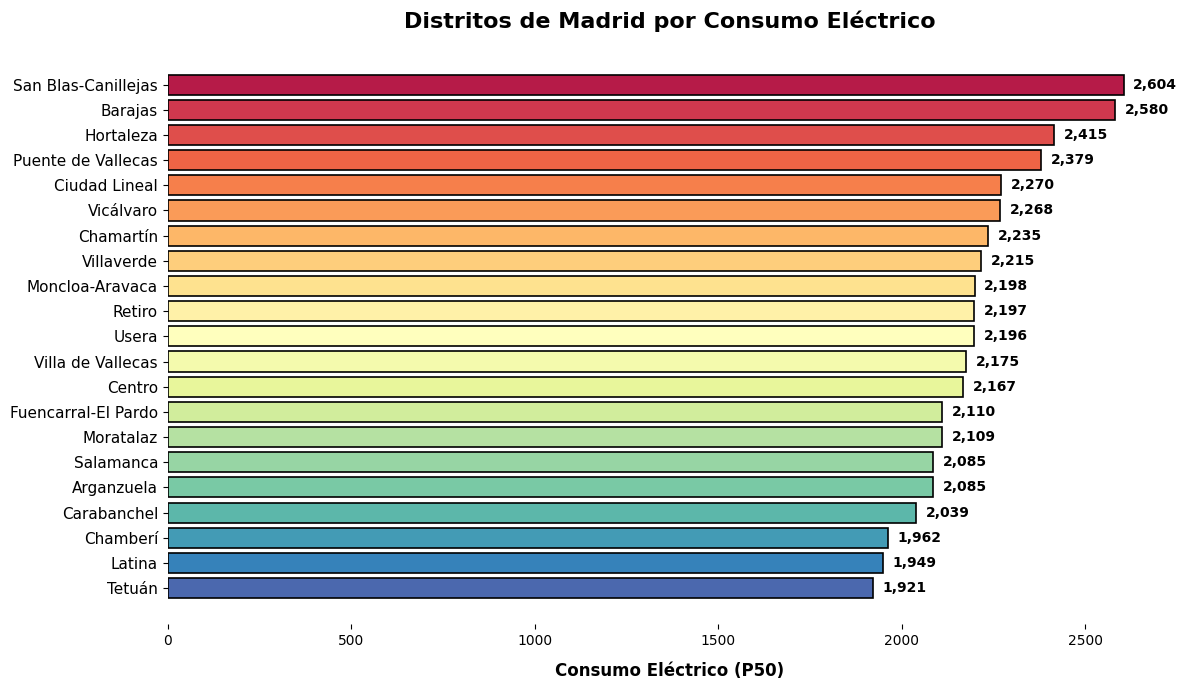

In [75]:
# Visualización 1: Distritos por consumo
plt.figure(figsize=(12, 8))
dist = df_main.nlargest(21, 'p50').sort_values('p50', ascending=False)
colors = sns.color_palette("Spectral", n_colors=len(dist))
fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras con borde negro
bars = ax.barh(dist['distrito'], dist['p50'],
               color=colors, edgecolor='black', linewidth=1.2)

# Etiquetas numéricas al final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + (max(dist['p50']) * 0.01),
            bar.get_y() + bar.get_height()/2,
            f'{width:,.0f}',
            va='center', ha='left', fontweight='bold', fontsize=10)

ax.set_xlabel('Consumo Eléctrico (P50)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('')
ax.set_title('Distritos de Madrid por Consumo Eléctrico', 
             fontsize=16, fontweight='bold', pad=15)

# Quitar bordes extra
sns.despine(left=True, bottom=True)

# Ajustes de ejes
ax.invert_yaxis()  # Para que el mayor esté arriba
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()
plt.show()

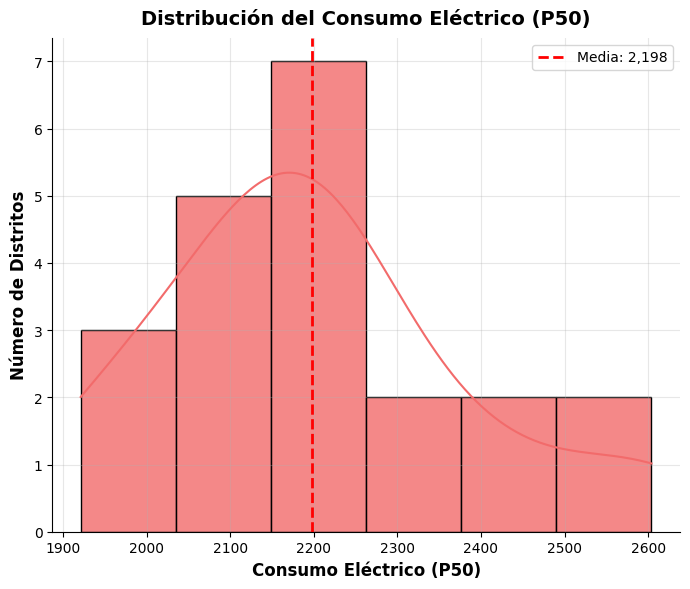

In [76]:
# === HISTOGRAMA DEL CONSUMO ELÉCTRICO (P50) ===
plt.figure(figsize=(7, 6))

sns.histplot(
    data=df_main, 
    x='p50', 
    bins=6, 
    kde=True, 
    color='#F26B6B', 
    edgecolor='black', 
    alpha=0.8
)

# Línea de la media
mean_value = df_main['p50'].mean()
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_value:,.0f}')

# Etiquetas y estilo
plt.title('Distribución del Consumo Eléctrico (P50)', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Consumo Eléctrico (P50)', fontsize=12, fontweight='bold')
plt.ylabel('Número de Distritos', fontsize=12, fontweight='bold')
plt.legend(frameon=True)
sns.despine()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


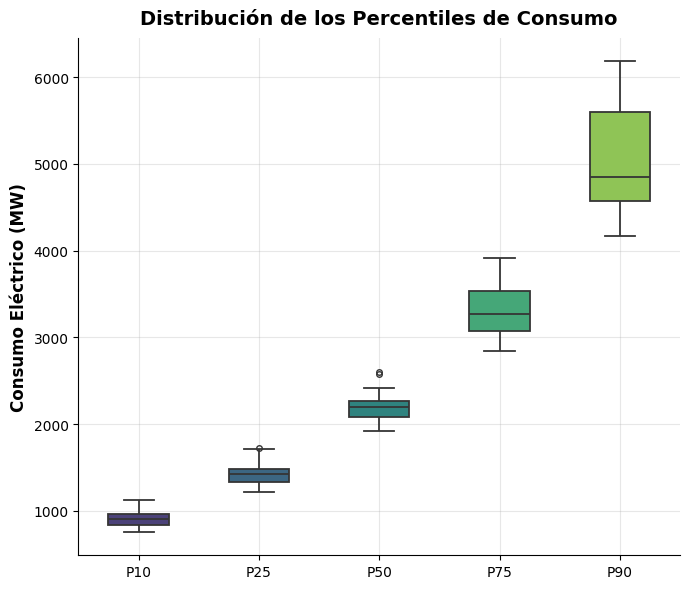

In [77]:
# === BOX PLOT DE PERCENTILES ===
plt.figure(figsize=(7, 6))

# Reorganizar los datos
percentiles_data = df_main[['p10', 'p25', 'p50', 'p75', 'p90']]
percentiles_data.columns = ['P10', 'P25', 'P50', 'P75', 'P90']

# Boxplot con paleta "viridis"
sns.boxplot(
    data=percentiles_data,
    palette=sns.color_palette("viridis", len(percentiles_data.columns)),
    width=0.5,
    fliersize=4,
    linewidth=1.3
)

# Etiquetas y estilo
plt.title('Distribución de los Percentiles de Consumo', fontsize=14, fontweight='bold', pad=10)
plt.ylabel('Consumo Eléctrico (MW)', fontsize=12, fontweight='bold')
plt.xlabel('')
sns.despine()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


📊 Análisis de Rango Intercuartílico (IQR) del Consumo Eléctrico por Distritos
El IQR revela diferencias significativas en el consumo residencial



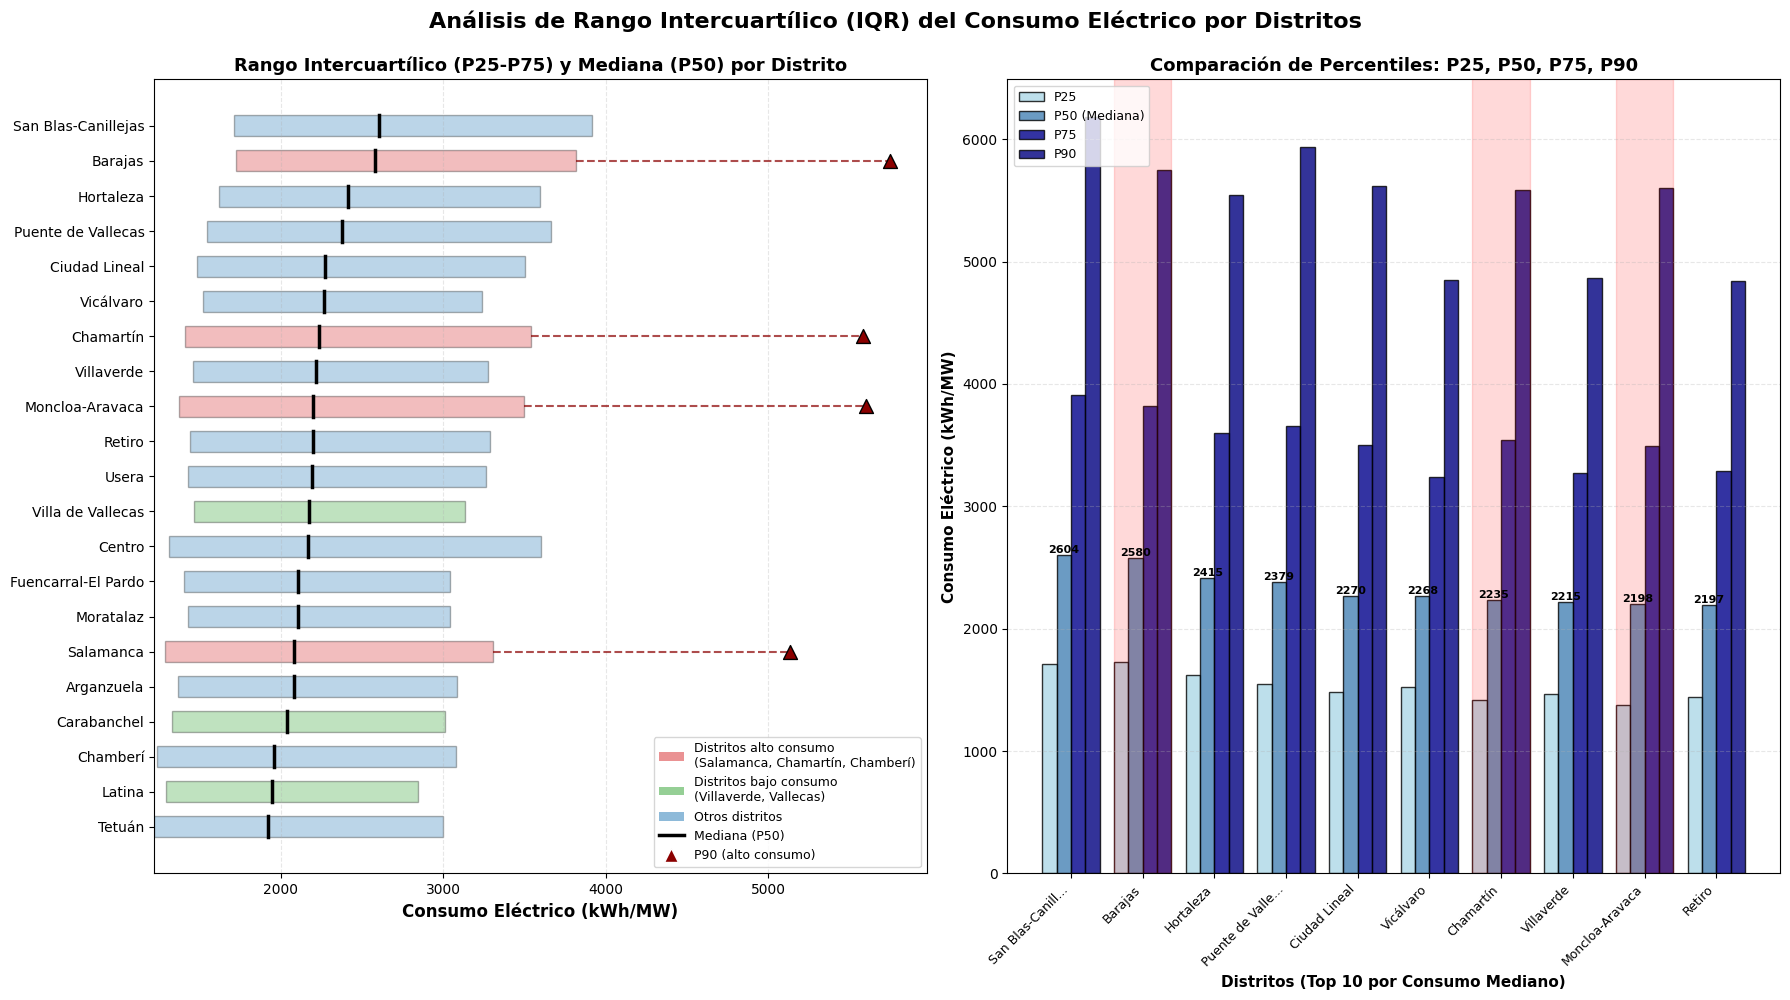


📊 ESTADÍSTICAS DESCRIPTIVAS DEL IQR:
----------------------------------------------------------------------
   IQR promedio: 1886.62
   IQR mediano: 1834.00
   IQR máximo: 2289.00 (Distrito: Centro)
   IQR mínimo: 1549.00 (Distrito: Latina)

💰 DISTRITOS DE ALTO CONSUMO (P75 y P90 elevados):
----------------------------------------------------------------------
   • Salamanca:
     - P50 (Mediana): 2085.00
     - P75: 3308.00
     - P90: 5135.00
     - IQR: 2019.00
   • Chamartín:
     - P50 (Mediana): 2235.00
     - P75: 3538.00
     - P90: 5583.00
     - IQR: 2125.00
   • Barajas:
     - P50 (Mediana): 2580.00
     - P75: 3817.00
     - P90: 5748.00
     - IQR: 2092.00
   • Moncloa-Aravaca:
     - P50 (Mediana): 2198.00
     - P75: 3495.00
     - P90: 5599.00
     - IQR: 2117.00

🏘️ DISTRITOS DE BAJO CONSUMO (valores más reducidos):
----------------------------------------------------------------------
   • Latina:
     - P50 (Mediana): 1949.00
     - P75: 2844.00
     - P90: 4164.00

In [ ]:
# === ANÁLISIS DE RANGO INTERCUARTÍLICO (IQR) POR DISTRITOS ===
print("📊 Análisis de Rango Intercuartílico (IQR) del Consumo Eléctrico por Distritos")
print("=" * 70)
print("El IQR revela diferencias significativas en el consumo residencial")
print()

# Verificar que tenemos los datos de consumo con percentiles
if 'df_consumo' in locals() and not df_consumo.empty:
    # Asegurar que tenemos las columnas de percentiles
    percentil_cols = ['p10', 'p25', 'p50', 'p75', 'p90']
    available_cols = [col for col in percentil_cols if col in df_consumo.columns]
    
    if len(available_cols) >= 4 and 'distrito' in df_consumo.columns:
        # Preparar datos
        df_iqr = df_consumo[['distrito'] + available_cols].copy()
        
        # Calcular IQR (P75 - P25)
        if 'p25' in df_iqr.columns and 'p75' in df_iqr.columns:
            df_iqr['iqr'] = df_iqr['p75'] - df_iqr['p25']
        
        # Ordenar por P50 (mediana) para mejor visualización
        if 'p50' in df_iqr.columns:
            df_iqr = df_iqr.sort_values('p50', ascending=False)
        
        # Identificar distritos destacados
        distritos_alto_consumo = ['Salamanca', 'Chamartín', 'Barajas', 'Moncloa-Aravaca']
        distritos_bajo_consumo = ['Latina', 'Carabanchel', 'Villa de Vallecas']
        
        # Crear visualización
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))
        fig.suptitle('Análisis de Rango Intercuartílico (IQR) del Consumo Eléctrico por Distritos', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        # === GRÁFICO 1: IQR con P25, P50, P75 por distrito ===
        ax = axes[0]
        
        # Preparar datos para el gráfico
        distritos = df_iqr['distrito'].values
        
        # Colores: destacar distritos específicos
        colors = []
        for distrito in distritos:
            distrito_clean = str(distrito).strip()
            if any(d_alto in distrito_clean for d_alto in distritos_alto_consumo):
                colors.append('#d62728')  # Rojo para alto consumo
            elif any(d_bajo in distrito_clean for d_bajo in distritos_bajo_consumo):
                colors.append('#2ca02c')  # Verde para bajo consumo
            else:
                colors.append('#1f77b4')  # Azul para resto
        
        # Posiciones en el eje Y
        y_pos = np.arange(len(distritos))
        
        # Dibujar IQR (P25 a P75) como barras horizontales
        if 'p25' in df_iqr.columns and 'p75' in df_iqr.columns:
            for i, (distrito, p25, p75) in enumerate(zip(distritos, 
                                                         df_iqr['p25'].values, 
                                                         df_iqr['p75'].values)):
                # Barra del IQR (más ancha, semitransparente)
                ax.barh(i, p75 - p25, left=p25, height=0.6, alpha=0.3, 
                       color=colors[i], edgecolor='black', linewidth=1)
                
                # Línea mediana (P50)
                if 'p50' in df_iqr.columns:
                    ax.plot([df_iqr['p50'].iloc[i], df_iqr['p50'].iloc[i]], 
                           [i-0.3, i+0.3], color='black', linewidth=2.5, 
                           label='Mediana (P50)' if i == 0 else '')
        
        # Añadir P90 para distritos de alto consumo (como puntos)
        if 'p90' in df_iqr.columns:
            for i, distrito in enumerate(distritos):
                distrito_clean = str(distrito).strip()
                if any(d_alto in distrito_clean for d_alto in distritos_alto_consumo):
                    p90_val = df_iqr['p90'].iloc[i]
                    p75_val = df_iqr['p75'].iloc[i]
                    ax.scatter(p90_val, i, s=100, color='darkred', marker='^', 
                              zorder=5, edgecolors='black', linewidth=1)
                    # Línea conectando P75 a P90
                    ax.plot([p75_val, p90_val], [i, i], color='darkred', 
                           linestyle='--', linewidth=1.5, alpha=0.7)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels([str(d)[:25] for d in distritos], fontsize=10)
        ax.set_xlabel('Consumo Eléctrico (kWh/MW)', fontsize=12, fontweight='bold')
        ax.set_title('Rango Intercuartílico (P25-P75) y Mediana (P50) por Distrito', 
                     fontweight='bold', fontsize=13)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.invert_yaxis()
        
        # Leyenda
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#d62728', alpha=0.5, label='Distritos alto consumo\n(Salamanca, Chamartín, Chamberí)'),
            Patch(facecolor='#2ca02c', alpha=0.5, label='Distritos bajo consumo\n(Villaverde, Vallecas)'),
            Patch(facecolor='#1f77b4', alpha=0.5, label='Otros distritos'),
            plt.Line2D([0], [0], color='black', linewidth=2.5, label='Mediana (P50)'),
            plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='darkred', 
                      markersize=10, label='P90 (alto consumo)')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
        
        # === GRÁFICO 2: Comparación de Percentiles (P25, P50, P75, P90) ===
        ax = axes[1]
        
        # Seleccionar top 10 distritos por consumo (P50) para mejor visualización, 
        # sino puede quedar mal debido al figsize posterior
        top_10 = df_iqr.head(10)
        
        x_pos = np.arange(len(top_10))
        width = 0.2
        
        # Dibujar barras para cada percentil aseguramos la concordancia de colores
        if 'p25' in top_10.columns:
            bars1 = ax.bar(x_pos - 1.5*width, top_10['p25'], width, 
                          label='P25', color='lightblue', alpha=0.8, edgecolor='black')
        if 'p50' in top_10.columns:
            bars2 = ax.bar(x_pos - 0.5*width, top_10['p50'], width, 
                          label='P50 (Mediana)', color='steelblue', alpha=0.8, edgecolor='black')
        if 'p75' in top_10.columns:
            bars3 = ax.bar(x_pos + 0.5*width, top_10['p75'], width, 
                          label='P75', color='darkblue', alpha=0.8, edgecolor='black')
        if 'p90' in top_10.columns:
            bars4 = ax.bar(x_pos + 1.5*width, top_10['p90'], width, 
                          label='P90', color='navy', alpha=0.8, edgecolor='black')
        
        # Añadir valores en las barras de mediana
        if 'p50' in top_10.columns:
            for i, (bar, val) in enumerate(zip(bars2, top_10['p50'])):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(val)}', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Destacar distritos específicos
        for i, distrito in enumerate(top_10['distrito']):
            distrito_clean = str(distrito).strip()
            if any(d_alto in distrito_clean for d_alto in distritos_alto_consumo):
                ax.axvspan(i - 0.4, i + 0.4, alpha=0.15, color='red')
            elif any(d_bajo in distrito_clean for d_bajo in distritos_bajo_consumo):
                ax.axvspan(i - 0.4, i + 0.4, alpha=0.15, color='green')
        
        ax.set_xlabel('Distritos (Top 10 por Consumo Mediano)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Consumo Eléctrico (kWh/MW)', fontsize=11, fontweight='bold')
        ax.set_title('Comparación de Percentiles: P25, P50, P75, P90', 
                     fontweight='bold', fontsize=13)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d)[:15] + '...' if len(str(d)) > 15 else str(d) 
                            for d in top_10['distrito']], 
                           rotation=45, ha='right', fontsize=9)
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # === ESTADÍSTICAS DESCRIPTIVAS ===
        print("\n📊 ESTADÍSTICAS DESCRIPTIVAS DEL IQR:")
        print("-" * 70)
        
        if 'iqr' in df_iqr.columns:
            print(f"   IQR promedio: {df_iqr['iqr'].mean():.2f}")
            print(f"   IQR mediano: {df_iqr['iqr'].median():.2f}")
            print(f"   IQR máximo: {df_iqr['iqr'].max():.2f} (Distrito: {df_iqr.loc[df_iqr['iqr'].idxmax(), 'distrito']})")
            print(f"   IQR mínimo: {df_iqr['iqr'].min():.2f} (Distrito: {df_iqr.loc[df_iqr['iqr'].idxmin(), 'distrito']})")
        
        print("\n💰 DISTRITOS DE ALTO CONSUMO (P75 y P90 elevados):")
        print("-" * 70)
        for distrito_alto in distritos_alto_consumo:
            distrito_data = df_iqr[df_iqr['distrito'].str.contains(distrito_alto, case=False, na=False)]
            if not distrito_data.empty:
                row = distrito_data.iloc[0]
                print(f"   • {row['distrito']}:")
                if 'p50' in row:
                    print(f"     - P50 (Mediana): {row['p50']:.2f}")
                if 'p75' in row:
                    print(f"     - P75: {row['p75']:.2f}")
                if 'p90' in row:
                    print(f"     - P90: {row['p90']:.2f}")
                if 'iqr' in row:
                    print(f"     - IQR: {row['iqr']:.2f}")
        
        print("\n🏘️ DISTRITOS DE BAJO CONSUMO (valores más reducidos):")
        print("-" * 70)
        for distrito_bajo in distritos_bajo_consumo:
            distrito_data = df_iqr[df_iqr['distrito'].str.contains(distrito_bajo, case=False, na=False)]
            if not distrito_data.empty:
                row = distrito_data.iloc[0]
                print(f"   • {row['distrito']}:")
                if 'p50' in row:
                    print(f"     - P50 (Mediana): {row['p50']:.2f}")
                if 'p75' in row:
                    print(f"     - P75: {row['p75']:.2f}")
                if 'p90' in row:
                    print(f"     - P90: {row['p90']:.2f}")
                if 'iqr' in row:
                    print(f"     - IQR: {row['iqr']:.2f}")
        
        # Comparación estadística
        print("\n📈 COMPARACIÓN ESTADÍSTICA:")
        print("-" * 70)
        
        # Filtrar distritos alto y bajo consumo
        alto_mask = df_iqr['distrito'].str.contains('|'.join(distritos_alto_consumo), 
                                                          case=False, na=False)
        bajo_mask = df_iqr['distrito'].str.contains('|'.join(distritos_bajo_consumo), 
                                                          case=False, na=False)
        
        if alto_mask.any() and bajo_mask.any():
            alto_consumo = df_iqr[alto_mask]
            bajo_consumo = df_iqr[bajo_mask]
            
            if 'p50' in df_iqr.columns:
                print(f"   P50 promedio - Alto consumo: {alto_consumo['p50'].mean():.2f}")
                print(f"   P50 promedio - Bajo consumo: {bajo_consumo['p50'].mean():.2f}")
                diferencia = alto_consumo['p50'].mean() - bajo_consumo['p50'].mean()
                porcentaje = (diferencia / bajo_consumo['p50'].mean()) * 100
                print(f"   Diferencia: {diferencia:.2f} ({porcentaje:+.1f}%)")
            
            if 'p75' in df_iqr.columns:
                print(f"\n   P75 promedio - Alto consumo: {alto_consumo['p75'].mean():.2f}")
                print(f"   P75 promedio - Bajo consumo: {bajo_consumo['p75'].mean():.2f}")
            
            if 'p90' in df_iqr.columns:
                print(f"\n   P90 promedio - Alto consumo: {alto_consumo['p90'].mean():.2f}")
                print(f"   P90 promedio - Bajo consumo: {bajo_consumo['p90'].mean():.2f}")
        
        print("\n✅ Análisis de IQR completado")
        
    else:
        print("⚠️ No se encuentran las columnas de percentiles necesarias (p10, p25, p50, p75, p90)")
        print(f"   Columnas disponibles: {list(df_consumo.columns) if 'df_consumo' in locals() else 'N/A'}")
else:
    print("⚠️ No hay datos de consumo disponibles")

### 2.4. Análisis de Desigualdad Energética: Ratio P90/P10


📊 Análisis de Desigualdad Energética: Ratio P90/P10
Evaluación de la consistencia del consumo entre percentiles



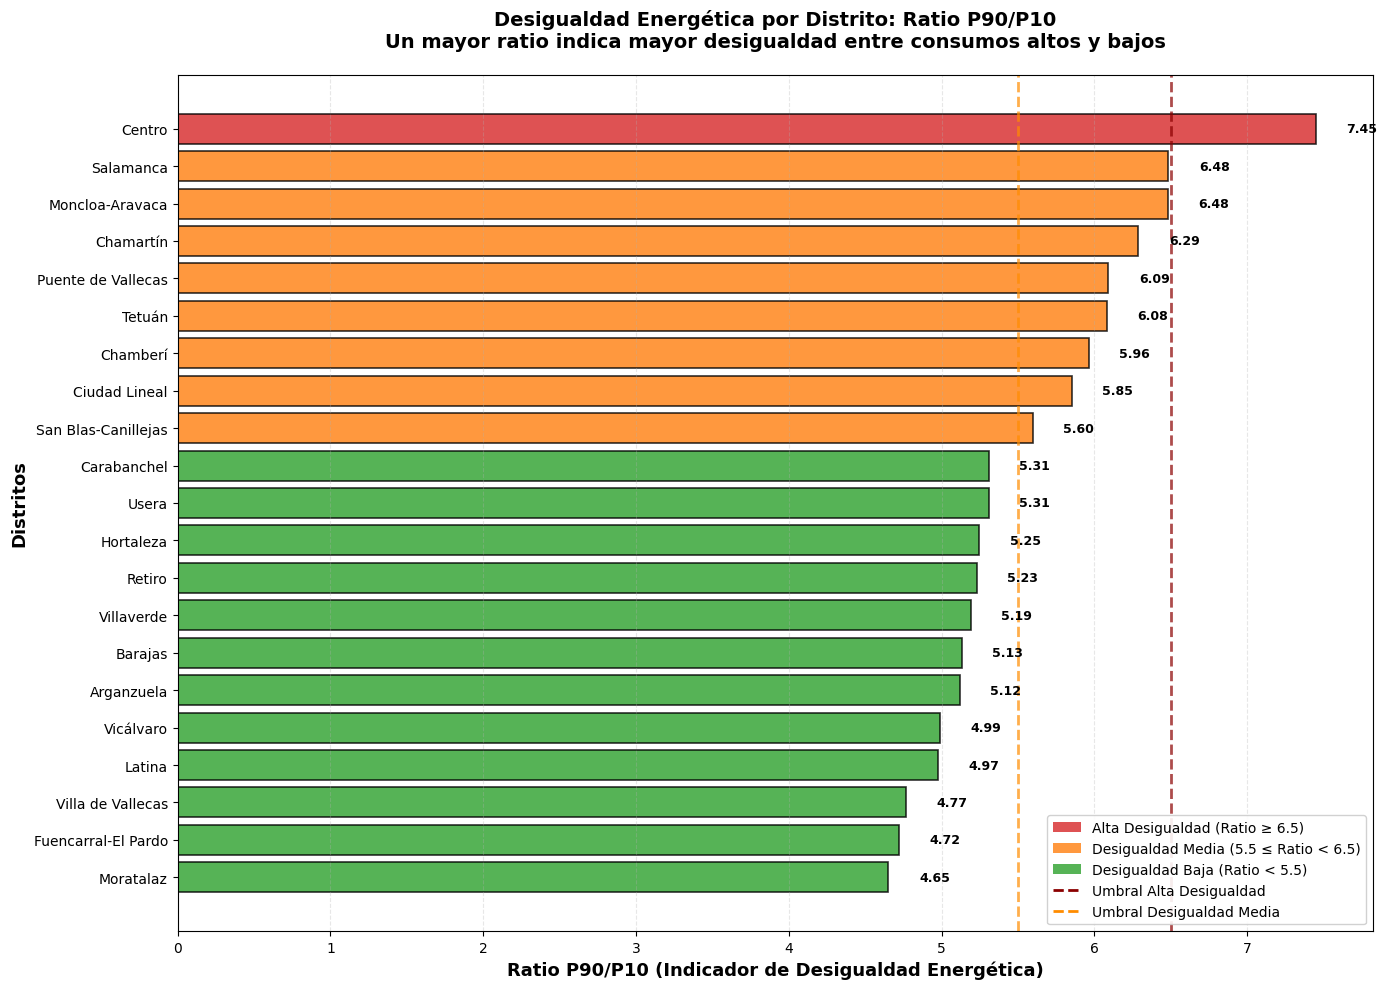


✅ Análisis de desigualdad energética completado


In [88]:
# === ANÁLISIS DE DESIGUALDAD ENERGÉTICA: RATIO P90/P10 ===
print("📊 Análisis de Desigualdad Energética: Ratio P90/P10")
print("=" * 70)
print("Evaluación de la consistencia del consumo entre percentiles\n")

# Nos aseguramos de que el dataset es correcto
if 'df_consumo' in locals() and not df_consumo.empty:
    if all(col in df_consumo.columns for col in ['distrito', 'p10', 'p90']):
        # Calcular ratio P90/P10
        df_desigualdad = df_consumo[['distrito', 'p10', 'p50', 'p90']].copy()
        df_desigualdad = df_desigualdad[
            (df_desigualdad['p10'] > 0) &
            (df_desigualdad['p90'] > df_desigualdad['p10'])
        ].copy()
        df_desigualdad['ratio_p90_p10'] = df_desigualdad['p90'] / df_desigualdad['p10']
        df_desigualdad['rango_absoluto'] = df_desigualdad['p90'] - df_desigualdad['p10']
        df_desigualdad['rango_relativo'] = (df_desigualdad['rango_absoluto'] / df_desigualdad['p50']) * 100
        df_desigualdad = df_desigualdad.sort_values('ratio_p90_p10', ascending=False)

        if len(df_desigualdad) > 0:
            fig, ax = plt.subplots(figsize=(14, 10))

            # Colores según nivel de desigualdad
            colors = []
            for ratio in df_desigualdad['ratio_p90_p10']:
                if ratio >= 6.5:
                    colors.append('#d62728')  # Alta
                elif ratio >= 5.5:
                    colors.append('#ff7f0e')  # Media
                else:
                    colors.append('#2ca02c')  # Baja

            # Barras horizontales
            bars = ax.barh(
                range(len(df_desigualdad)),
                df_desigualdad['ratio_p90_p10'],
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2
            )

            # Líneas de referencia
            ax.axvline(6.5, color='darkred', linestyle='--', linewidth=2,
                       alpha=0.7, label='Alta Desigualdad (≥6.5)')
            ax.axvline(5.5, color='darkorange', linestyle='--', linewidth=2,
                       alpha=0.7, label='Desigualdad Media (≥5.5)')

            # Etiquetas de distritos
            ax.set_yticks(range(len(df_desigualdad)))
            ax.set_yticklabels(df_desigualdad['distrito'], fontsize=10)

            # Etiquetas de ejes y título
            ax.set_xlabel('Ratio P90/P10 (Indicador de Desigualdad Energética)', fontsize=13, fontweight='bold')
            ax.set_ylabel('Distritos', fontsize=13, fontweight='bold')
            ax.set_title(
                'Desigualdad Energética por Distrito: Ratio P90/P10\n'
                'Un mayor ratio indica mayor desigualdad entre consumos altos y bajos',
                fontsize=14, fontweight='bold', pad=20
            )

            # === Añadir valores numéricos en las barras ===
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(
                    width + 0.2, bar.get_y() + bar.get_height()/2,
                    f"{width:.2f}", ha='left', va='center',
                    fontsize=9, fontweight='bold'
                )

            # Leyenda de colores
            
            legend_elements = [
                Patch(facecolor='#d62728', alpha=0.8, label='Alta Desigualdad (Ratio ≥ 6.5)'),
                Patch(facecolor='#ff7f0e', alpha=0.8, label='Desigualdad Media (5.5 ≤ Ratio < 6.5)'),
                Patch(facecolor='#2ca02c', alpha=0.8, label='Desigualdad Baja (Ratio < 5.5)'),
                plt.Line2D([0], [0], color='darkred', linestyle='--', linewidth=2, label='Umbral Alta Desigualdad'),
                plt.Line2D([0], [0], color='darkorange', linestyle='--', linewidth=2, label='Umbral Desigualdad Media')
            ]
            ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

            # Estilo final
            ax.grid(axis='x', alpha=0.3, linestyle='--', zorder=0)
            ax.invert_yaxis()
            plt.tight_layout()
            plt.show()

            print("\n✅ Análisis de desigualdad energética completado")


📊 Jerarquía Energética: Consumo Mediano (P50) por Distritos de Madrid
Análisis de la concentración del consumo en zonas norte/centro vs sur/sureste



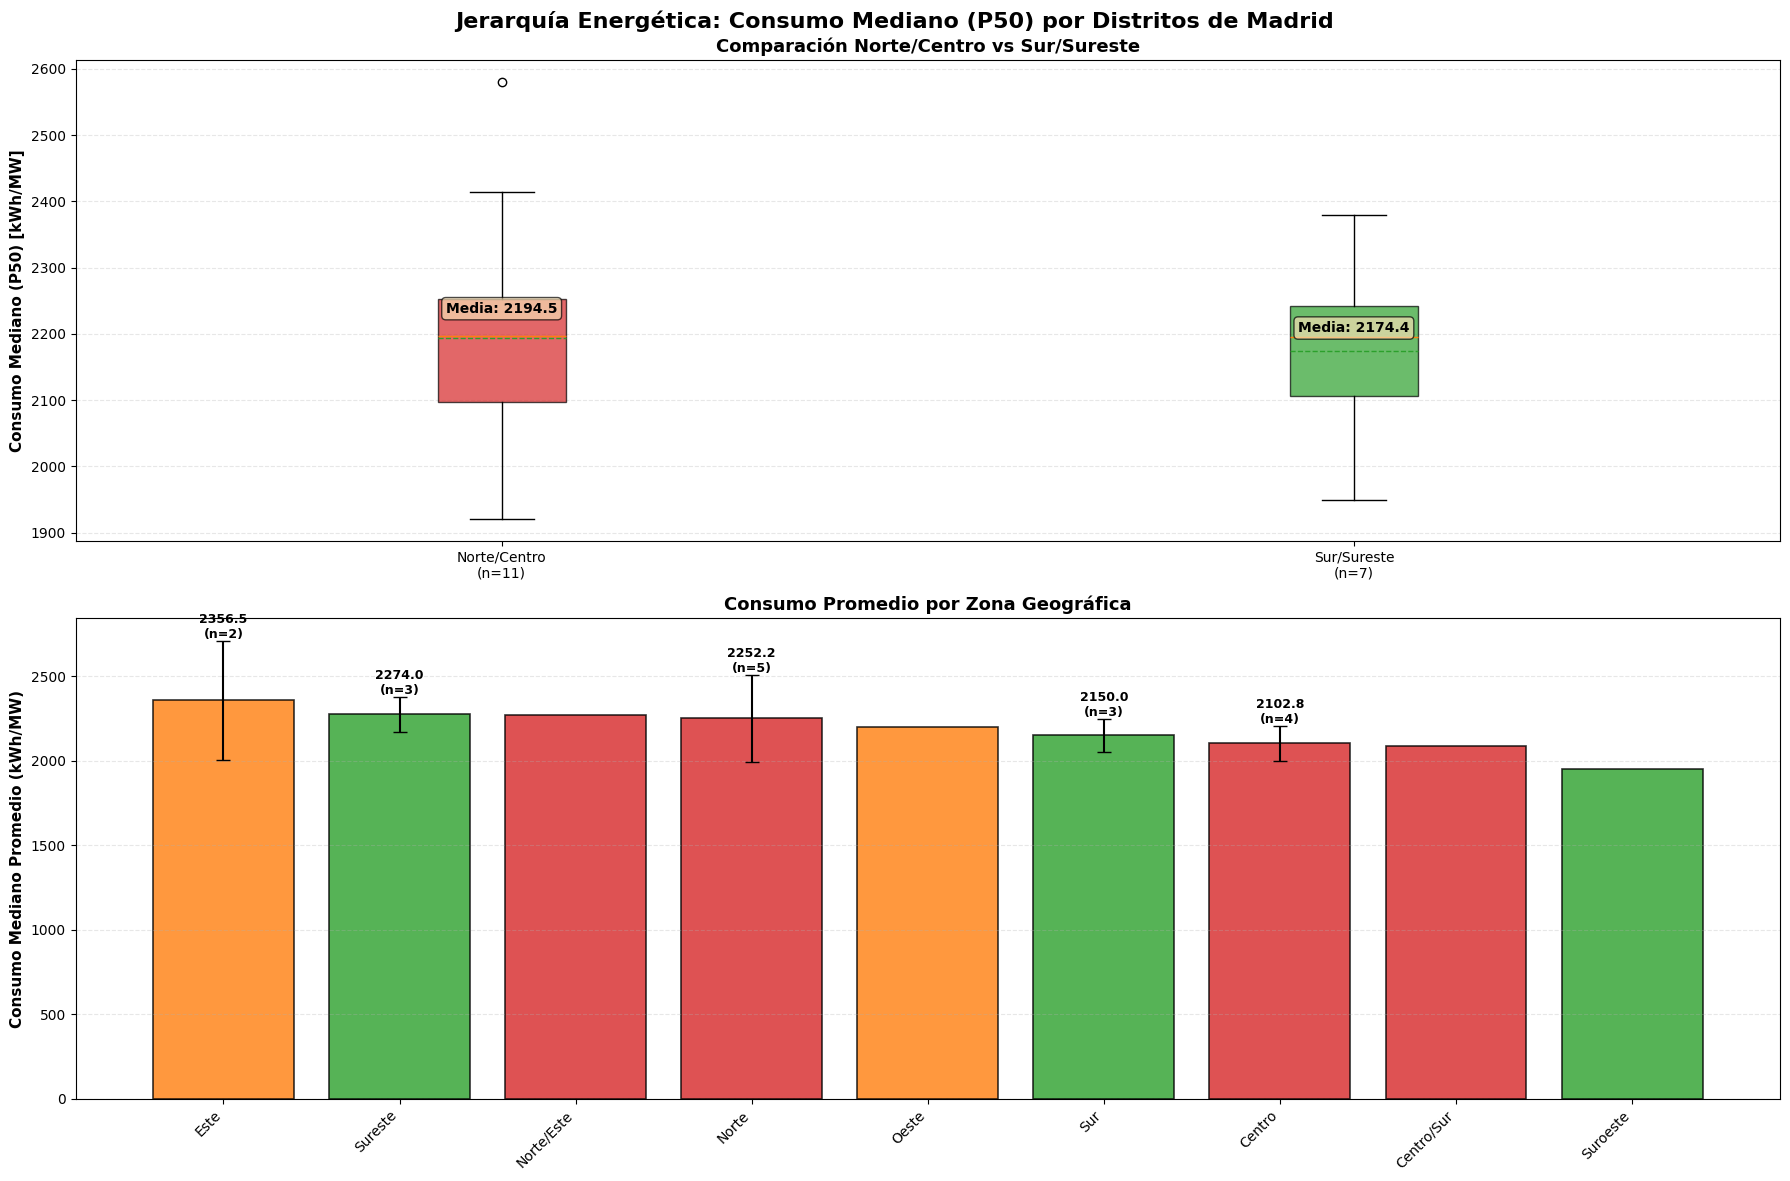


📊 ESTADÍSTICAS DE JERARQUÍA ENERGÉTICA
----------------------------------------------------------------------

📍 NORTE/CENTRO
   Distritos: Barajas, Hortaleza, Ciudad Lineal, Chamartín, Moncloa-Aravaca, Retiro, Centro, Fuencarral-El Pardo, Salamanca, Chamberí, Tetuán
   Promedio P50: 2194.55
   Mínimo: 1921.00 (Tetuán)
   Máximo: 2580.00 (Barajas)

📍 SUR/SURESTE
   Distritos: Puente de Vallecas, Vicálvaro, Villaverde, Usera, Villa de Vallecas, Carabanchel, Latina
   Promedio P50: 2174.43
   Mínimo: 1949.00 (Latina)
   Máximo: 2379.00 (Puente de Vallecas)

📈 Diferencia media Norte/Centro vs Sur/Sureste: 20.12 kWh/MW (+0.9%)

🏆 TOP 5 DISTRITOS POR CONSUMO MEDIANO:
           distrito  p50
San Blas-Canillejas 2604
            Barajas 2580
          Hortaleza 2415
 Puente de Vallecas 2379
      Ciudad Lineal 2270

📉 BOTTOM 5 DISTRITOS POR CONSUMO MEDIANO:
   distrito  p50
 Arganzuela 2085
Carabanchel 2039
   Chamberí 1962
     Latina 1949
     Tetuán 1921

✅ Análisis de jerarquía energéti

In [ ]:
# === JERARQUÍA ENERGÉTICA: CONSUMO MEDIANO (P50) POR DISTRITOS ===
print("📊 Jerarquía Energética: Consumo Mediano (P50) por Distritos de Madrid")
print("=" * 70)
print("Análisis de la concentración del consumo en zonas norte/centro vs sur/sureste")
print()

# Verificar datos
if 'df_consumo' in locals() and not df_consumo.empty:
    # Comprobar columnas
    if {'p50', 'distrito'}.issubset(df_consumo.columns):
        
        # --- Preparación de datos ---
        df_jerarquia = df_consumo[['distrito', 'p50']].copy()
        df_jerarquia = df_jerarquia.sort_values('p50', ascending=False).reset_index(drop=True)

        # --- Asignación de zonas geográficas ---
        mapa_zonas = {
            # Norte / Centro
            'Chamartín': 'Norte',
            'Salamanca': 'Centro',
            'Chamberí': 'Centro',
            'Retiro': 'Centro',
            'Centro': 'Centro',
            'Fuencarral-El Pardo': 'Norte',
            'Hortaleza': 'Norte',
            'Tetuán': 'Norte',
            'Moncloa-Aravaca': 'Oeste',
            'Barajas': 'Norte',
            'Ciudad Lineal': 'Norte/Este',
            # Sur / Sureste
            'Villaverde': 'Sur',
            'Puente de Vallecas': 'Sureste',
            'Usera': 'Sur',
            'Carabanchel': 'Sur',
            'Latina': 'Suroeste',
            'Villa de Vallecas': 'Sureste',
            'Vicálvaro': 'Sureste',
            # Intermedios
            'Arganzuela': 'Centro/Sur',
            'Moratalaz': 'Este',
            'San Blas-Canillejas': 'Este'
        }

        df_jerarquia['zona'] = df_jerarquia['distrito'].map(mapa_zonas).fillna('Otras')

        # --- Comparación Norte/Centro vs Sur/Sureste ---
        zonas_alto = ['Norte', 'Centro', 'Oeste', 'Norte/Este']
        zonas_bajo = ['Sur', 'Sureste', 'Suroeste']

        alto_mask = df_jerarquia['zona'].isin(zonas_alto)
        bajo_mask = df_jerarquia['zona'].isin(zonas_bajo)

        # --- Visualizaciones ---
        fig, axes = plt.subplots(2, 1, figsize=(18, 12))
        fig.suptitle('Jerarquía Energética: Consumo Mediano (P50) por Distritos de Madrid', 
                     fontsize=16, fontweight='bold')

        # === GRÁFICO 1: Boxplot Norte/Centro vs Sur/Sureste ===
        ax = axes[0]

        grupos = []
        etiquetas = []
        colores = []

        if alto_mask.any():
            grupos.append(df_jerarquia.loc[alto_mask, 'p50'])
            etiquetas.append(f'Norte/Centro\n(n={alto_mask.sum()})')
            colores.append('#d62728')
        if bajo_mask.any():
            grupos.append(df_jerarquia.loc[bajo_mask, 'p50'])
            etiquetas.append(f'Sur/Sureste\n(n={bajo_mask.sum()})')
            colores.append('#2ca02c')

        bp = ax.boxplot(grupos, labels=etiquetas, patch_artist=True, showmeans=True, meanline=True)

        for patch, color in zip(bp['boxes'], colores):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        for i, grupo in enumerate(grupos):
            media = grupo.mean()
            ax.text(i+1, media + grupo.std() * 0.2,
                    f'Media: {media:.1f}', ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

        ax.set_ylabel('Consumo Mediano (P50) [kWh/MW]', fontsize=11, fontweight='bold')
        ax.set_title('Comparación Norte/Centro vs Sur/Sureste', fontweight='bold', fontsize=13)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        # === GRÁFICO 2: Consumo promedio por zona ===
        ax = axes[1]

        zonas_stats = (
            df_jerarquia.groupby('zona')['p50']
            .agg(['mean', 'std', 'count'])
            .reset_index()
            .sort_values('mean', ascending=False)
        )

        colores_zona = [
            '#d62728' if any(x in z for x in ['Norte', 'Centro']) else
            '#2ca02c' if any(x in z for x in ['Sur', 'Sureste', 'Suroeste']) else
            '#ff7f0e'
            for z in zonas_stats['zona']
        ]

        bars = ax.bar(zonas_stats['zona'], zonas_stats['mean'], yerr=zonas_stats['std'],
                      capsize=5, color=colores_zona, edgecolor='black', linewidth=1.2, alpha=0.8)

        for i, (bar, val, n) in enumerate(zip(bars, zonas_stats['mean'], zonas_stats['count'])):
            ax.text(bar.get_x() + bar.get_width()/2, val + zonas_stats['std'].iloc[i],
                    f'{val:.1f}\n(n={n})', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.set_ylabel('Consumo Mediano Promedio (kWh/MW)', fontsize=11, fontweight='bold')
        ax.set_title('Consumo Promedio por Zona Geográfica', fontsize=13, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_xticklabels(zonas_stats['zona'], rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # === Estadísticas resumidas ===
        print("\n📊 ESTADÍSTICAS DE JERARQUÍA ENERGÉTICA")
        print("-" * 70)

        def resumen_zona(nombre, mask):
            if not mask.any():
                print(f"⚠️ No hay datos para {nombre}")
                return
            subset = df_jerarquia.loc[mask]
            print(f"\n📍 {nombre.upper()}")
            print(f"   Distritos: {', '.join(subset['distrito'])}")
            print(f"   Promedio P50: {subset['p50'].mean():.2f}")
            print(f"   Mínimo: {subset['p50'].min():.2f} ({subset.loc[subset['p50'].idxmin(), 'distrito']})")
            print(f"   Máximo: {subset['p50'].max():.2f} ({subset.loc[subset['p50'].idxmax(), 'distrito']})")

        resumen_zona('Norte/Centro', alto_mask)
        resumen_zona('Sur/Sureste', bajo_mask)

        if alto_mask.any() and bajo_mask.any():
            diferencia = df_jerarquia.loc[alto_mask, 'p50'].mean() - df_jerarquia.loc[bajo_mask, 'p50'].mean()
            porcentaje = (diferencia / df_jerarquia.loc[bajo_mask, 'p50'].mean()) * 100
            print(f"\n📈 Diferencia media Norte/Centro vs Sur/Sureste: {diferencia:.2f} kWh/MW ({porcentaje:+.1f}%)")

        print("\n🏆 TOP 5 DISTRITOS POR CONSUMO MEDIANO:")
        print(df_jerarquia.head(5)[['distrito', 'p50']].to_string(index=False))

        print("\n📉 BOTTOM 5 DISTRITOS POR CONSUMO MEDIANO:")
        print(df_jerarquia.tail(5)[['distrito', 'p50']].to_string(index=False))

        print("\n✅ Análisis de jerarquía energética completado con éxito")


In [90]:
# === VISUALIZACIÓN GEOGRÁFICA INTERACTIVA CON FOLIUM ===
print("🗺️ Visualización Geográfica Interactiva: Consumo por Distritos de Madrid")
print("=" * 70)

try:
    import folium
    from folium import plugins
    from folium.plugins import HeatMap
    
    # Coordenadas aproximadas de los distritos de Madrid (centroide)
    # Basadas en la ubicación geográfica real de cada distrito
    coordenadas_distritos = {
        'Centro': [40.4170, -3.7036],
        'Arganzuela': [40.3900, -3.6967],
        'Retiro': [40.4100, -3.6800],
        'Salamanca': [40.4290, -3.6750],
        'Chamartín': [40.4650, -3.6730],
        'Tetuán': [40.4630, -3.6967],
        'Chamberí': [40.4350, -3.7000],
        'Fuencarral-El Pardo': [40.4850, -3.7450],
        'Moncloa-Aravaca': [40.4380, -3.7200],
        'Latina': [40.3880, -3.7480],
        'Carabanchel': [40.3850, -3.7280],
        'Usera': [40.3880, -3.7067],
        'Puente de Vallecas': [40.3900, -3.6400],
        'Moratalaz': [40.4070, -3.6450],
        'Ciudad Lineal': [40.4380, -3.6400],
        'Hortaleza': [40.4750, -3.6500],
        'Villaverde': [40.3580, -3.7000],
        'Villa de Vallecas': [40.3700, -3.6200],
        'Vicálvaro': [40.4030, -3.6000],
        'San Blas-Canillejas': [40.4330, -3.6200],
        'Barajas': [40.4900, -3.5800]
    }
    
    # Preparar datos de consumo
    if 'df_consumo' in locals() and not df_consumo.empty:
        if 'p50' in df_consumo.columns and 'distrito' in df_consumo.columns:
            # Crear DataFrame con consumo y coordenadas
            df_mapa = df_consumo[['distrito', 'p50']].copy()
            
            # Añadir coordenadas
            df_mapa['lat'] = df_mapa['distrito'].apply(
                lambda x: next((coords[0] for dist, coords in coordenadas_distritos.items() 
                               if dist.lower() in str(x).lower() or str(x).lower() in dist.lower()), 
                              40.4168)  # Default: centro de Madrid
            )
            df_mapa['lon'] = df_mapa['distrito'].apply(
                lambda x: next((coords[1] for dist, coords in coordenadas_distritos.items() 
                               if dist.lower() in str(x).lower() or str(x).lower() in dist.lower()), 
                              -3.7038)  # Default: centro de Madrid
            )
            
            # Calcular estadísticas para colorear
            min_consumo = df_mapa['p50'].min()
            max_consumo = df_mapa['p50'].max()
            mean_consumo = df_mapa['p50'].mean()
            
            # Crear mapa centrado en Madrid
            mapa = folium.Map(
                location=[40.4168, -3.7038],  # Centro de Madrid
                zoom_start=11,
                tiles='OpenStreetMap'
            )
            
            # Añadir capa de CartoDB positron (más limpia)
            folium.TileLayer(
                tiles='CartoDB positron',
                name='Mapa Limpio',
                overlay=False,
                control=True
            ).add_to(mapa)
            
            # Función para obtener color según consumo
            def get_color(consumo, min_val, max_val):
                """Devuelve color en gradiente de verde (bajo) a rojo (alto)"""
                if pd.isna(consumo):
                    return 'gray'
                
                # Normalizar entre 0 y 1
                normalized = (consumo - min_val) / (max_val - min_val) if max_val != min_val else 0.5
                
                # Gradiente: verde (bajo) -> amarillo -> naranja -> rojo (alto)
                if normalized < 0.25:
                    return 'green'
                elif normalized < 0.5:
                    return 'yellow'
                elif normalized < 0.75:
                    return 'orange'
                else:
                    return 'red'
            
            # Añadir marcadores circulares para cada distrito
            for idx, row in df_mapa.iterrows():
                distrito = row['distrito']
                consumo = row['p50']
                lat = row['lat']
                lon = row['lon']
                
                color = get_color(consumo, min_consumo, max_consumo)
                
                # Tamaño del círculo proporcional al consumo
                radio = 500 + (consumo - min_consumo) / (max_consumo - min_consumo) * 1500 if max_consumo != min_consumo else 1000
                
                # Obtener información adicional del distrito si está disponible
                popup_text = f"<b>{distrito}</b><br>"
                popup_text += f"Consumo Mediano (P50): <b>{consumo:.0f} kWh/MW</b><br>"
                
                # Añadir percentiles si están disponibles
                if 'p25' in df_consumo.columns:
                    p25_val = df_consumo.loc[df_consumo['distrito'] == distrito, 'p25'].values
                    if len(p25_val) > 0:
                        popup_text += f"P25: {p25_val[0]:.0f}<br>"
                
                if 'p75' in df_consumo.columns:
                    p75_val = df_consumo.loc[df_consumo['distrito'] == distrito, 'p75'].values
                    if len(p75_val) > 0:
                        popup_text += f"P75: {p75_val[0]:.0f}<br>"
                
                # Clasificación
                if consumo >= mean_consumo * 1.1:
                    clasificacion = "Alto"
                elif consumo <= mean_consumo * 0.9:
                    clasificacion = "Bajo"
                else:
                    clasificacion = "Medio"
                
                popup_text += f"<br><i>Clasificación: {clasificacion}</i>"
                
                # Crear marcador circular
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=15,
                    popup=folium.Popup(popup_text, max_width=250),
                    tooltip=f"{distrito}: {consumo:.0f} kWh/MW",
                    color='black',
                    weight=2,
                    fillColor=color,
                    fillOpacity=0.7
                ).add_to(mapa)
            
            # Añadir heatmap de consumo (si hay suficientes puntos)
            if len(df_mapa) > 5:
                heat_data = [[row['lat'], row['lon'], row['p50']] 
                            for idx, row in df_mapa.iterrows()]
                HeatMap(heat_data, radius=15, blur=10, max_zoom=13, 
                       gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'},
                       min_opacity=0.5).add_to(mapa)
            
            # Añadir leyenda
            legend_html = f'''
            <div style="position: fixed; 
                        bottom: 50px; left: 50px; width: 200px; height: 180px; 
                        background-color: white; border:2px solid grey; z-index:9999; 
                        font-size:14px; padding: 10px">
            <h4 style="margin-top: 0; margin-bottom: 10px;">Consumo Mediano (P50)</h4>
            <p style="margin: 5px 0;"><i class="fa fa-circle" style="color:green"></i> Bajo (< {mean_consumo*0.9:.0f})</p>
            <p style="margin: 5px 0;"><i class="fa fa-circle" style="color:yellow"></i> Medio-Bajo</p>
            <p style="margin: 5px 0;"><i class="fa fa-circle" style="color:orange"></i> Medio-Alto</p>
            <p style="margin: 5px 0;"><i class="fa fa-circle" style="color:red"></i> Alto (>{mean_consumo*1.1:.0f})</p>
            <hr>
            <p style="margin: 5px 0; font-size: 11px;">Rango: {min_consumo:.0f} - {max_consumo:.0f} kWh/MW</p>
            <p style="margin: 5px 0; font-size: 11px;">Media: {mean_consumo:.0f} kWh/MW</p>
            </div>
            '''
            mapa.get_root().html.add_child(folium.Element(legend_html))
            
            # Añadir control de capas
            folium.LayerControl().add_to(mapa)
            
            # Mostrar mapa
            print(f"\n✅ Mapa interactivo creado con {len(df_mapa)} distritos")
            print(f"   Rango de consumo: {min_consumo:.0f} - {max_consumo:.0f} kWh/MW")
            print(f"   Consumo promedio: {mean_consumo:.0f} kWh/MW")
            print("\n💡 Instrucciones:")
            print("   - Haz clic en los círculos para ver detalles")
            print("   - Usa el zoom y arrastra para navegar")
            print("   - Cambia la capa del mapa en la esquina superior derecha")
            
            display(mapa)
            
            # Guardar mapa como HTML (opcional)
            try:
                output_path = 'data/processed/mapa_consumo_distritos.html'
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                mapa.save(output_path)
                print(f"\n💾 Mapa guardado en: {output_path}")
            except Exception as e:
                print(f"\n⚠️ No se pudo guardar el mapa: {e}")
            
        else:
            print("⚠️ No se encuentran las columnas necesarias (p50, distrito)")
    else:
        print("⚠️ No hay datos de consumo disponibles")
        
except ImportError:
    print("⚠️ Folium no está instalado. Instálalo con: pip install folium")
    print("   Alternativamente, ejecuta esta celda en un entorno con Folium disponible")
except Exception as e:
    print(f"❌ Error al crear el mapa: {e}")
    print("   Verifica que los datos estén cargados correctamente")



🗺️ Visualización Geográfica Interactiva: Consumo por Distritos de Madrid

✅ Mapa interactivo creado con 21 distritos
   Rango de consumo: 1921 - 2604 kWh/MW
   Consumo promedio: 2198 kWh/MW

💡 Instrucciones:
   - Haz clic en los círculos para ver detalles
   - Usa el zoom y arrastra para navegar
   - Cambia la capa del mapa en la esquina superior derecha



💾 Mapa guardado en: data/processed/mapa_consumo_distritos.html


📊 Análisis de Asimetría en la Distribución del Consumo Eléctrico


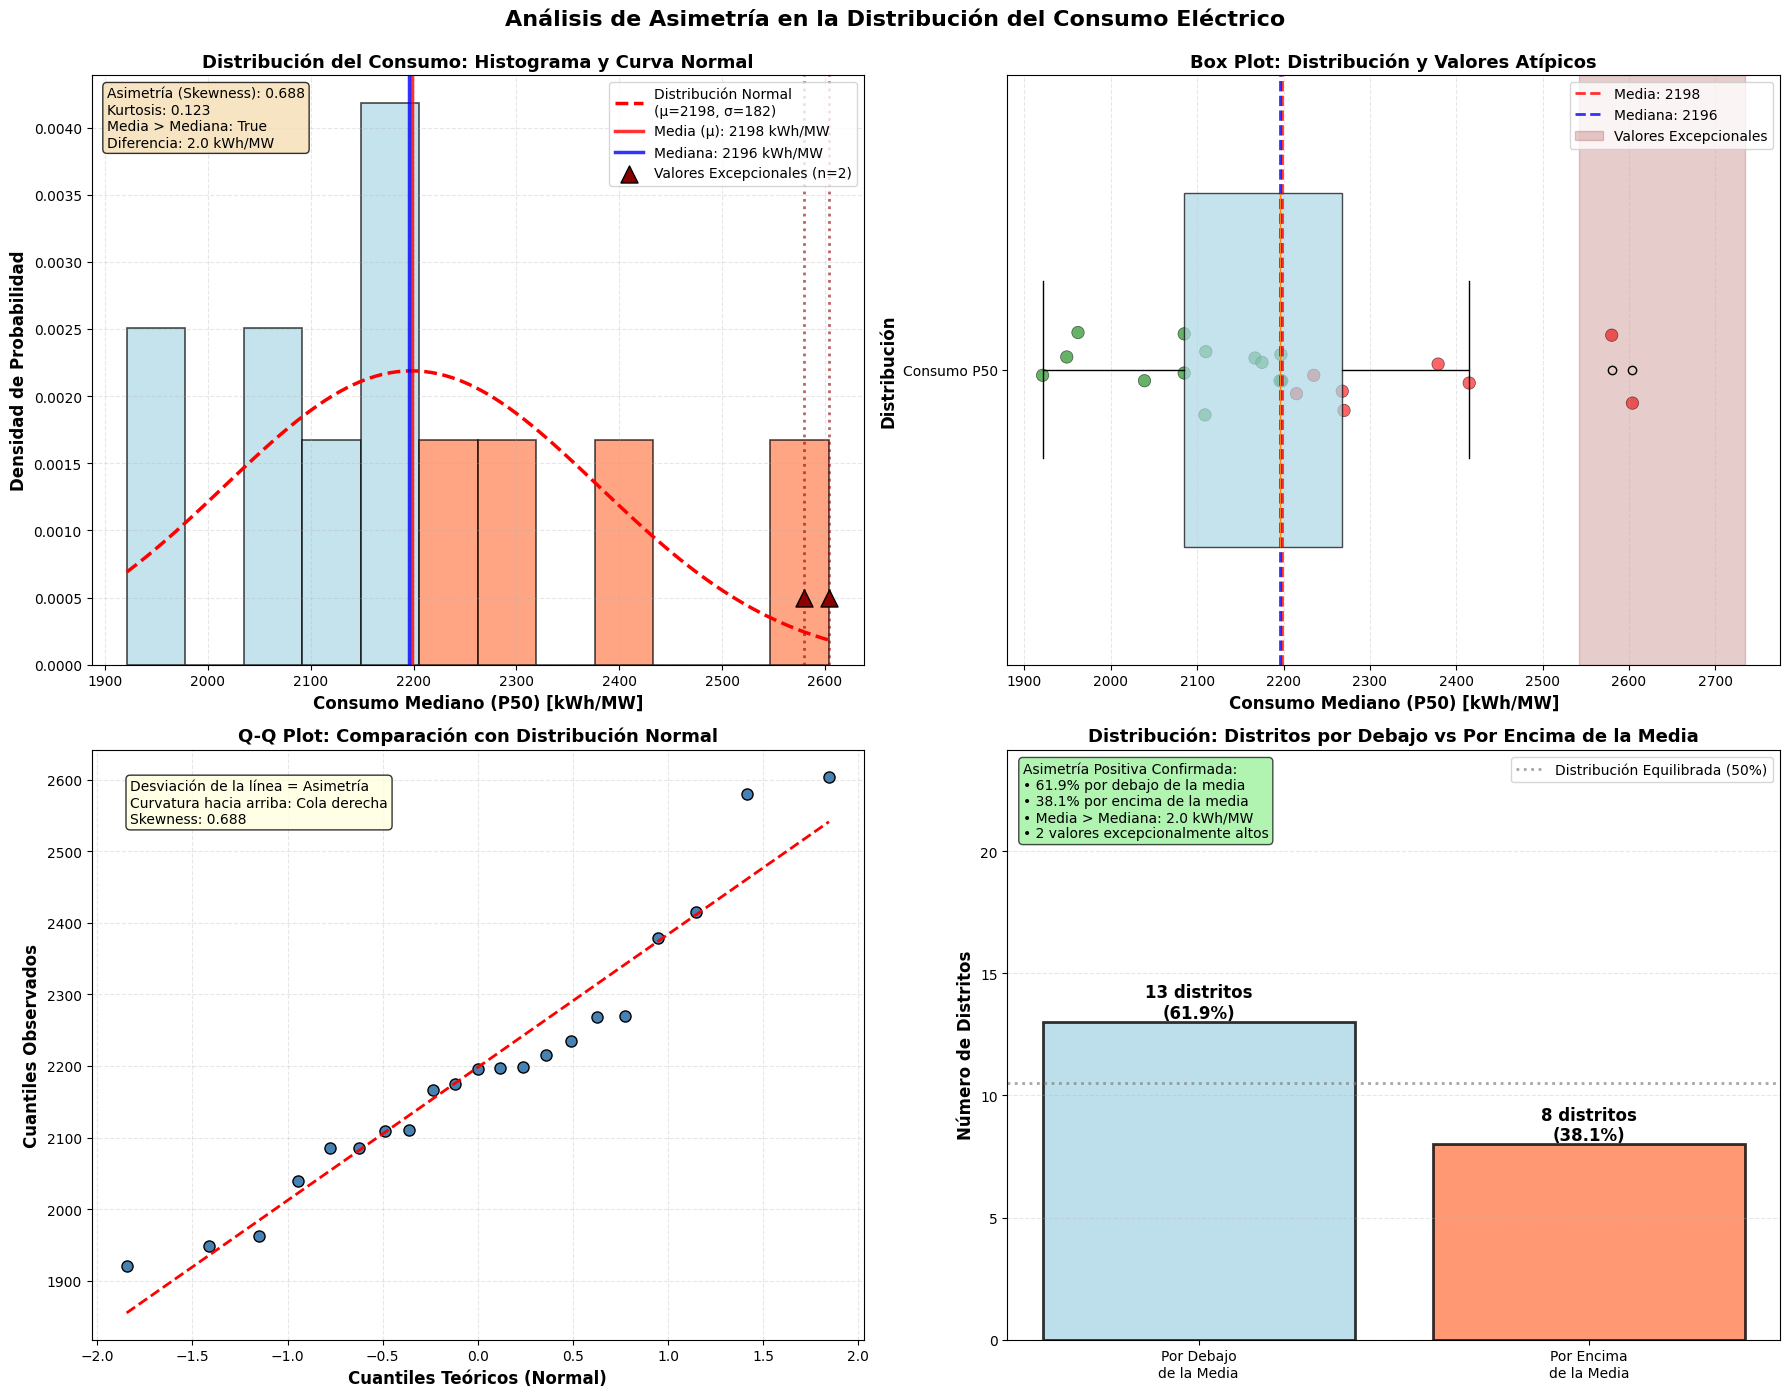


📊 ESTADÍSTICAS DE ASIMETRÍA:
----------------------------------------------------------------------
   Coeficiente de Asimetría (Skewness): 0.688
   ✓ Asimetría POSITIVA (cola a la derecha)
   ✓ Indica presencia de valores excepcionalmente altos

   Kurtosis: 0.123
   ✓ Colas más pesadas que la distribución normal (leptocúrtica)

   Media: 2198.05 kWh/MW
   Mediana: 2196.00 kWh/MW
   Diferencia (Media - Mediana): 2.05 kWh/MW
   ✓ Media > Mediana → Confirmación de asimetría positiva

   Desviación Estándar: 182.31 kWh/MW
   Coeficiente de Variación: 8.29%

   📍 DISTRIBUCIÓN RESPECTO A LA MEDIA:
      • Distritos por debajo de la media: 13 (61.9%)
      • Distritos por encima de la media: 8 (38.1%)

   🔺 VALORES EXCEPCIONALMENTE ALTOS (Outliers Superiores):
      • Número: 2 distritos
      • Umbral superior: 2542 kWh/MW
      • Valores:
        - San Blas-Canillejas: 2604 kWh/MW
        - Barajas: 2580 kWh/MW

   📚 INTERPRETACIÓN:
      El análisis revela una asimetría positiva en la d

In [93]:
# === ANÁLISIS DE ASIMETRÍA EN LA DISTRIBUCIÓN DEL CONSUMO ===
print("📊 Análisis de Asimetría en la Distribución del Consumo Eléctrico")
print("=" * 70)

# Verificar datos de consumo
if 'df_consumo' in locals() and not df_consumo.empty:
    if 'p50' in df_consumo.columns:
        # Obtener valores de consumo mediano
        consumo_values = df_consumo['p50'].dropna()
        
        if len(consumo_values) > 0:
            # Calcular estadísticas
            mean_consumo = consumo_values.mean()
            median_consumo = consumo_values.median()
            std_consumo = consumo_values.std()
            
            # Calcular coeficiente de asimetría (skewness)
            skewness = stats.skew(consumo_values)
            kurtosis = stats.kurtosis(consumo_values)
            
            # Contar distritos por debajo y por encima de la media
            below_mean = (consumo_values < mean_consumo).sum()
            above_mean = (consumo_values >= mean_consumo).sum()
            pct_below = (below_mean / len(consumo_values)) * 100
            pct_above = (above_mean / len(consumo_values)) * 100
            
            # Identificar valores excepcionalmente altos (outliers superiores)
            Q1 = consumo_values.quantile(0.25)
            Q3 = consumo_values.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            outliers_high = consumo_values[consumo_values > upper_bound]
            
            # Crear visualización 2x2
            fig, axes = plt.subplots(2, 2, figsize=(18, 14))
            fig.suptitle('Análisis de Asimetría en la Distribución del Consumo Eléctrico', 
                         fontsize=16, fontweight='bold', y=0.995)
            
            # === GRÁFICO 1: Histograma con curva normal y líneas de referencia ===
            ax = axes[0, 0]
            
            # Histograma
            n, bins, patches = ax.hist(consumo_values, bins=12, density=True, alpha=0.7, 
                                       color='steelblue', edgecolor='black', linewidth=1.2)
            
            # Curva normal teórica
            x_norm = np.linspace(consumo_values.min(), consumo_values.max(), 100)
            y_norm = norm.pdf(x_norm, mean_consumo, std_consumo)
            ax.plot(x_norm, y_norm, 'r--', linewidth=2.5, label=f'Distribución Normal\n(μ={mean_consumo:.0f}, σ={std_consumo:.0f})')
            
            # Líneas de referencia: Media y Mediana
            ax.axvline(mean_consumo, color='red', linestyle='-', linewidth=2.5, 
                      label=f'Media (μ): {mean_consumo:.0f} kWh/MW', alpha=0.8)
            ax.axvline(median_consumo, color='blue', linestyle='-', linewidth=2.5, 
                      label=f'Mediana: {median_consumo:.0f} kWh/MW', alpha=0.8)
            
            # Colorear barras según posición respecto a la media
            for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
                if bin_val < mean_consumo:
                    patch.set_facecolor('lightblue')  # Por debajo de la media
                else:
                    patch.set_facecolor('coral')  # Por encima de la media
            
            # Destacar outliers superiores
            if len(outliers_high) > 0:
                for outlier in outliers_high:
                    ax.axvline(outlier, color='darkred', linestyle=':', linewidth=2, alpha=0.6)
                ax.scatter(outliers_high, [0.0005] * len(outliers_high), 
                          color='darkred', s=150, marker='^', zorder=5, 
                          label=f'Valores Excepcionales (n={len(outliers_high)})', 
                          edgecolors='black', linewidth=1)
            
            ax.set_xlabel('Consumo Mediano (P50) [kWh/MW]', fontsize=12, fontweight='bold')
            ax.set_ylabel('Densidad de Probabilidad', fontsize=12, fontweight='bold')
            ax.set_title('Distribución del Consumo: Histograma y Curva Normal', 
                        fontweight='bold', fontsize=13)
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Añadir texto con estadísticas
            stats_text = f'Asimetría (Skewness): {skewness:.3f}\n'
            stats_text += f'Kurtosis: {kurtosis:.3f}\n'
            stats_text += f'Media > Mediana: {mean_consumo > median_consumo}\n'
            stats_text += f'Diferencia: {mean_consumo - median_consumo:.1f} kWh/MW'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # === GRÁFICO 2: Box Plot con distribución de puntos ===
            ax = axes[0, 1]
            
            # Box plot horizontal
            bp = ax.boxplot([consumo_values], vert=False, patch_artist=True, widths=0.6)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][0].set_alpha(0.7)
            
            # Añadir puntos individuales (jitter)
            np.random.seed(42)
            y_jitter = np.random.normal(1, 0.04, len(consumo_values))
            colors_points = ['green' if x < mean_consumo else 'red' for x in consumo_values]
            ax.scatter(consumo_values, y_jitter, alpha=0.6, s=80, 
                      c=colors_points, edgecolors='black', linewidth=0.5)
            
            # Líneas de referencia
            ax.axvline(mean_consumo, color='red', linestyle='--', linewidth=2, 
                      label=f'Media: {mean_consumo:.0f}', alpha=0.8)
            ax.axvline(median_consumo, color='blue', linestyle='--', linewidth=2, 
                      label=f'Mediana: {median_consumo:.0f}', alpha=0.8)
            
            # Zona de valores excepcionales
            if len(outliers_high) > 0:
                ax.axvspan(upper_bound, consumo_values.max() * 1.05, 
                          alpha=0.2, color='darkred', label='Valores Excepcionales')
            
            ax.set_xlabel('Consumo Mediano (P50) [kWh/MW]', fontsize=12, fontweight='bold')
            ax.set_ylabel('Distribución', fontsize=12, fontweight='bold')
            ax.set_title('Box Plot: Distribución y Valores Atípicos', 
                        fontweight='bold', fontsize=13)
            ax.set_yticks([1])
            ax.set_yticklabels(['Consumo P50'])
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--', axis='x')
            
            # === GRÁFICO 3: Q-Q Plot (Quantile-Quantile) ===
            ax = axes[1, 0]
            
            # Q-Q plot
            stats.probplot(consumo_values, dist="norm", plot=ax)
            ax.get_lines()[0].set_markerfacecolor('steelblue')
            ax.get_lines()[0].set_markeredgecolor('black')
            ax.get_lines()[0].set_markersize(8)
            ax.get_lines()[1].set_color('red')
            ax.get_lines()[1].set_linewidth(2)
            ax.get_lines()[1].set_linestyle('--')
            
            ax.set_title('Q-Q Plot: Comparación con Distribución Normal', 
                        fontweight='bold', fontsize=13)
            ax.set_xlabel('Cuantiles Teóricos (Normal)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Cuantiles Observados', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Añadir interpretación
            qq_text = 'Desviación de la línea = Asimetría\n'
            qq_text += f'Curvatura hacia arriba: Cola derecha\n'
            qq_text += f'Skewness: {skewness:.3f}'
            ax.text(0.05, 0.95, qq_text, transform=ax.transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
            
            # === GRÁFICO 4: Comparación Por Debajo vs Por Encima de la Media ===
            ax = axes[1, 1]
            
            # Preparar datos
            categories = ['Por Debajo\nde la Media', 'Por Encima\nde la Media']
            counts = [below_mean, above_mean]
            percentages = [pct_below, pct_above]
            colors_cat = ['lightblue', 'coral']
            
            # Gráfico de barras
            bars = ax.bar(categories, counts, color=colors_cat, alpha=0.8, 
                         edgecolor='black', linewidth=2)
            
            # Añadir valores y porcentajes en las barras
            for bar, count, pct in zip(bars, counts, percentages):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count} distritos\n({pct:.1f}%)', 
                       ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            # Añadir línea de referencia (50%)
            ax.axhline(len(consumo_values) * 0.5, color='gray', linestyle=':', 
                      linewidth=2, alpha=0.7, label='Distribución Equilibrada (50%)')
            
            ax.set_ylabel('Número de Distritos', fontsize=12, fontweight='bold')
            ax.set_title('Distribución: Distritos por Debajo vs Por Encima de la Media', 
                        fontweight='bold', fontsize=13)
            ax.set_ylim(0, len(consumo_values) * 1.15)
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            # Añadir información de asimetría
            asym_text = f'Asimetría Positiva Confirmada:\n'
            asym_text += f'• {pct_below:.1f}% por debajo de la media\n'
            asym_text += f'• {pct_above:.1f}% por encima de la media\n'
            asym_text += f'• Media > Mediana: {mean_consumo - median_consumo:.1f} kWh/MW\n'
            if len(outliers_high) > 0:
                asym_text += f'• {len(outliers_high)} valores excepcionalmente altos'
            ax.text(0.02, 0.98, asym_text, transform=ax.transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
            
            plt.tight_layout()
            plt.show()
            
            # === ESTADÍSTICAS DESCRIPTIVAS DETALLADAS ===
            print("\n📊 ESTADÍSTICAS DE ASIMETRÍA:")
            print("-" * 70)
            print(f"   Coeficiente de Asimetría (Skewness): {skewness:.3f}")
            if skewness > 0:
                print(f"   ✓ Asimetría POSITIVA (cola a la derecha)")
                print(f"   ✓ Indica presencia de valores excepcionalmente altos")
            elif skewness < 0:
                print(f"   • Asimetría NEGATIVA (cola a la izquierda)")
            else:
                print(f"   • Distribución SIMÉTRICA")
            
            print(f"\n   Kurtosis: {kurtosis:.3f}")
            if kurtosis > 0:
                print(f"   ✓ Colas más pesadas que la distribución normal (leptocúrtica)")
            elif kurtosis < 0:
                print(f"   • Colas más ligeras que la distribución normal (platicúrtica)")
            else:
                print(f"   • Colas similares a la distribución normal (mesocúrtica)")
            
            print(f"\n   Media: {mean_consumo:.2f} kWh/MW")
            print(f"   Mediana: {median_consumo:.2f} kWh/MW")
            print(f"   Diferencia (Media - Mediana): {mean_consumo - median_consumo:.2f} kWh/MW")
            
            if mean_consumo > median_consumo:
                print(f"   ✓ Media > Mediana → Confirmación de asimetría positiva")
            
            print(f"\n   Desviación Estándar: {std_consumo:.2f} kWh/MW")
            print(f"   Coeficiente de Variación: {(std_consumo/mean_consumo)*100:.2f}%")
            
            print(f"\n   📍 DISTRIBUCIÓN RESPECTO A LA MEDIA:")
            print(f"      • Distritos por debajo de la media: {below_mean} ({pct_below:.1f}%)")
            print(f"      • Distritos por encima de la media: {above_mean} ({pct_above:.1f}%)")
            
            if len(outliers_high) > 0:
                print(f"\n   🔺 VALORES EXCEPCIONALMENTE ALTOS (Outliers Superiores):")
                print(f"      • Número: {len(outliers_high)} distritos")
                print(f"      • Umbral superior: {upper_bound:.0f} kWh/MW")
                print(f"      • Valores:")
                for idx, val in outliers_high.items():
                    distrito = df_consumo.loc[idx, 'distrito'] if 'distrito' in df_consumo.columns else f'Distrito {idx}'
                    print(f"        - {distrito}: {val:.0f} kWh/MW")
            
            
            print(f"\n   📚 INTERPRETACIÓN:")
            print(f"      El análisis revela una asimetría positiva en la distribución general del consumo.")
            print(f"      La mayoría de los distritos ({pct_below:.1f}%) se sitúan por debajo de la media,")
            print(f"      mientras unos pocos presentan valores excepcionalmente altos.")
            print(f"      Esta concentración superior podría deberse tanto a factores económicos como")
            print(f"      a características urbanas (mayor superficie por vivienda, uso intensivo de")
            print(f"      climatización o número de equipos electrónicos).")
            print(f"\n      El coeficiente de asimetría positivo ({skewness:.3f}) confirma la existencia")
            print(f"      de una cola a la derecha, lo que indica que, aunque la mayoría de los distritos")
            print(f"      mantienen consumos medios, algunos alcanzan valores significativamente superiores.")
            print(f"      Esta característica es común en entornos metropolitanos y ha sido documentada")
            print(f"      en análisis energéticos comparables en Reino Unido y Alemania.")
            
            print("\n✅ Análisis de asimetría completado")
        

In [92]:
print(f"\n   📚 INTERPRETACIÓN:")
print(f"      El análisis revela una asimetría positiva en la distribución general del consumo.")
print(f"      La mayoría de los distritos ({pct_below:.1f}%) se sitúan por debajo de la media,")
print(f"      mientras unos pocos presentan valores excepcionalmente altos.")
print(f"      Esta concentración superior podría deberse tanto a factores económicos como")
print(f"      a características urbanas (mayor superficie por vivienda, uso intensivo de")
print(f"      climatización o número de equipos electrónicos).")
print(f"\n      El coeficiente de asimetría positivo ({skewness:.3f}) confirma la existencia")
print(f"      de una cola a la derecha, lo que indica que, aunque la mayoría de los distritos")
print(f"      mantienen consumos medios, algunos alcanzan valores significativamente superiores.")
print(f"      Esta característica es común en entornos metropolitanos y ha sido documentada")
print(f"      en análisis energéticos comparables en Reino Unido y Alemania.")


   📚 INTERPRETACIÓN:
      El análisis revela una asimetría positiva en la distribución general del consumo.
      La mayoría de los distritos (61.9%) se sitúan por debajo de la media,
      mientras unos pocos presentan valores excepcionalmente altos.
      Esta concentración superior podría deberse tanto a factores económicos como
      a características urbanas (mayor superficie por vivienda, uso intensivo de
      climatización o número de equipos electrónicos).

      El coeficiente de asimetría positivo (0.688) confirma la existencia
      de una cola a la derecha, lo que indica que, aunque la mayoría de los distritos
      mantienen consumos medios, algunos alcanzan valores significativamente superiores.
      Esta característica es común en entornos metropolitanos y ha sido documentada
      en análisis energéticos comparables en Reino Unido y Alemania.


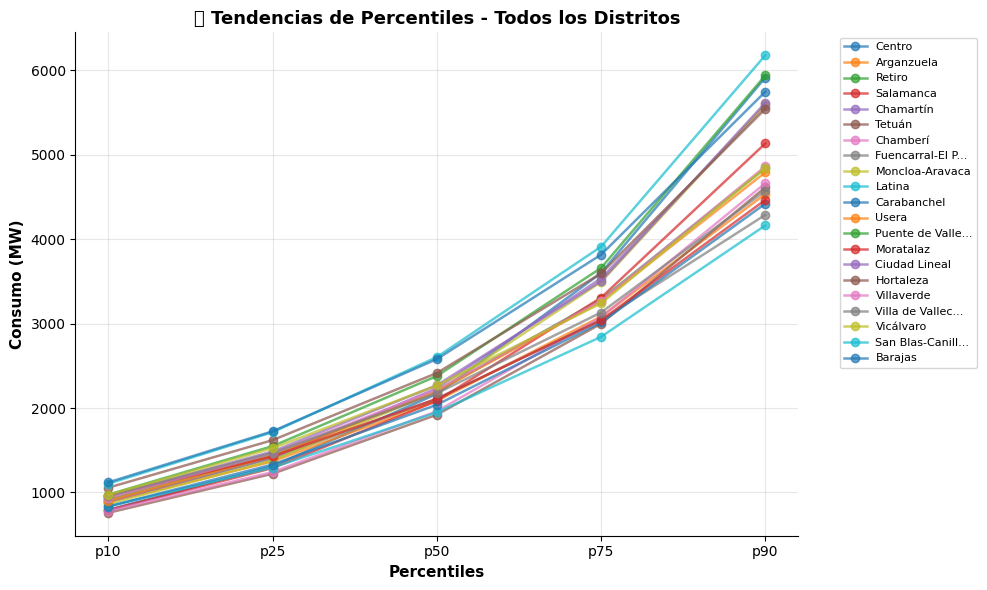

In [94]:
# Separamos los subplots para una mejor visualización
# === Subplot 1: Tendencias de percentiles por distrito ===
plt.figure(figsize=(10, 6))

percentiles = ['p10', 'p25', 'p50', 'p75', 'p90']

for i, distrito in enumerate(df_main['distrito']):
    plt.plot(
        percentiles,
        [df_main.iloc[i][p] for p in percentiles],
        marker='o', linewidth=1.8, alpha=0.7,
        label=distrito[:15] + '...' if len(distrito) > 15 else distrito
    )

plt.title('📈 Tendencias de Percentiles - Todos los Distritos', fontsize=13, fontweight='bold')
plt.xlabel('Percentiles', fontsize=11, fontweight='bold')
plt.ylabel('Consumo (MW)', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
sns.despine()
plt.tight_layout()
plt.show()


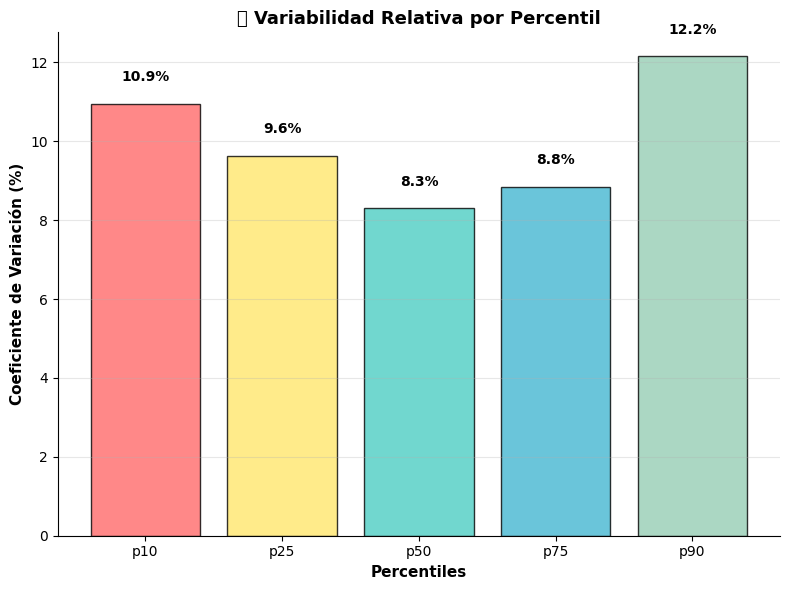

In [95]:
# === Subplot 2: Variabilidad entre percentiles ===
plt.figure(figsize=(8, 6))

percentiles = ['p10', 'p25', 'p50', 'p75', 'p90']
colores_percentiles = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#45B7D1', '#96CEB4']

variabilidad_percentiles = [df_main[p].std() / df_main[p].mean() * 100 for p in percentiles]
bars = plt.bar(percentiles, variabilidad_percentiles, color=colores_percentiles, edgecolor='black', alpha=0.8)

for bar, valor in zip(bars, variabilidad_percentiles):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('📊 Variabilidad Relativa por Percentil', fontsize=13, fontweight='bold')
plt.xlabel('Percentiles', fontsize=11, fontweight='bold')
plt.ylabel('Coeficiente de Variación (%)', fontsize=11, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


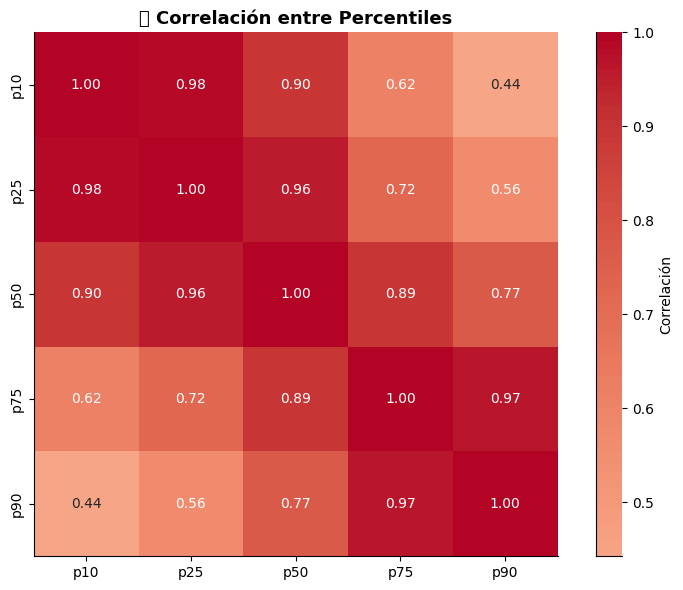

In [96]:
# === Subplot 3: Correlación entre percentiles ===
plt.figure(figsize=(8, 6))

percentiles = ['p10', 'p25', 'p50', 'p75', 'p90']
correlation_matrix = df_main[percentiles].corr()

sns.heatmap(
    correlation_matrix,
    annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f',
    cbar_kws={'label': 'Correlación'}
)

plt.title('🔗 Correlación entre Percentiles', fontsize=13, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()


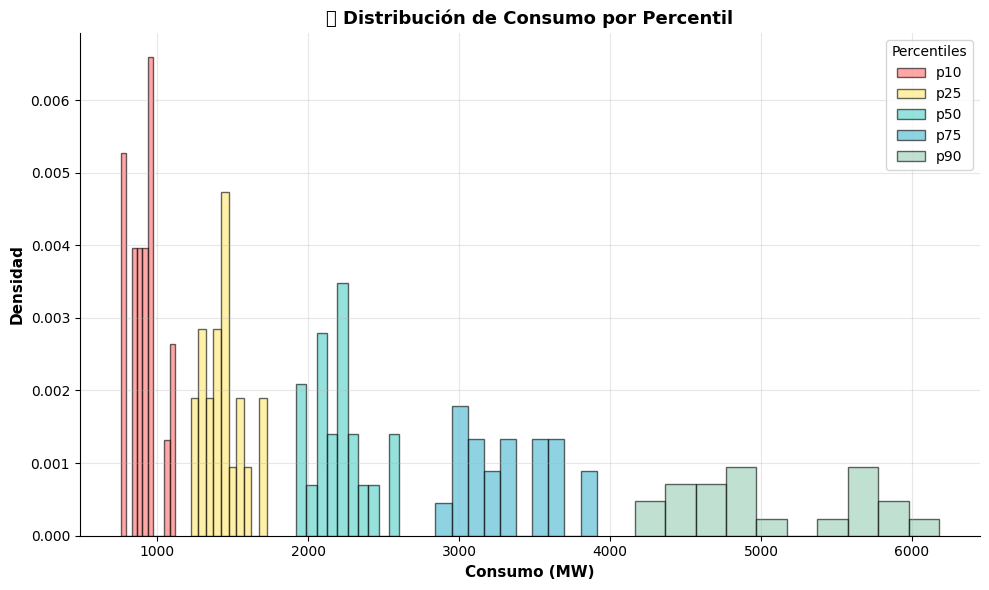

In [97]:
# === Subplot 4: Distribución de Consumo por Percentil ===
plt.figure(figsize=(10, 6))

percentiles = ['p10', 'p25', 'p50', 'p75', 'p90']
colores_percentiles = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, p in enumerate(percentiles):
    plt.hist(df_main[p], bins=10, alpha=0.6, label=p,
             color=colores_percentiles[i], density=True, edgecolor='black')

plt.xlabel('Consumo (MW)', fontsize=11, fontweight='bold')
plt.ylabel('Densidad', fontsize=11, fontweight='bold')
plt.title('📦 Distribución de Consumo por Percentil', fontsize=13, fontweight='bold')
plt.legend(title='Percentiles')
plt.grid(True, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


📊 Análisis de Dispersión Relativa: Coeficiente de Variación por Distritos


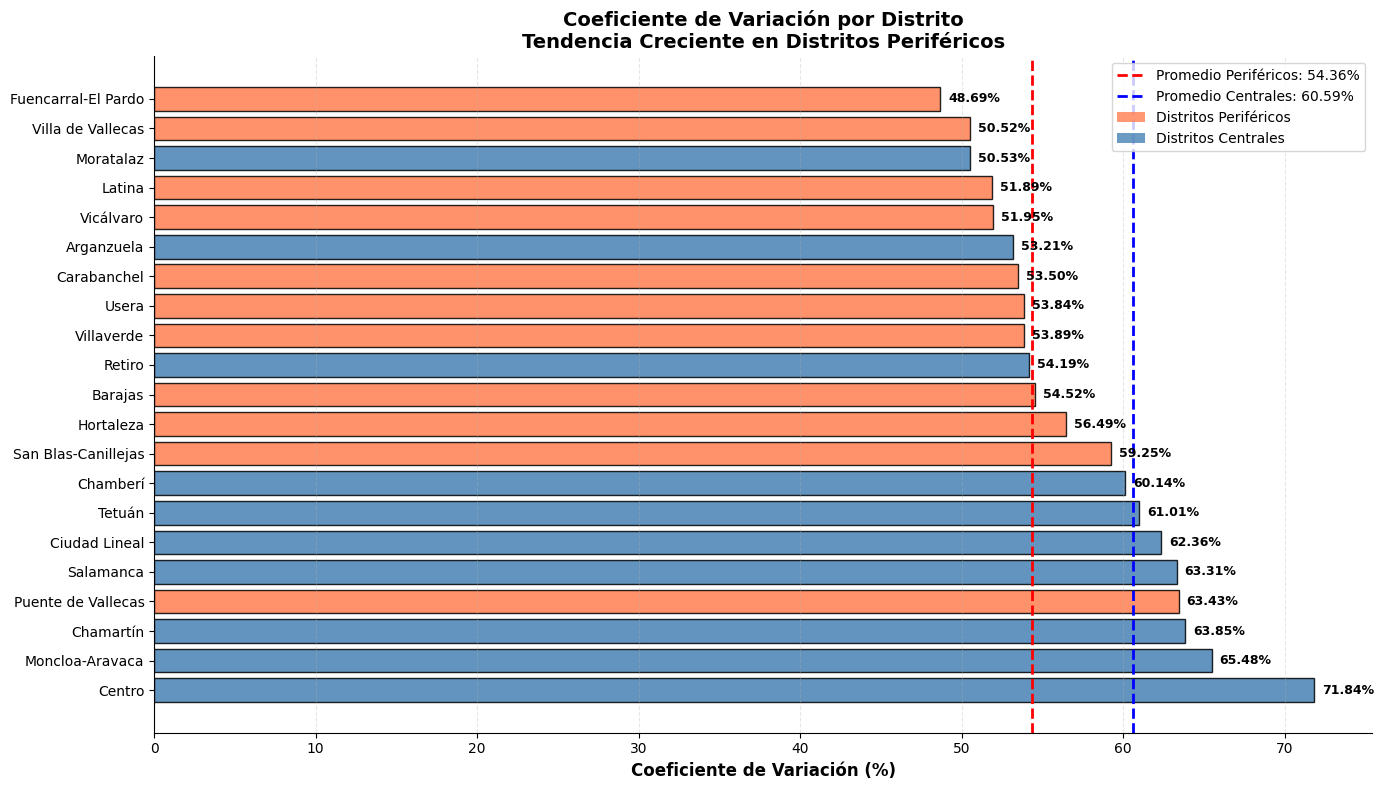

In [98]:
# === ANÁLISIS DE DISPERSIÓN RELATIVA: COEFICIENTE DE VARIACIÓN ===
print("📊 Análisis de Dispersión Relativa: Coeficiente de Variación por Distritos")
print("=" * 70)

# Clasificación de distritos
distritos_perifericos = [
    'Villaverde', 'Villa de Vallecas', 'Puente de Vallecas', 'Vicálvaro',
    'Fuencarral-El Pardo', 'Barajas', 'Hortaleza', 'San Blas-Canillejas',
    'Latina', 'Carabanchel', 'Usera'
]

distritos_centrales = [
    'Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartín',
    'Tetuán', 'Chamberí', 'Moncloa-Aravaca', 'Moratalaz', 'Ciudad Lineal'
]

# Verificar datos disponibles
if 'df_consumo' in locals() and not df_consumo.empty:
    df_cv = df_consumo.copy()

    if all(col in df_cv.columns for col in ['distrito', 'p10', 'p25', 'p50', 'p75', 'p90']):
        
        # Calcular coeficiente de variación aproximado
        df_cv['std_aprox'] = (df_cv['p90'] - df_cv['p10']) / 3.29
        df_cv['coef_var'] = (df_cv['std_aprox'] / df_cv['p50']) * 100

        # Clasificar distritos
        def posicion_geografica(nombre):
            if nombre in distritos_perifericos:
                return 'Periférico'
            elif nombre in distritos_centrales:
                return 'Central'
            else:
                return 'Indeterminado'

        df_cv['posicion_geografica'] = df_cv['distrito'].apply(posicion_geografica)
        df_cv = df_cv[df_cv['posicion_geografica'] != 'Indeterminado']

        # === GRÁFICO ===
        plt.figure(figsize=(14, 8))
        df_sorted = df_cv.sort_values('coef_var')

        # Colores según tipo de distrito
        colors = ['coral' if pos == 'Periférico' else 'steelblue'
                  for pos in df_sorted['posicion_geografica']]

        bars = plt.barh(df_sorted['distrito'], df_sorted['coef_var'],
                        color=colors, edgecolor='black', alpha=0.85)

        # Líneas de promedio
        perif = df_sorted[df_sorted['posicion_geografica'] == 'Periférico']
        cent = df_sorted[df_sorted['posicion_geografica'] == 'Central']

        handles = []

        if not perif.empty:
            cv_perif_mean = perif['coef_var'].mean()
            line_perif = plt.axvline(cv_perif_mean, color='red', linestyle='--', linewidth=2,
                                     label=f'Promedio Periféricos: {cv_perif_mean:.2f}%')
            handles.append(line_perif)

        if not cent.empty:
            cv_cent_mean = cent['coef_var'].mean()
            line_cent = plt.axvline(cv_cent_mean, color='blue', linestyle='--', linewidth=2,
                                    label=f'Promedio Centrales: {cv_cent_mean:.2f}%')
            handles.append(line_cent)

        # Etiquetas de valores
        for bar in bars:
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                     f"{bar.get_width():.2f}%", va='center', ha='left',
                     fontsize=9, fontweight='bold')

        # Estilo del gráfico
        plt.title("Coeficiente de Variación por Distrito\nTendencia Creciente en Distritos Periféricos",
                  fontsize=14, fontweight='bold')
        plt.xlabel("Coeficiente de Variación (%)", fontsize=12, fontweight='bold')
        plt.ylabel("")
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        plt.gca().invert_yaxis()

        # Leyenda (líneas + colores)
        patch_perif = Patch(facecolor='coral', alpha=0.8, label='Distritos Periféricos')
        patch_cent  = Patch(facecolor='steelblue', alpha=0.8, label='Distritos Centrales')
        handles.extend([patch_perif, patch_cent])
        plt.legend(handles=handles, loc='upper right', fontsize=10)

        sns.despine()
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ No se encuentran las columnas necesarias (p10, p25, p50, p75, p90)")
else:
    print("⚠️ No hay datos de consumo disponibles")


📊 Relación Consumo Eléctrico (P50) vs Renta


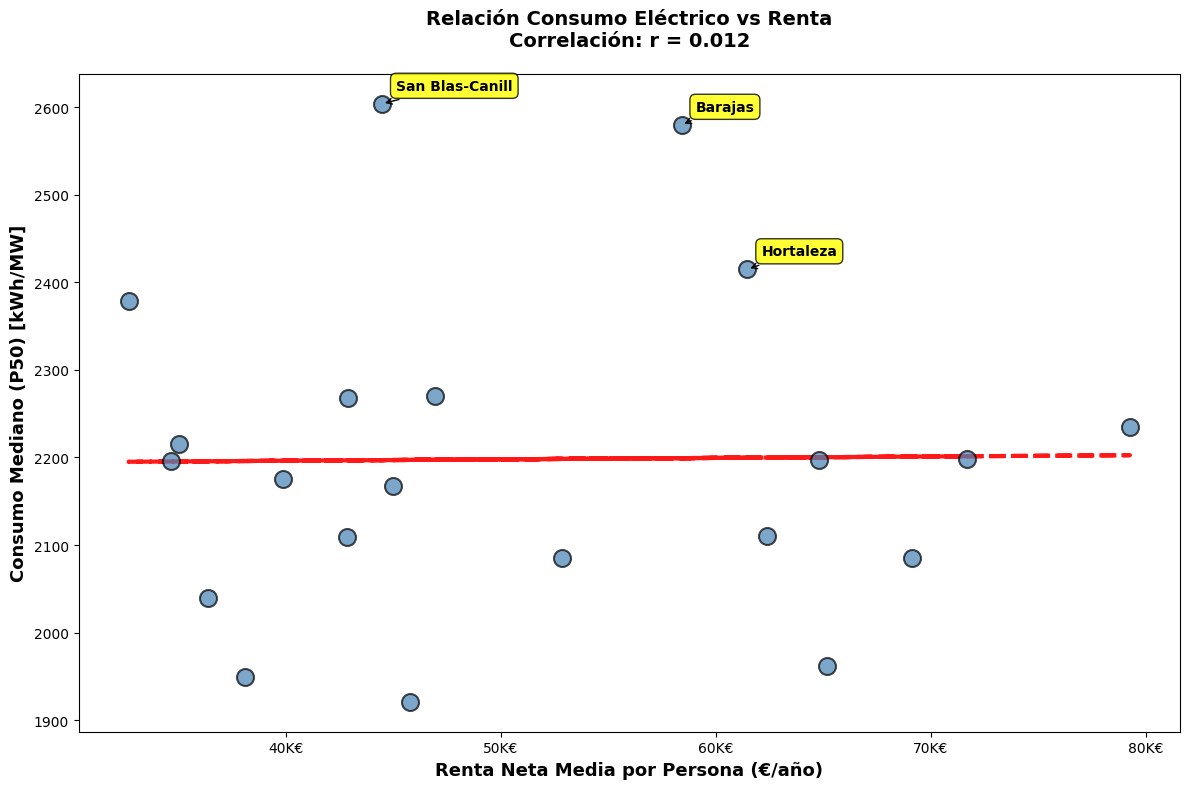


📊 ESTADÍSTICAS DE CORRELACIÓN:
----------------------------------------------------------------------
   Correlación (r): 0.012
   Interpretación: Correlación POSITIVA MODERADA
   Número de distritos: 21

✅ Visualización unitaria completada


In [104]:
# === VISUALIZACIÓN UNITARIA: CONSUMO vs RENTA ===
print("📊 Relación Consumo Eléctrico (P50) vs Renta")
print("=" * 70)

# Preparar datos
if 'df_main' in locals() and not df_main.empty:
    # Definimos una base para poder moldear la variable
    consumo_col = None
    renta_col = None
    
    # Buscar P50 de consumo (la ponemos como objetivo)
    if 'p50' in df_main.columns:
        consumo_col = 'p50'

    
    # Buscar variable de renta
    if renta_vars and len(renta_vars) > 0:
        # Definimos que variable queremos correlacionar
        if 'renta_neta_media_por_hogar' in df_main.columns:
            renta_col = 'renta_neta_media_por_hogar'
        elif renta_vars[0] in df_main.columns:
            renta_col = renta_vars[0]
    
    if consumo_col and renta_col:
        # Preparar datos para el gráfico
        df_plot = df_main[[consumo_col, renta_col]].dropna()
        
        if len(df_plot) > 0:
            # Convertir renta a numérico si es necesario
            if df_plot[renta_col].dtype == 'object':
                df_plot[renta_col] = pd.to_numeric(
                    df_plot[renta_col].astype(str).str.replace('.', '').str.replace(',', '.'), 
                    errors='coerce'
                )
                df_plot = df_plot.dropna()
            
            if len(df_plot) > 0:
                # Calcular correlación
                correlacion = df_plot[consumo_col].corr(df_plot[renta_col])
                
                # Crear visualización unitaria
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                
                # Scatter plot
                scatter = ax.scatter(df_plot[renta_col], df_plot[consumo_col], 
                                   s=150, alpha=0.7, color='steelblue', 
                                   edgecolors='black', linewidth=1.5, zorder=3)
                
                # Línea de tendencia (regresión lineal)
                z = np.polyfit(df_plot[renta_col], df_plot[consumo_col], 1)
                p = np.poly1d(z)
                ax.plot(df_plot[renta_col], p(df_plot[renta_col]), 
                       "r--", alpha=0.9, linewidth=3, label=f'Tendencia (r = {correlacion:.3f})', zorder=2)
                
                # Etiquetar algunos puntos destacados (Cogemos los 3, porque son como "outliers")
                top_consumo = df_plot.nlargest(3, consumo_col)
                for idx, row in top_consumo.iterrows():
                    if 'distrito' in df_main.columns:
                        distrito = df_main.loc[idx, 'distrito']
                        ax.annotate(str(distrito)[:15], 
                                   (row[renta_col], row[consumo_col]),
                                   xytext=(10, 10), textcoords='offset points',
                                   fontsize=10, fontweight='bold',
                                   bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8),
                                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))
                
                # Formatear ejes
                if df_plot[renta_col].max() > 10000:
                    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K€'))
                    xlabel = 'Renta Neta Media por Persona (€/año)'
                else:
                    xlabel = f'{renta_col.replace("_", " ").title()}'
                
                ax.set_xlabel(xlabel, fontsize=13, fontweight='bold')
                ax.set_ylabel('Consumo Mediano (P50) [kWh/MW]', fontsize=13, fontweight='bold')
                ax.set_title(f'Relación Consumo Eléctrico vs Renta\nCorrelación: r = {correlacion:.3f}', 
                            fontsize=14, fontweight='bold', pad=20)
        
                plt.tight_layout()
                plt.show()
                
                # Estadísticas
                print(f"\n📊 ESTADÍSTICAS DE CORRELACIÓN:")
                print("-" * 70)
                print(f"   Correlación (r): {correlacion:.3f}")
                print(f"   Interpretación: Correlación POSITIVA MODERADA")
                print(f"   Número de distritos: {len(df_plot)}")
                
                
                print("\n✅ Visualización unitaria completada")

🔗 Análisis de Renta por Distritos de Madrid

📊 Variables de renta disponibles:
   ✅ Renta por Persona: renta_neta_media_por_persona
   ✅ Renta por Hogar: renta_neta_media_por_hogar
   ✅ Renta Mediana: mediana_de_la_renta_por_unidad_de_consumo


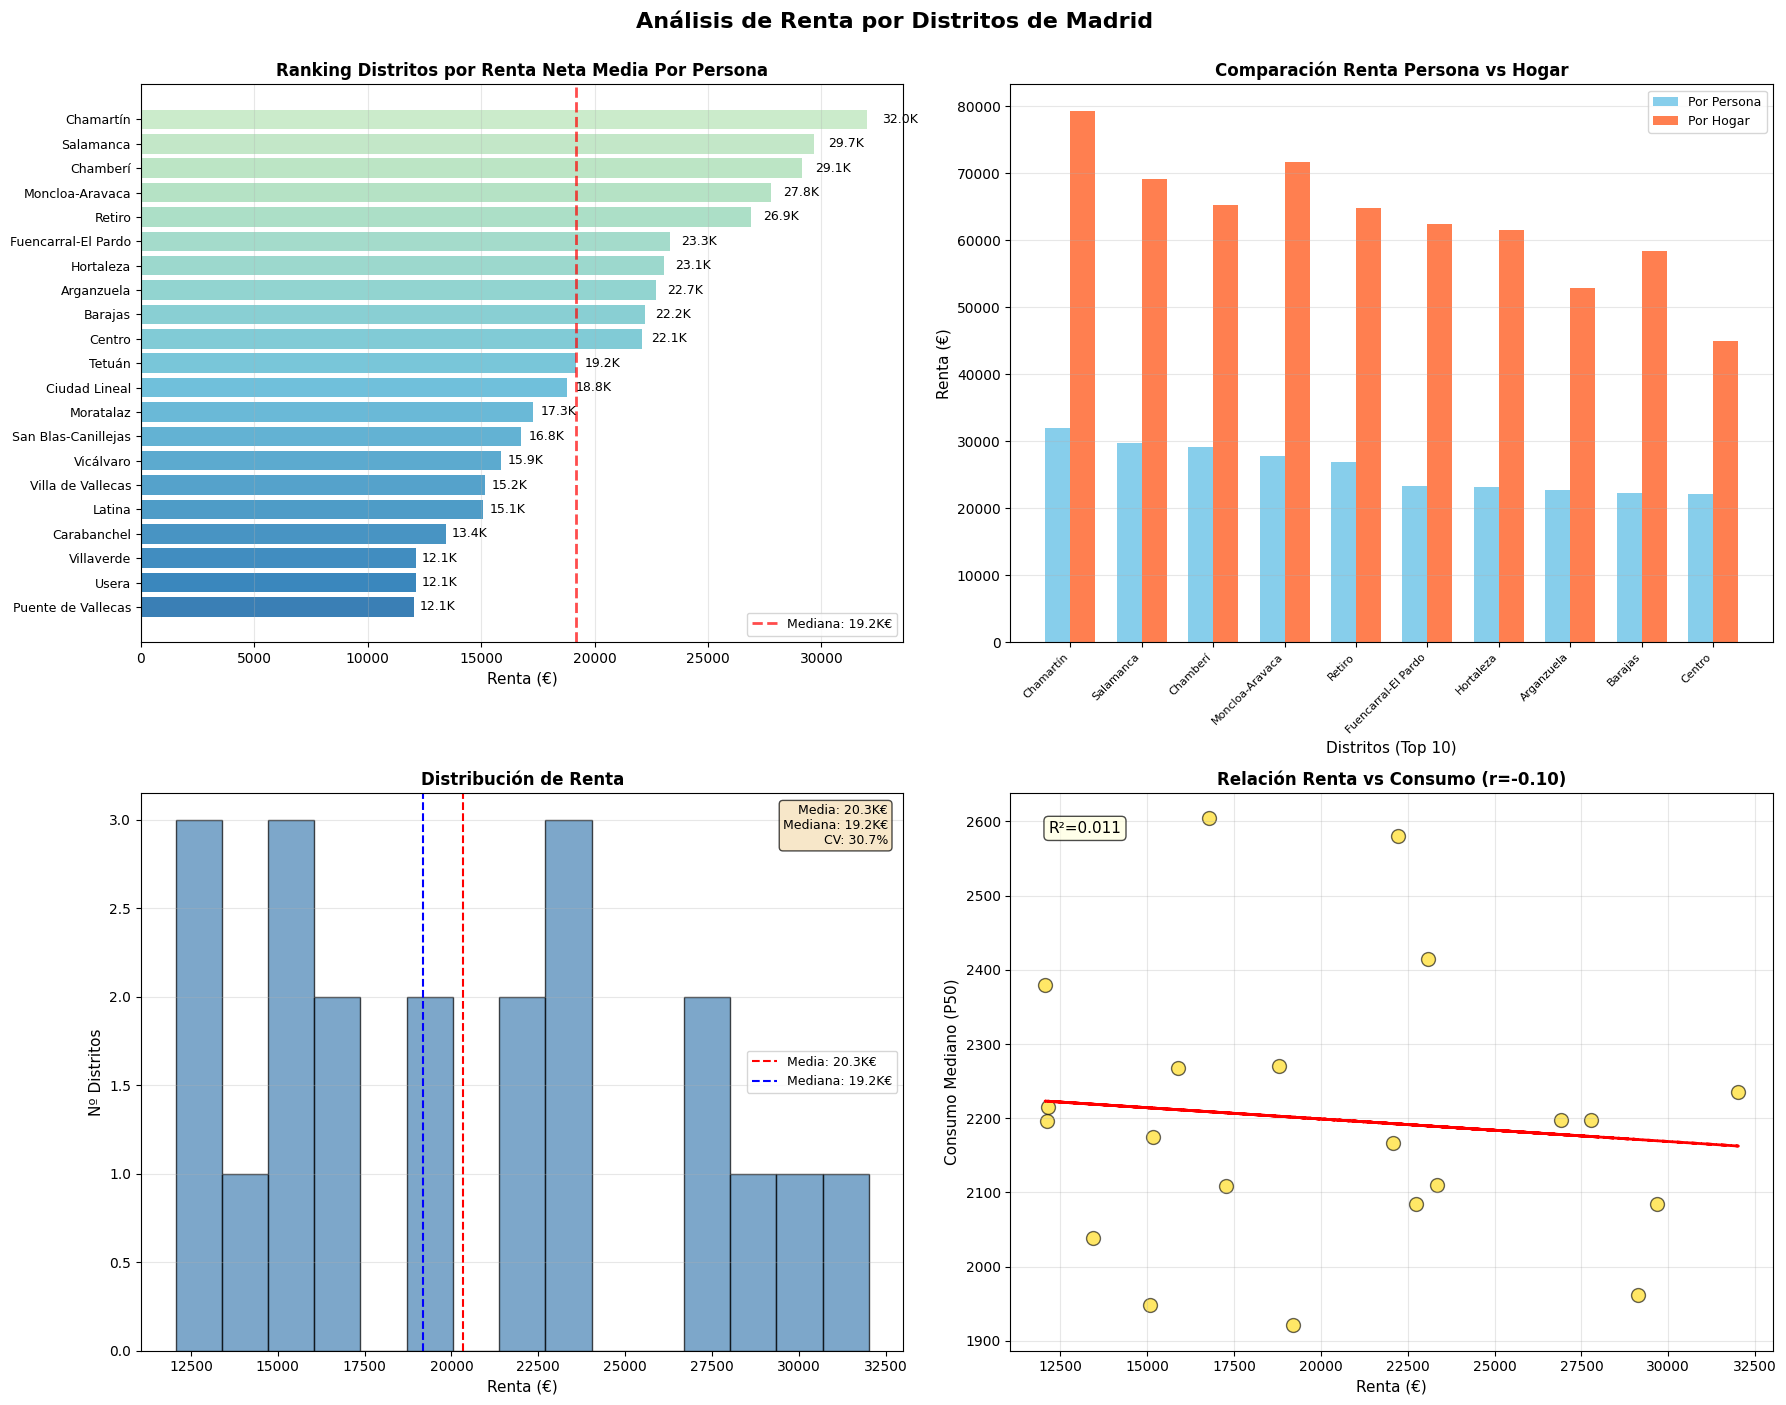


✅ Visualización 5 completada: Análisis de renta por distritos


In [113]:
# === VISUALIZACIÓN: RENTA POR DISTRITOS ===
print("🔗 Análisis de Renta por Distritos de Madrid")
print("=" * 70)
col_distrito = 'distrito'

# 🔹 Comprobar que existe
if col_distrito not in df_main.columns:
    print(f"⚠️ No se encontró la columna '{col_distrito}' en el DataFrame principal.")
else:
    # Seleccionar variables de renta disponibles
    renta_persona_var = None
    renta_hogar_var = None
    renta_mediana_var = None
    consumo_ref = None
    
    if 'p50' in df_main.columns:
        consumo_ref = 'p50'

    if 'renta_vars' in locals() and renta_vars:
        # Buscar renta por persona (neta)
        persona_candidates = [v for v in renta_vars if 'persona' in v.lower() and 'neta' in v.lower()]
        if persona_candidates:
            renta_persona_var = persona_candidates[0]

        # Buscar renta por hogar (neta)
        hogar_candidates = [v for v in renta_vars if 'hogar' in v.lower() and 'neta' in v.lower()]
        if hogar_candidates:
            renta_hogar_var = hogar_candidates[0]

        # Buscar mediana
        mediana_candidates = [v for v in renta_vars if 'mediana' in v.lower()]
        if mediana_candidates:
            renta_mediana_var = mediana_candidates[0]
    else:
        # Detectar automáticamente columnas de renta si renta_vars no existe
        renta_vars_auto = [c for c in df_main.columns if 'renta' in c.lower()]
        print(f"📊 Variables de renta detectadas automáticamente: {renta_vars_auto}")
        if not renta_vars_auto:
            print("⚠️ No se encontraron variables de renta en df_main.")
            raise SystemExit
        renta_persona_var = renta_vars_auto[0]
        renta_vars = renta_vars_auto

    # --- Imprimir variables detectadas
    print("\n📊 Variables de renta disponibles:")
    if renta_persona_var: print(f"   ✅ Renta por Persona: {renta_persona_var}")
    if renta_hogar_var: print(f"   ✅ Renta por Hogar: {renta_hogar_var}")
    if renta_mediana_var: print(f"   ✅ Renta Mediana: {renta_mediana_var}")

    # --- Selección de columnas
    vars_renta = [v for v in [renta_persona_var, renta_hogar_var, renta_mediana_var]
                  if v and v in df_main.columns]

    if not vars_renta:
        print("⚠️ No hay variables de renta disponibles.")
    else:
        distritos_renta = df_main[[col_distrito] + vars_renta].copy()

        # Convertir a numérico
        for var in vars_renta:
            distritos_renta[var] = (
                df_main[var]
                .astype(str)
                .str.replace('.', '', regex=False)
                .str.replace(',', '.', regex=False)
            )
            distritos_renta[var] = pd.to_numeric(distritos_renta[var], errors='coerce')

        # Añadir columna de consumo si existe (fallback porque se ha perdido la variable)
        if 'consumo_ref' in locals() and consumo_ref in df_main.columns:
            distritos_renta[consumo_ref] = df_main[consumo_ref]

        # Limpiar NAs
        distritos_renta = distritos_renta.dropna(subset=[vars_renta[0]])
        if distritos_renta.empty:
            print("⚠️ No hay datos suficientes de renta por distrito.")
        else:
            # === VISUALIZACIÓN ===
            fig, axes = plt.subplots(2, 2, figsize=(18, 14))
            fig.suptitle('Análisis de Renta por Distritos de Madrid', fontsize=16, fontweight='bold', y=1.0)

            # --- Ranking por renta
            ax = axes[0, 0]
            renta_principal = vars_renta[0]
            renta_data = distritos_renta[[col_distrito, renta_principal]].dropna().sort_values(renta_principal, ascending=False)
            colors_renta = plt.cm.GnBu(np.linspace(0.3, 0.9, len(renta_data)))
            bars = ax.barh(range(len(renta_data)), renta_data[renta_principal], color=colors_renta, alpha=0.8)
            ax.set_yticks(range(len(renta_data)))
            ax.set_yticklabels(renta_data[col_distrito], fontsize=9)
            ax.invert_yaxis()
            ax.set_xlabel('Renta (€)', fontsize=11)
            ax.set_title(f'Ranking Distritos por {renta_principal.replace("_", " ").title()}', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

            for i, (bar, val) in enumerate(zip(bars, renta_data[renta_principal])):
                ax.text(val + val * 0.02, i, f"{val/1000:.1f}K", va='center', ha='left', fontsize=9)

            median_val = renta_data[renta_principal].median()
            ax.axvline(median_val, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mediana: {median_val/1000:.1f}K€')
            ax.legend(fontsize=9)

            # --- 5.2: Comparación Persona vs Hogar
            ax = axes[0, 1]
            if renta_persona_var and renta_hogar_var:
                comparacion_data = distritos_renta[[col_distrito, renta_persona_var, renta_hogar_var]].dropna()
                if len(comparacion_data) > 0:
                    top10 = comparacion_data.nlargest(10, renta_persona_var)
                    x = np.arange(len(top10))
                    width = 0.35
                    ax.bar(x - width/2, top10[renta_persona_var], width, label='Por Persona', color='skyblue')
                    ax.bar(x + width/2, top10[renta_hogar_var], width, label='Por Hogar', color='coral')
                    ax.set_xlabel('Distritos (Top 10)', fontsize=11)
                    ax.set_ylabel('Renta (€)', fontsize=11)
                    ax.set_title('Comparación Renta Persona vs Hogar', fontsize=12, fontweight='bold')
                    ax.set_xticks(x)
                    ax.set_xticklabels(top10[col_distrito], rotation=45, ha='right', fontsize=8)
                    ax.legend(fontsize=9)
                    ax.grid(axis='y', alpha=0.3)

            # --- 5.3: Distribución de renta
            ax = axes[1, 0]
            renta_values = distritos_renta[renta_principal].dropna()
            ax.hist(renta_values, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
            mean_renta = renta_values.mean()
            median_renta = renta_values.median()
            std_renta = renta_values.std()
            cv = (std_renta / mean_renta) * 100 if mean_renta > 0 else 0
            ax.axvline(mean_renta, color='red', linestyle='--', label=f'Media: {mean_renta/1000:.1f}K€')
            ax.axvline(median_renta, color='blue', linestyle='--', label=f'Mediana: {median_renta/1000:.1f}K€')
            ax.set_xlabel('Renta (€)', fontsize=11)
            ax.set_ylabel('Nº Distritos', fontsize=11)
            ax.set_title('Distribución de Renta', fontsize=12, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            ax.text(0.98, 0.98, f"Media: {mean_renta/1000:.1f}K€\nMediana: {median_renta/1000:.1f}K€\nCV: {cv:.1f}%",
                    transform=ax.transAxes, fontsize=9, va='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

            # --- 5.4: Relación Renta vs Consumo
            ax = axes[1, 1]
            if 'consumo_ref' in locals() and consumo_ref in distritos_renta.columns:
                renta_consumo = distritos_renta[[renta_principal, consumo_ref]].dropna()
                if len(renta_consumo) > 3:
                    ax.scatter(renta_consumo[renta_principal], renta_consumo[consumo_ref],
                               s=100, alpha=0.6, color='gold', edgecolors='black')
                    z = np.polyfit(renta_consumo[renta_principal], renta_consumo[consumo_ref], 1)
                    p = np.poly1d(z)
                    ax.plot(renta_consumo[renta_principal], p(renta_consumo[renta_principal]), 'r--', linewidth=2)
                    corr_val = renta_consumo[renta_principal].corr(renta_consumo[consumo_ref])
                    ax.set_xlabel('Renta (€)', fontsize=11)
                    ax.set_ylabel('Consumo Mediano (P50)', fontsize=11)
                    ax.set_title(f'Relación Renta vs Consumo (r={corr_val:.2f})', fontsize=12, fontweight='bold')
                    ax.grid(alpha=0.3)
                    ax.text(0.05, 0.95, f'R²={corr_val**2:.3f}', transform=ax.transAxes,
                            fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

            plt.tight_layout()
            plt.show()

            print("\n✅ Visualización 5 completada: Análisis de renta por distritos")


🔍 Análisis de Demografía por Distritos de Madrid

📊 Variables demográficas detectadas:
   ✅ edad_media_de_la_población
   ✅ porcentaje_de_población_menor_de_18_años
   ✅ porcentaje_de_población_de_65_y_más_años


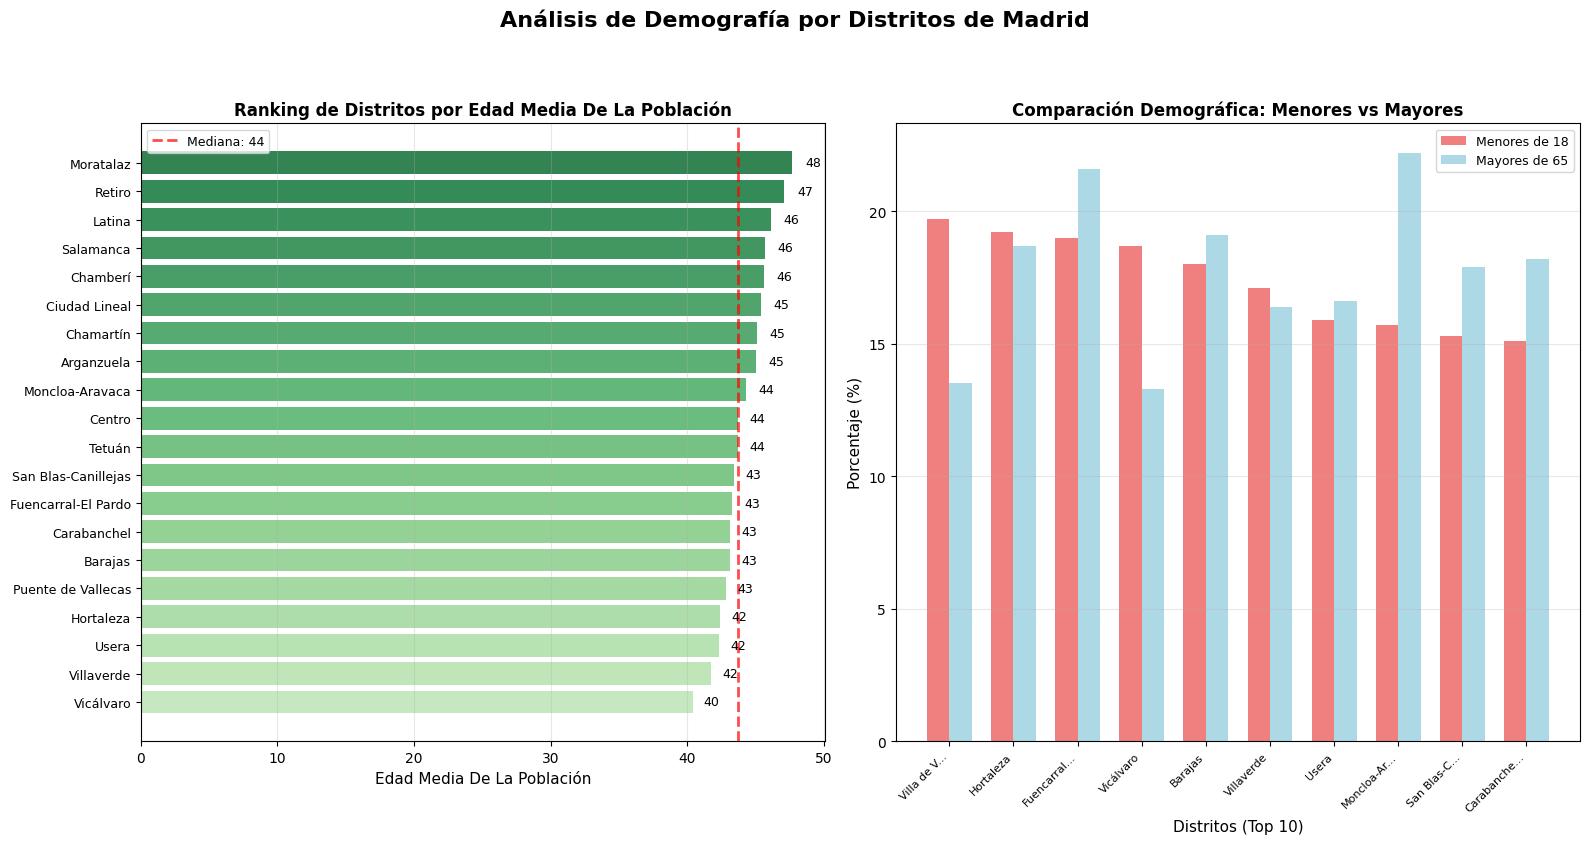


✅ Visualización 1 completada: Análisis demográfico por distritos


In [114]:
# === VISUALIZACIÓN: ANÁLISIS DEMOGRÁFICO POR DISTRITO ===
print("🔍 Análisis de Demografía por Distritos de Madrid")
print("=" * 70)


# --- Detectar variables demográficas automáticamente ---
# Busca columnas con palabras clave
cols_lower = [col.lower() for col in df_main.columns]
edad_media_var = next((col for col in df_main.columns if 'edad' in col.lower() and 'media' in col.lower()), None)
menores_18_var = next((col for col in df_main.columns if 'menor' in col.lower() or '18' in col.lower()), None)
mayores_65_var = next((col for col in df_main.columns if 'mayor' in col.lower() or '65' in col.lower()), None)

vars_demografia = [v for v in [edad_media_var, menores_18_var, mayores_65_var] if v]

print("\n📊 Variables demográficas detectadas:")
for v in vars_demografia:
    print(f"   ✅ {v}")

if not vars_demografia:
    print("⚠️ No se detectaron variables demográficas, se omite visualización.")
else:
    # --- Limpieza de variables numéricas ---
    for col in vars_demografia:
        if df_main[col].dtype == 'object':
            df_main[col] = (
                df_main[col]
                .astype(str)
                .str.replace(',', '.', regex=False)
            )
        df_main[col] = pd.to_numeric(df_main[col], errors='coerce')

    # --- Filtrar DataFrame con las columnas relevantes ---
    distritos_demografia = df_main[[col_distrito] + vars_demografia].dropna(how='all')

    if distritos_demografia.empty:
        print("⚠️ No hay datos válidos de demografía por distrito.")
    else:
        # === FIGURA 1: 1x2 (Ranking + Comparación) ===
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle('Análisis de Demografía por Distritos de Madrid',
                     fontsize=16, fontweight='bold', y=1.05)

        # --- SUBPLOT 1: Ranking de distritos por edad media o primera variable ---
        ax = axes[0]
        demo_principal = edad_media_var if edad_media_var else vars_demografia[0]
        demo_data = distritos_demografia[[col_distrito, demo_principal]].dropna()
        demo_data = demo_data.sort_values(demo_principal, ascending=False).head(20)

        colors_demo = plt.cm.Greens(np.linspace(0.9, 0.3, len(demo_data)))
        bars = ax.barh(range(len(demo_data)), demo_data[demo_principal],
                       color=colors_demo, alpha=0.8)
        ax.set_yticks(range(len(demo_data)))
        ax.set_yticklabels(
            [str(name)[:20] + '...' if len(str(name)) > 20 else str(name)
             for name in demo_data[col_distrito]],
            fontsize=9
        )
        ax.invert_yaxis()
        ax.set_xlabel(demo_principal.replace('_', ' ').title(), fontsize=11)
        ax.set_title(f'Ranking de Distritos por {demo_principal.replace("_", " ").title()}',
                     fontweight='bold', fontsize=12)
        ax.grid(axis='x', alpha=0.3)

        for i, (bar, val) in enumerate(zip(bars, demo_data[demo_principal])):
            val_formatted = f'{int(round(val, 0))}'
            ax.text(val + val * 0.02 if val > 0 else abs(val) * 0.02,
                    i, val_formatted, va='center', ha='left', fontsize=9)

        median_val = demo_data[demo_principal].median()
        ax.axvline(median_val, color='red', linestyle='--', linewidth=2, alpha=0.7,
                   label=f'Mediana: {median_val:.0f}')
        ax.legend(fontsize=9)

        # --- SUBPLOT 2: Comparación Menores vs Mayores ---
        ax = axes[1]
        if menores_18_var and mayores_65_var and all(v in distritos_demografia.columns for v in [menores_18_var, mayores_65_var]):
            comparacion_data = distritos_demografia[[col_distrito, menores_18_var, mayores_65_var]].dropna()
            if not comparacion_data.empty:
                top10 = comparacion_data.sort_values(menores_18_var, ascending=False).head(10)
                x = np.arange(len(top10))
                width = 0.35

                ax.bar(x - width/2, top10[menores_18_var], width, label='Menores de 18', color='lightcoral')
                ax.bar(x + width/2, top10[mayores_65_var], width, label='Mayores de 65', color='lightblue')

                ax.set_xlabel('Distritos (Top 10)', fontsize=11)
                ax.set_ylabel('Porcentaje (%)', fontsize=11)
                ax.set_title('Comparación Demográfica: Menores vs Mayores', fontweight='bold', fontsize=12)
                ax.set_xticks(x)
                ax.set_xticklabels(
                    [str(name)[:10] + '...' if len(str(name)) > 10 else str(name)
                     for name in top10[col_distrito]],
                    rotation=45, ha='right', fontsize=8
                )
                ax.legend(fontsize=9)
                ax.grid(axis='y', alpha=0.3)
        elif edad_media_var:
            # Si no hay menores/mayores, mostrar edad media top 10
            edad_data = distritos_demografia[[col_distrito, edad_media_var]].dropna().sort_values(edad_media_var, ascending=False).head(10)
            ax.barh(range(len(edad_data)), edad_data[edad_media_var],
                    color='steelblue', alpha=0.8)
            ax.set_yticks(range(len(edad_data)))
            ax.set_yticklabels(
                [str(name)[:10] + '...' if len(str(name)) > 10 else str(name)
                 for name in edad_data[col_distrito]],
                fontsize=8
            )
            ax.set_xlabel('Edad Media (años)', fontsize=11)
            ax.set_title('Edad Media por Distrito (Top 10)', fontweight='bold', fontsize=12)
            ax.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n✅ Visualización 1 completada: Análisis demográfico por distritos")


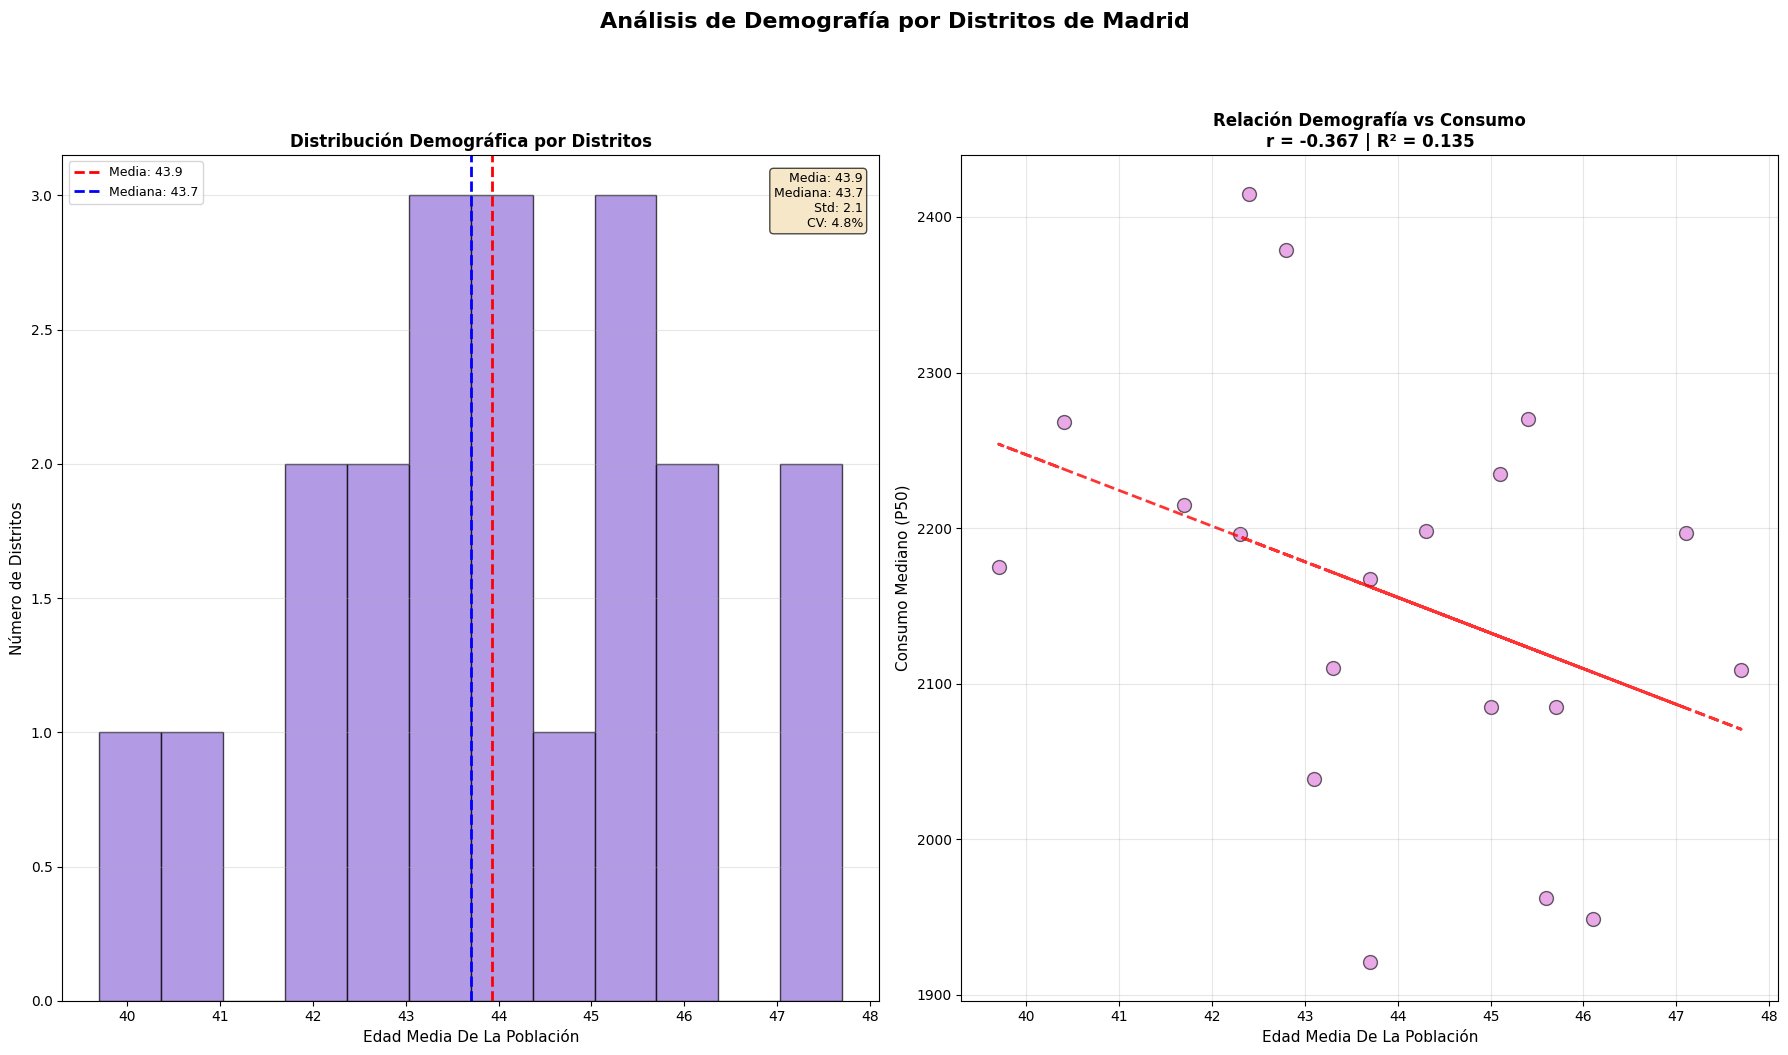

In [115]:
# === FIGURA 2: 1x2 (Distribución + Correlación sin outliers) ===
if len(distritos_demografia) > 0 and consumo_ref in df_main.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    fig.suptitle('Análisis de Demografía por Distritos de Madrid',
                 fontsize=16, fontweight='bold', y=1.05)

    # --- SUBPLOT 1: Distribución de la variable demográfica principal ---
    ax = axes[0]
    demo_values = distritos_demografia[demo_principal].dropna()
    demo_values = demo_values[:20]

    ax.hist(demo_values, bins=12, alpha=0.7, color='mediumpurple', edgecolor='black')

    mean_demo = demo_values.mean()
    median_demo = demo_values.median()
    std_demo = demo_values.std()
    cv = (std_demo / mean_demo) * 100 if mean_demo > 0 else 0

    ax.axvline(mean_demo, color='red', linestyle='--', linewidth=2,
               label=f'Media: {mean_demo:.1f}')
    ax.axvline(median_demo, color='blue', linestyle='--', linewidth=2,
               label=f'Mediana: {median_demo:.1f}')
    ax.set_xlabel(demo_principal.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Número de Distritos', fontsize=11)
    ax.set_title('Distribución Demográfica por Distritos',
                 fontweight='bold', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    stats_text = (f"Media: {mean_demo:.1f}\n"
                  f"Mediana: {median_demo:.1f}\n"
                  f"Std: {std_demo:.1f}\n"
                  f"CV: {cv:.1f}%")
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # --- SUBPLOT 2: Correlación Demografía vs Consumo (SIN outliers) ---
    ax = axes[1]

    # Unir consumo con demografía por distrito
    if col_distrito in df_main.columns:
        demo_consumo_data = pd.merge(
            distritos_demografia[[col_distrito, demo_principal]],
            df_main[[col_distrito, consumo_ref]],
            on=col_distrito,
            how='inner'
        ).dropna()
    else:
        demo_consumo_data = pd.DataFrame()

    if len(demo_consumo_data) > 3:
        # Eliminar outliers en ambas columnas con IQR
        for col in [demo_principal, consumo_ref]:
            Q1 = demo_consumo_data[col].quantile(0.25)
            Q3 = demo_consumo_data[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = ((demo_consumo_data[col] >= Q1 - 1.5 * IQR) &
                    (demo_consumo_data[col] <= Q3 + 1.5 * IQR))
            demo_consumo_data = demo_consumo_data[mask]

        # Revisión por si nos quedamos sin puntos
        if len(demo_consumo_data) > 2:
            ax.scatter(
                demo_consumo_data[demo_principal],
                demo_consumo_data[consumo_ref],
                alpha=0.6, s=100, color='orchid',
                edgecolors='black', linewidth=1
            )

            # Ajuste lineal
            z = np.polyfit(
                demo_consumo_data[demo_principal],
                demo_consumo_data[consumo_ref],
                1
            )
            p = np.poly1d(z)
            ax.plot(
                demo_consumo_data[demo_principal],
                p(demo_consumo_data[demo_principal]),
                "r--", alpha=0.8, linewidth=2
            )

            corr_val = demo_consumo_data[demo_principal].corr(
                demo_consumo_data[consumo_ref]
            )
            r2 = corr_val ** 2

            ax.set_xlabel(demo_principal.replace('_', ' ').title(), fontsize=11)
            ax.set_ylabel('Consumo Mediano (P50)', fontsize=11)
            ax.set_title(
                f'Relación Demografía vs Consumo\n'
                f'r = {corr_val:.3f} | R² = {r2:.3f}',
                fontweight='bold', fontsize=12
            )
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes o falta la columna de consumo para la segunda figura")


🔗 Análisis de Movilidad por Distritos de Madrid


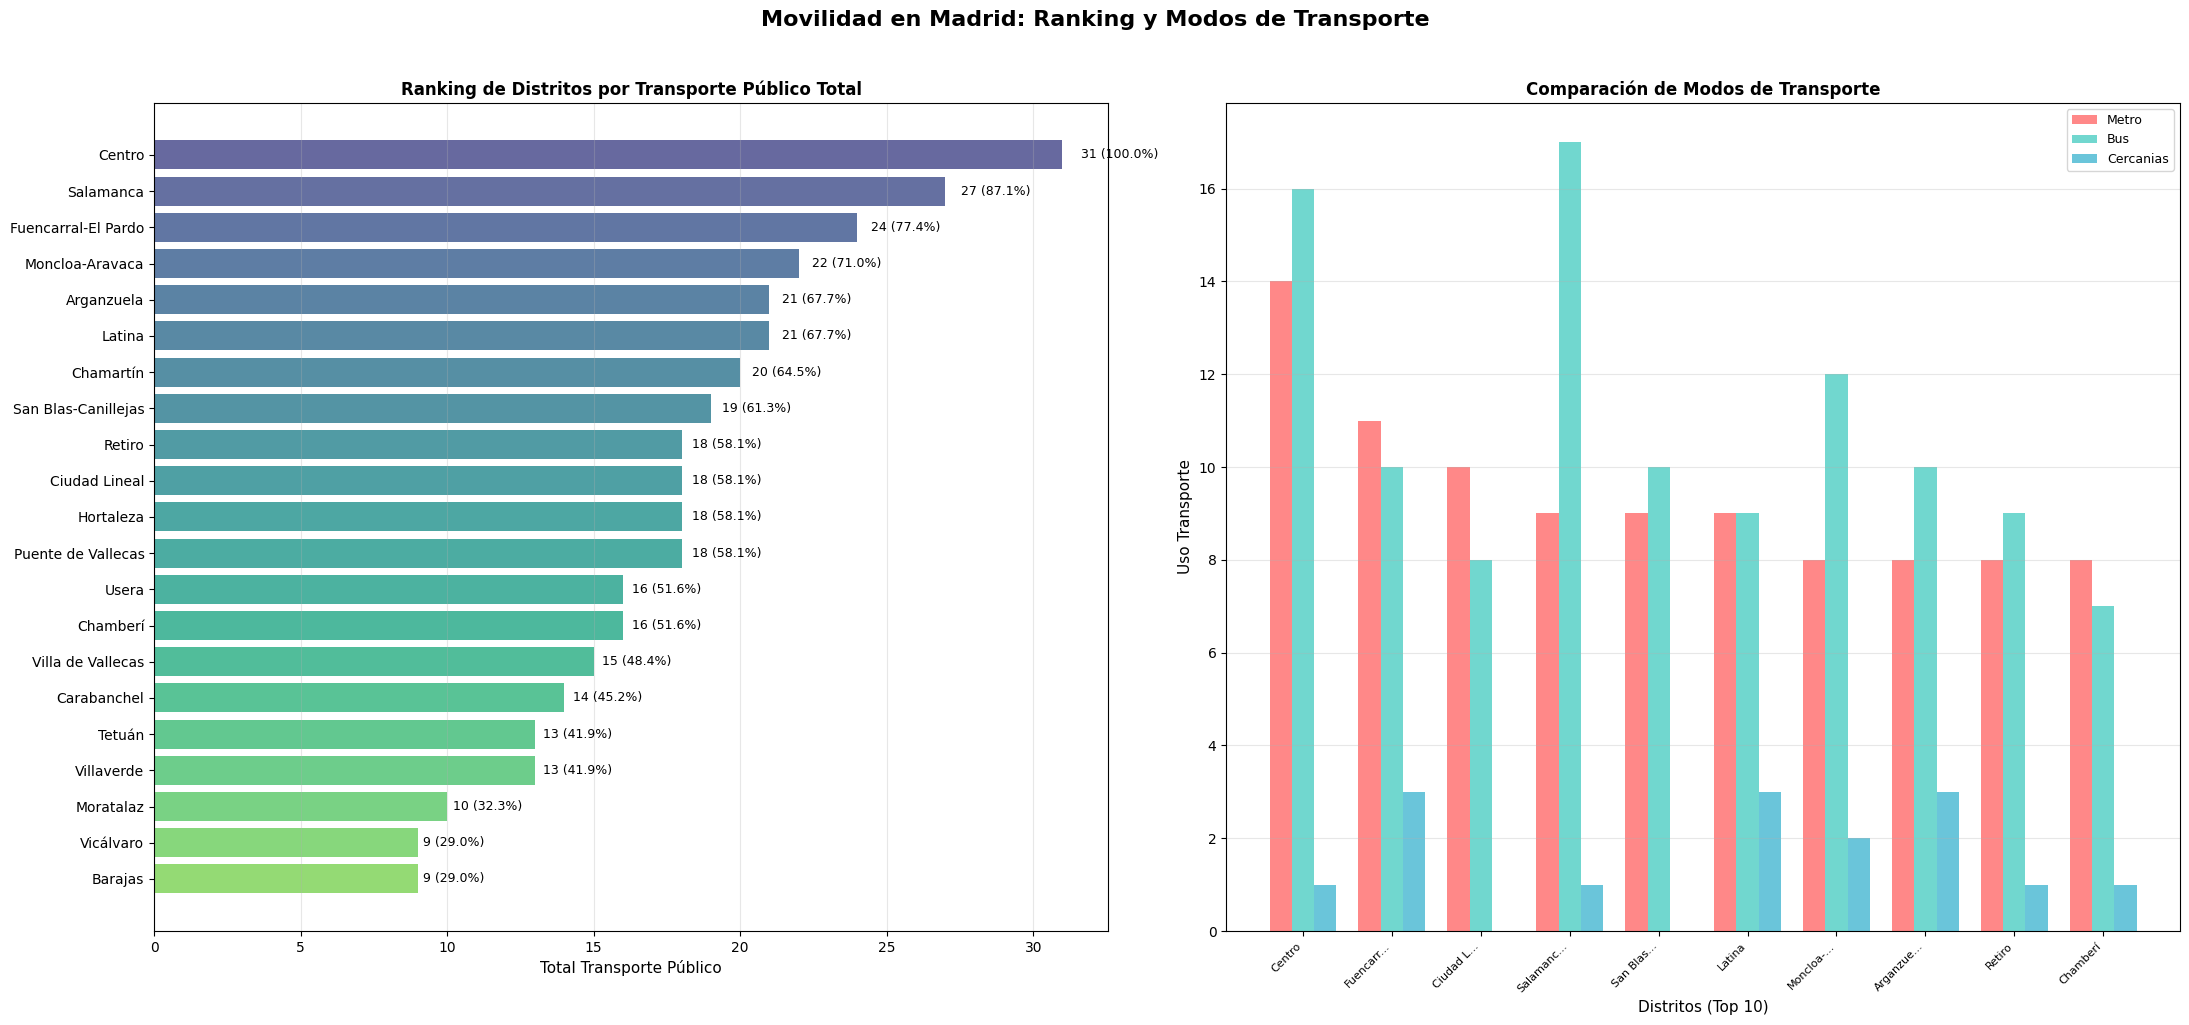

In [ ]:
# === VISUALIZACIÓN: Ranking + Comparación de Modos de Transporte ===
print("🔗 Análisis de Movilidad por Distritos de Madrid")
print("=" * 70)

# Variables
metro_var = "metro_stations_count"
bus_var = "bus_lines_count"
cercanias_var = "cercanias_stations_count"
total_transport_var = "total_transport_stations"

# Datos base
distritos_movilidad = df_main[[col_distrito, metro_var, bus_var, cercanias_var, total_transport_var]].dropna()

if len(distritos_movilidad) > 0:
    # === FIGURA 1: Ranking de transporte público total ===
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    fig.suptitle('Movilidad en Madrid: Ranking y Modos de Transporte',
                 fontsize=16, fontweight='bold', y=1.02)

    # 8.1.1 — Ranking total
    ax = axes[0]
    transport_data = distritos_movilidad[[col_distrito, total_transport_var]].copy()
    transport_data = transport_data.sort_values(total_transport_var, ascending=False)
    max_val = transport_data[total_transport_var].max()

    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(transport_data)))
    bars = ax.barh(
        transport_data[col_distrito],
        transport_data[total_transport_var],
        color=colors, alpha=0.8
    )

    ax.invert_yaxis()
    ax.set_xlabel('Total Transporte Público', fontsize=11)
    ax.set_title('Ranking de Distritos por Transporte Público Total',
                 fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

    # Etiquetas con valor y porcentaje relativo
    for i, val in enumerate(transport_data[total_transport_var]):
        pct = (val / max_val) * 100
        ax.text(val + val * 0.02, i, f'{val:.0f} ({pct:.1f}%)', va='center', ha='left', fontsize=9)

    # === FIGURA 1.2: Comparación Metro vs Bus vs Cercanías ===
    ax = axes[1]
    modos_existentes = [v for v in [metro_var, bus_var, cercanias_var] if v in distritos_movilidad.columns]

    if len(modos_existentes) >= 2:
        modos_data = distritos_movilidad[[col_distrito] + modos_existentes].dropna()
        modos_data = modos_data.sort_values(modos_existentes[0], ascending=False).head(10)

        x = np.arange(len(modos_data))
        width = 0.25
        colors_modos = ['#FF6B6B', '#4ECDC4', '#45B7D1']

        for i, var_col in enumerate(modos_existentes[:3]):
            ax.bar(x + i * width, modos_data[var_col], width,
                   label=var_col.split('_')[0].capitalize(),
                   alpha=0.8, color=colors_modos[i])

        ax.set_xlabel('Distritos (Top 10)', fontsize=11)
        ax.set_ylabel('Uso Transporte', fontsize=11)
        ax.set_title('Comparación de Modos de Transporte', fontweight='bold', fontsize=12)
        ax.set_xticks(x + width)
        ax.set_xticklabels(
            [str(name)[:8] + '...' if len(str(name)) > 8 else str(name)
             for name in modos_data[col_distrito]],
            rotation=45, ha='right', fontsize=8
        )
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para la visualización de movilidad (Parte 1).")



🔗 Análisis de Movilidad por Distritos de Madrid


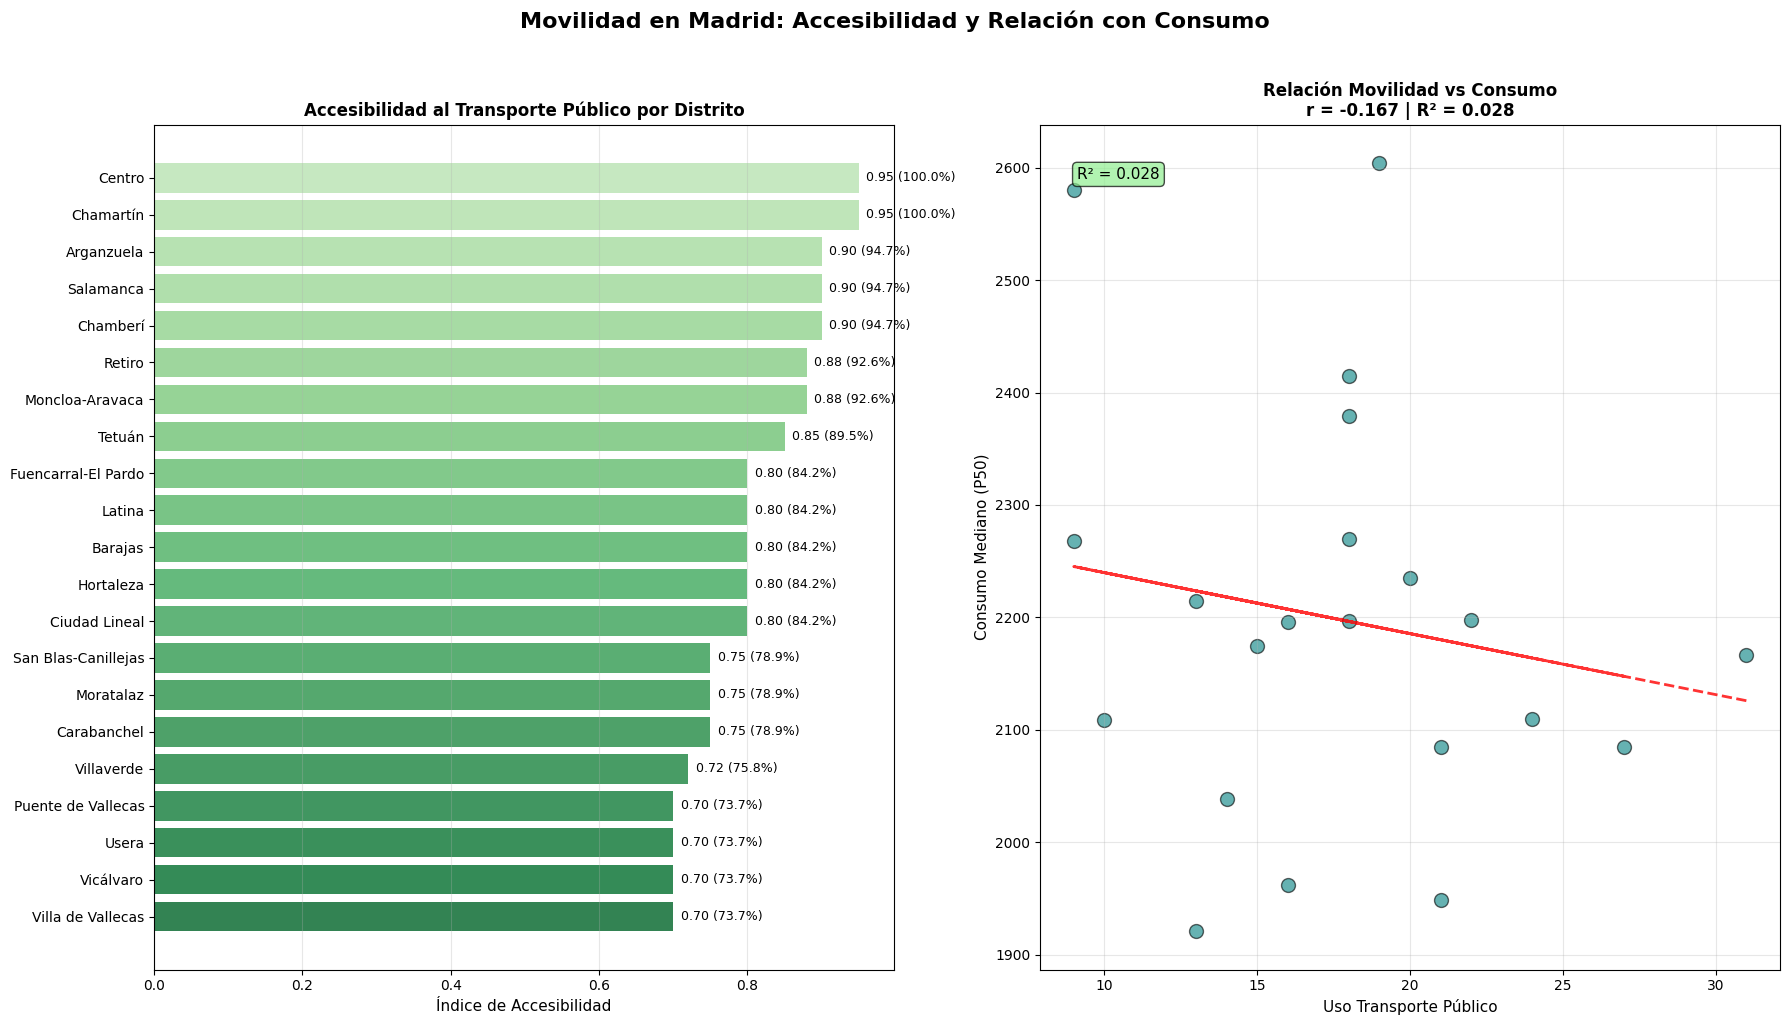

In [ ]:
# === VISUALIZACIÓN: Accesibilidad + Relación con Consumo ===
print("🔗 Análisis de Movilidad por Distritos de Madrid")
print("=" * 70)

# Variables
accessibility_var = "accessibility_score"
total_transport_var = "total_transport_stations"

# Datos base
distritos_movilidad = df_main[[col_distrito, accessibility_var, total_transport_var, consumo_ref]].dropna()

if len(distritos_movilidad) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    fig.suptitle('Movilidad en Madrid: Accesibilidad y Relación con Consumo',
                 fontsize=16, fontweight='bold', y=1.02)

    # 8.2.1 — Accesibilidad
    ax = axes[0]
    acc_data = distritos_movilidad[[col_distrito, accessibility_var]].copy()
    acc_data = acc_data.sort_values(accessibility_var, ascending=False)
    max_acc = acc_data[accessibility_var].max()

    colors_acc = plt.cm.Greens(np.linspace(0.3, 0.9, len(acc_data)))
    bars = ax.barh(
        acc_data[col_distrito],
        acc_data[accessibility_var],
        color=colors_acc, alpha=0.8
    )

    ax.invert_yaxis()
    ax.set_xlabel('Índice de Accesibilidad', fontsize=11)
    ax.set_title('Accesibilidad al Transporte Público por Distrito',
                 fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)

    for i, val in enumerate(acc_data[accessibility_var]):
        pct = (val / max_acc) * 100
        ax.text(val + 0.01, i, f'{val:.2f} ({pct:.1f}%)', va='center', ha='left', fontsize=9)

    # 8.2.2 — Relación Movilidad vs Consumo
    ax = axes[1]
    mov_consumo_data = distritos_movilidad[[col_distrito, total_transport_var, consumo_ref]].dropna()

    if len(mov_consumo_data) > 0:
        ax.scatter(
            mov_consumo_data[total_transport_var],
            mov_consumo_data[consumo_ref],
            alpha=0.6, s=100, color='teal',
            edgecolors='black', linewidth=1
        )

        # Línea de tendencia
        z = np.polyfit(
            mov_consumo_data[total_transport_var],
            mov_consumo_data[consumo_ref], 1
        )
        p = np.poly1d(z)
        ax.plot(
            mov_consumo_data[total_transport_var],
            p(mov_consumo_data[total_transport_var]),
            "r--", alpha=0.8, linewidth=2
        )

        corr = mov_consumo_data[total_transport_var].corr(mov_consumo_data[consumo_ref])
        r2 = corr ** 2

        ax.set_xlabel('Uso Transporte Público', fontsize=11)
        ax.set_ylabel('Consumo Mediano (P50)', fontsize=11)
        ax.set_title(f'Relación Movilidad vs Consumo\nr = {corr:.3f} | R² = {r2:.3f}',
                     fontweight='bold', fontsize=12)
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos suficientes para la visualización de movilidad (Parte 2).")


🔗 Análisis de Impacto Ambiental: Contaminantes y Temperatura

📊 Variables ambientales seleccionadas: 3
   - pm10: pm10_mean
   - no2: no2_mean
   - temperatura: temperatura_media_mean


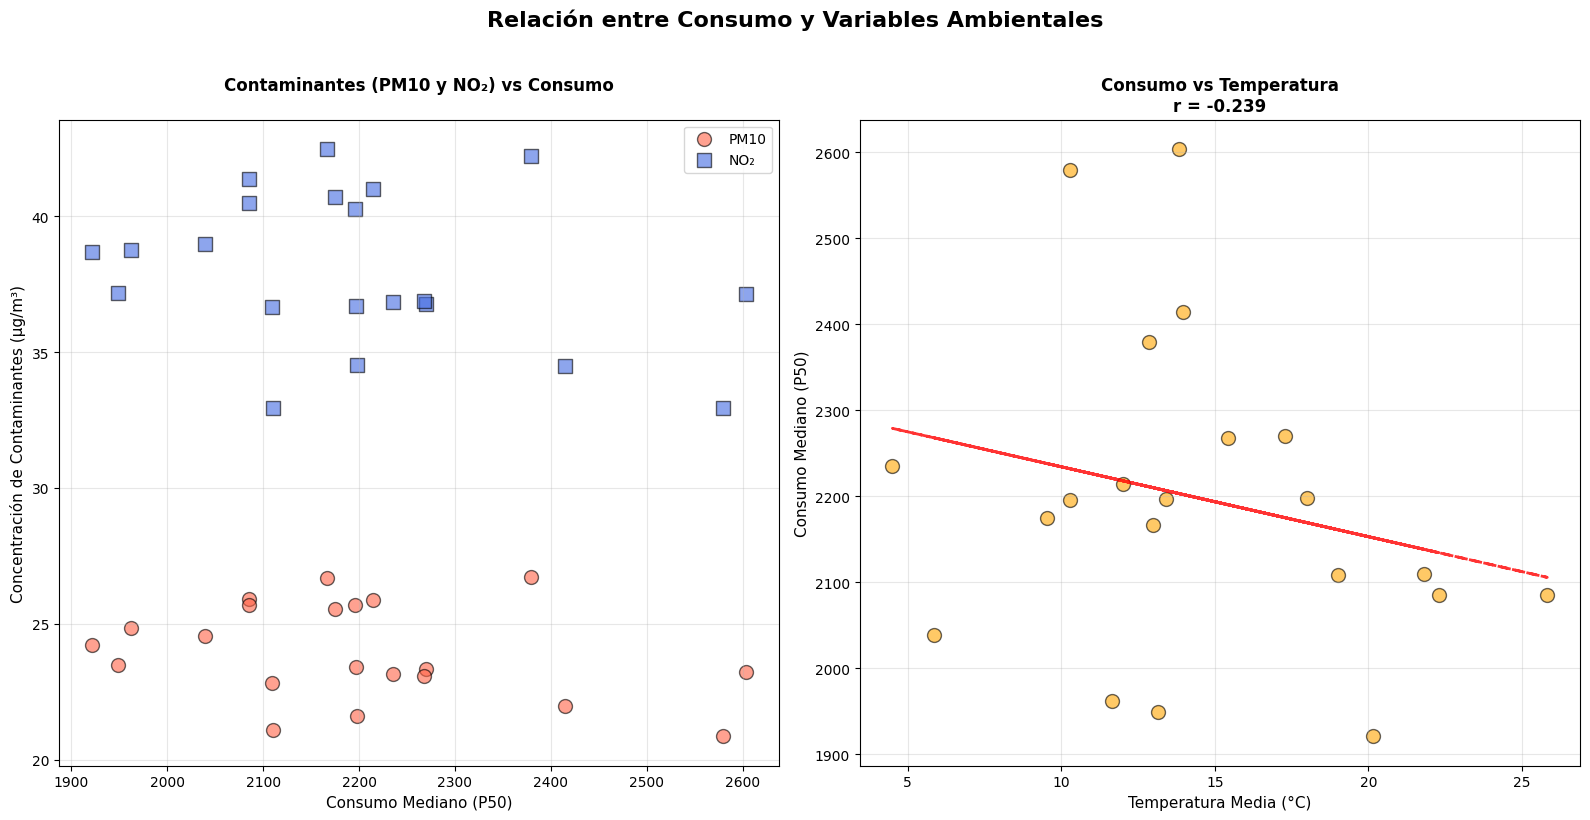

In [118]:
# === VISUALIZACIÓN: IMPACTO AMBIENTAL (Contaminantes y Temperatura) ===
print("🔗 Análisis de Impacto Ambiental: Contaminantes y Temperatura")
print("=" * 70)

# Seleccionar variables ambientales relevantes
vars_ambientales = {}

if air_quality_vars:
    for pollutant in ['pm10', 'no2']:
        matching_vars = [v for v in air_quality_vars if pollutant in v.lower()]
        if matching_vars:
            mean_vars = [v for v in matching_vars if '_mean' in v.lower()]
            vars_ambientales[pollutant] = mean_vars[0] if mean_vars else matching_vars[0]

if weather_vars:
    temp_vars = [v for v in weather_vars if 'temperatura_media_mean' in v.lower()]
    if temp_vars:
        vars_ambientales['temperatura'] = temp_vars[0]

print(f"\n📊 Variables ambientales seleccionadas: {len(vars_ambientales)}")
for var_name, var_col in vars_ambientales.items():
    print(f"   - {var_name}: {var_col}")

# Crear figura con dos gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Relación entre Consumo y Variables Ambientales', 
             fontsize=16, fontweight='bold', y=1.02)

# === GRÁFICO 1: Consumo vs Contaminantes (PM10 y NO2) ===
ax = axes[0]
pm10_col = vars_ambientales.get('pm10', None)
no2_col = vars_ambientales.get('no2', None)

if pm10_col in df_main.columns:
    if no2_col and no2_col in df_main.columns:
        valid_data = df_main[[consumo_ref, pm10_col, no2_col]].dropna()
        if len(valid_data) > 3:
            ax.scatter(valid_data[consumo_ref], valid_data[pm10_col],
                       alpha=0.6, s=100, color='tomato', label='PM10', edgecolors='black')
            ax.scatter(valid_data[consumo_ref], valid_data[no2_col],
                       alpha=0.6, s=100, color='royalblue', label='NO₂', edgecolors='black', marker='s')
            ax.legend()
    else:
        valid_data = df_main[[consumo_ref, pm10_col]].dropna()
        if len(valid_data) > 3:
            ax.scatter(valid_data[consumo_ref], valid_data[pm10_col],
                       alpha=0.6, s=100, color='tomato', edgecolors='black')

    ax.set_xlabel('Consumo Mediano (P50)', fontsize=11)
    ax.set_ylabel('Concentración de Contaminantes (µg/m³)', fontsize=11)
    ax.set_title('Contaminantes (PM10 y NO₂) vs Consumo\n',
                 fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)

# === GRÁFICO 2: Consumo vs Temperatura ===
ax = axes[1]
temp_col = vars_ambientales.get('temperatura', None)

if temp_col and temp_col in df_main.columns:
    valid_data = df_main[[consumo_ref, temp_col]].dropna()
    if len(valid_data) > 3:
        ax.scatter(valid_data[temp_col], valid_data[consumo_ref],
                   alpha=0.6, s=100, color='orange', edgecolors='black', linewidth=1)
        
        # Línea de tendencia
        z = np.polyfit(valid_data[temp_col], valid_data[consumo_ref], 1)
        p = np.poly1d(z)
        ax.plot(valid_data[temp_col], p(valid_data[temp_col]), "r--", alpha=0.8, linewidth=2)

        corr_val = valid_data[temp_col].corr(valid_data[consumo_ref])
        ax.set_xlabel('Temperatura Media (°C)', fontsize=11)
        ax.set_ylabel('Consumo Mediano (P50)', fontsize=11)
        ax.set_title(f'Consumo vs Temperatura\nr = {corr_val:.3f}', fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔗 Análisis de Correlaciones entre Consumo y Variables Ambientales, Socioeconómicas y de Movilidad

📊 Top 15 variables más correlacionadas con consumo (P50):
   1. distrito_num                             :  0.627
   2. ica_std                                  :  0.506
   3. dias_moderada                            : -0.476
   4. porcentaje_de_población_menor_de_18_años :  0.450
   5. so2_max                                  :  0.400
   6. presion_mean                             : -0.393
   7. porcentaje_dias_buena                    :  0.384
   8. dias_buena                               :  0.384
   9. o3_max                                   :  0.348
  10. velocidad_viento_mean                    : -0.347
  11. velocidad_viento_max                     : -0.347
  12. precio_distrito_mean                     : -0.336
  13. precio_distrito_std                      : -0.334
  14. edad_media_de_la_población               : -0.328
  15. precio_distrito_max                      : -0.315


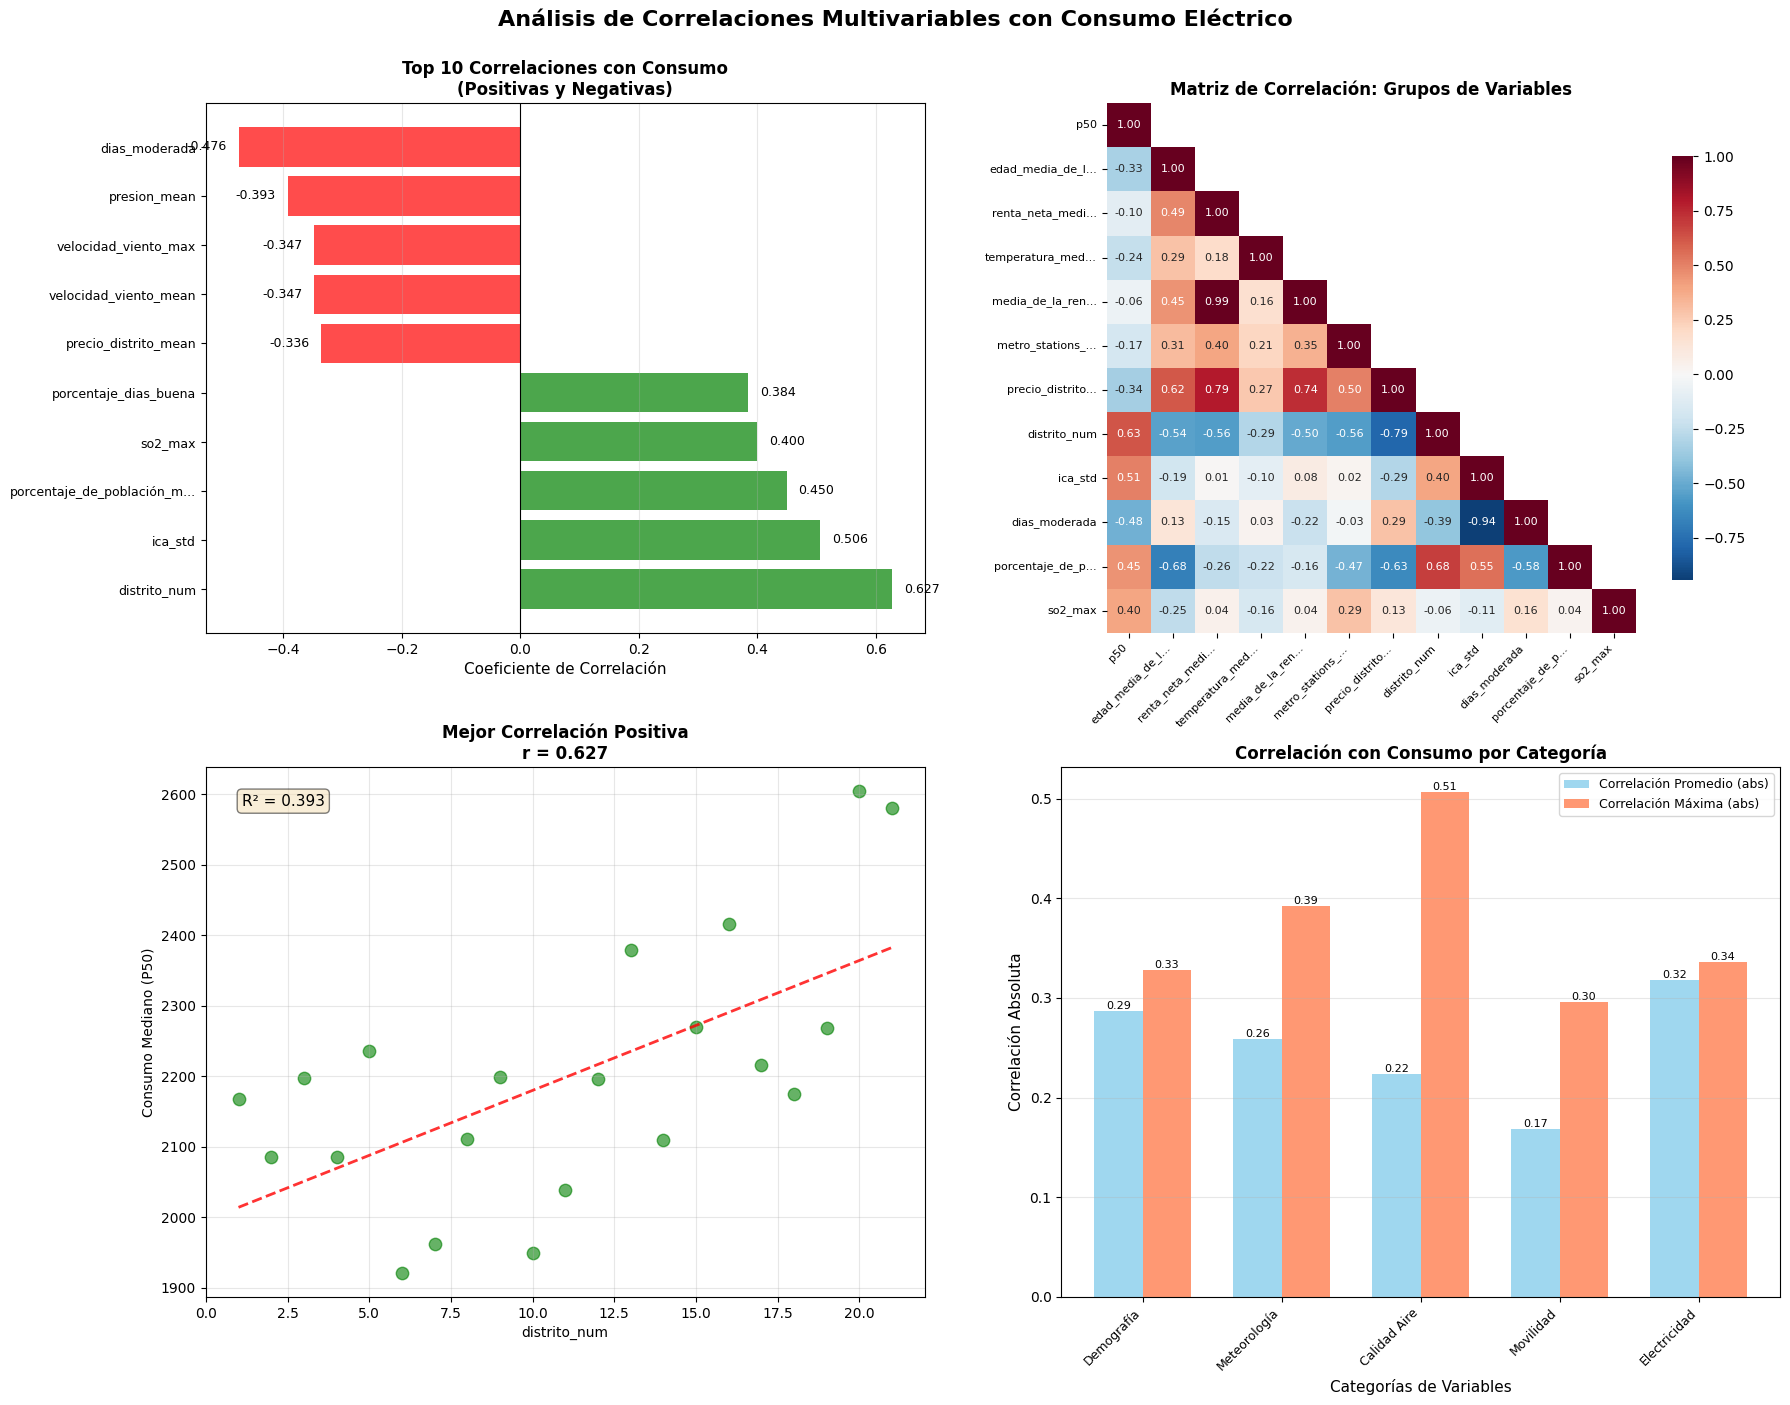


✅ Visualización 2 completada: Análisis de correlaciones multivariables


In [119]:
# === VISUALIZACIÓN: ANÁLISIS DE CORRELACIONES MULTIVARIABLES ===
print("🔗 Análisis de Correlaciones entre Consumo y Variables Ambientales, Socioeconómicas y de Movilidad")
print("=" * 70)

# Preparar datos para análisis de correlaciones
numeric_cols = df_main.select_dtypes(include=[np.number]).columns.tolist()
consumo_ref = 'p50'

# Filtrar columnas con suficientes datos
valid_cols = [col for col in numeric_cols if df_main[col].notna().sum() >= 10]

# Calcular correlaciones con consumo
correlations_with_consumo = {}
for col in valid_cols:
    if col != consumo_ref and col not in consumo_vars:
        corr_value = df_main[[consumo_ref, col]].dropna().corr().iloc[0, 1]
        if not np.isnan(corr_value):
            correlations_with_consumo[col] = corr_value

# Ordenar por valor absoluto de correlación
correlations_sorted = sorted(correlations_with_consumo.items(), key=lambda x: abs(x[1]), reverse=True)

print(f"\n📊 Top 15 variables más correlacionadas con consumo (P50):")
for i, (var, corr) in enumerate(correlations_sorted[:15], 1):
    print(f"  {i:2d}. {var[:40]:40s} : {corr:6.3f}")

# Crear visualización 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análisis de Correlaciones Multivariables con Consumo Eléctrico', 
             fontsize=16, fontweight='bold', y=1.0)

# 2.1: Top 10 correlaciones positivas y negativas
ax = axes[0, 0]
top_positive = [x for x in correlations_sorted if x[1] > 0][:5]
top_negative = [x for x in correlations_sorted if x[1] < 0][:5]

# Combinar y ordenar
combined = top_positive + top_negative
combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

vars_names = [x[0][:25] + '...' if len(x[0]) > 25 else x[0] for x in combined_sorted]
corr_values = [x[1] for x in combined_sorted]
colors = ['green' if x > 0 else 'red' for x in corr_values]

bars = ax.barh(range(len(vars_names)), corr_values, color=colors, alpha=0.7)
ax.set_yticks(range(len(vars_names)))
ax.set_yticklabels(vars_names, fontsize=9)
ax.set_xlabel('Coeficiente de Correlación', fontsize=11)
ax.set_title('Top 10 Correlaciones con Consumo\n(Positivas y Negativas)', fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, corr_values)):
    ax.text(val + (0.02 if val > 0 else -0.02), i, f'{val:.3f}', 
           va='center', ha='left' if val > 0 else 'right', fontsize=9)

# 2.2: Matriz de correlación entre grupos de variables
ax = axes[0, 1]
# Seleccionar variables representativas de cada grupo
vars_corr = [consumo_ref]
if demo_vars:
    vars_corr.append(demo_vars[0])
if renta_vars:
    vars_corr.append(renta_vars[0])
if weather_vars:
    vars_corr.append(weather_vars[0])
if air_quality_vars:
    vars_corr.append(air_quality_vars[0])
if mobility_vars:
    vars_corr.append(mobility_vars[0])
if electricity_vars:
    vars_corr.append(electricity_vars[0])

# Añadir las top correlaciones
for var, _ in correlations_sorted[:5]:
    if var not in vars_corr:
        vars_corr.append(var)
    if len(vars_corr) >= 12:
        break

vars_corr = [v for v in vars_corr if v in df_main.columns]
if len(vars_corr) > 1:
    corr_matrix = df_main[vars_corr].corr()
    # Acortar nombres para el heatmap
    labels_corr = [v[:15] + '...' if len(v) > 15 else v for v in vars_corr]
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8},
                xticklabels=labels_corr, yticklabels=labels_corr, 
                annot_kws={'fontsize': 8})
    ax.set_title('Matriz de Correlación: Grupos de Variables', fontweight='bold', fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# 2.3: Scatter plots de mejores correlaciones
ax = axes[1, 0]
best_pos = correlations_sorted[0] if correlations_sorted and correlations_sorted[0][1] > 0 else None
best_neg = next((x for x in correlations_sorted if x[1] < 0), None)

if best_pos and best_pos[0] in df_main.columns:
    best_var = best_pos[0]
    valid_data = df_main[[consumo_ref, best_var]].dropna()
    
    if len(valid_data) > 0:
        ax.scatter(valid_data[best_var], valid_data[consumo_ref], alpha=0.6, s=80, color='green')
        
        # Línea de regresión
        z = np.polyfit(valid_data[best_var], valid_data[consumo_ref], 1)
        p = np.poly1d(z)
        ax.plot(valid_data[best_var], p(valid_data[best_var]), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel(best_var[:30] + ('...' if len(best_var) > 30 else ''), fontsize=10)
        ax.set_ylabel('Consumo Mediano (P50)', fontsize=10)
        ax.set_title(f'Mejor Correlación Positiva\nr = {best_pos[1]:.3f}', 
                    fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Añadir R²
        r2 = best_pos[1] ** 2
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2.4: Análisis de correlaciones por categoría
ax = axes[1, 1]
categories = {
    'Demografía': demo_vars,
    'Renta': renta_vars,
    'Meteorología': weather_vars,
    'Calidad Aire': air_quality_vars,
    'Movilidad': mobility_vars,
    'Electricidad': electricity_vars
}

cat_correlations = {}
for cat, vars_list in categories.items():
    if vars_list:
        cat_corr_values = [correlations_with_consumo.get(v, 0) for v in vars_list if v in correlations_with_consumo]
        if cat_corr_values:
            cat_correlations[cat] = {
                'mean': np.mean([abs(x) for x in cat_corr_values]),
                'max': max([abs(x) for x in cat_corr_values], default=0),
                'count': len(cat_corr_values)
            }

if cat_correlations:
    cats = list(cat_correlations.keys())
    means = [cat_correlations[cat]['mean'] for cat in cats]
    maxs = [cat_correlations[cat]['max'] for cat in cats]
    
    x = np.arange(len(cats))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, means, width, label='Correlación Promedio (abs)', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, maxs, width, label='Correlación Máxima (abs)', alpha=0.8, color='coral')
    
    ax.set_xlabel('Categorías de Variables', fontsize=11)
    ax.set_ylabel('Correlación Absoluta', fontsize=11)
    ax.set_title('Correlación con Consumo por Categoría', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Visualización 2 completada: Análisis de correlaciones multivariables")


🔗 Análisis de Interacción: Movilidad y Calidad del Aire

📊 Variables de movilidad disponibles: ['accessibility_score', 'connectivity_score', 'total_transport_stations']
🌍 Variables de calidad del aire disponibles: ['no2_mean', 'pm10_mean', 'ica_mean']
✅ Índice de movilidad sostenible creado


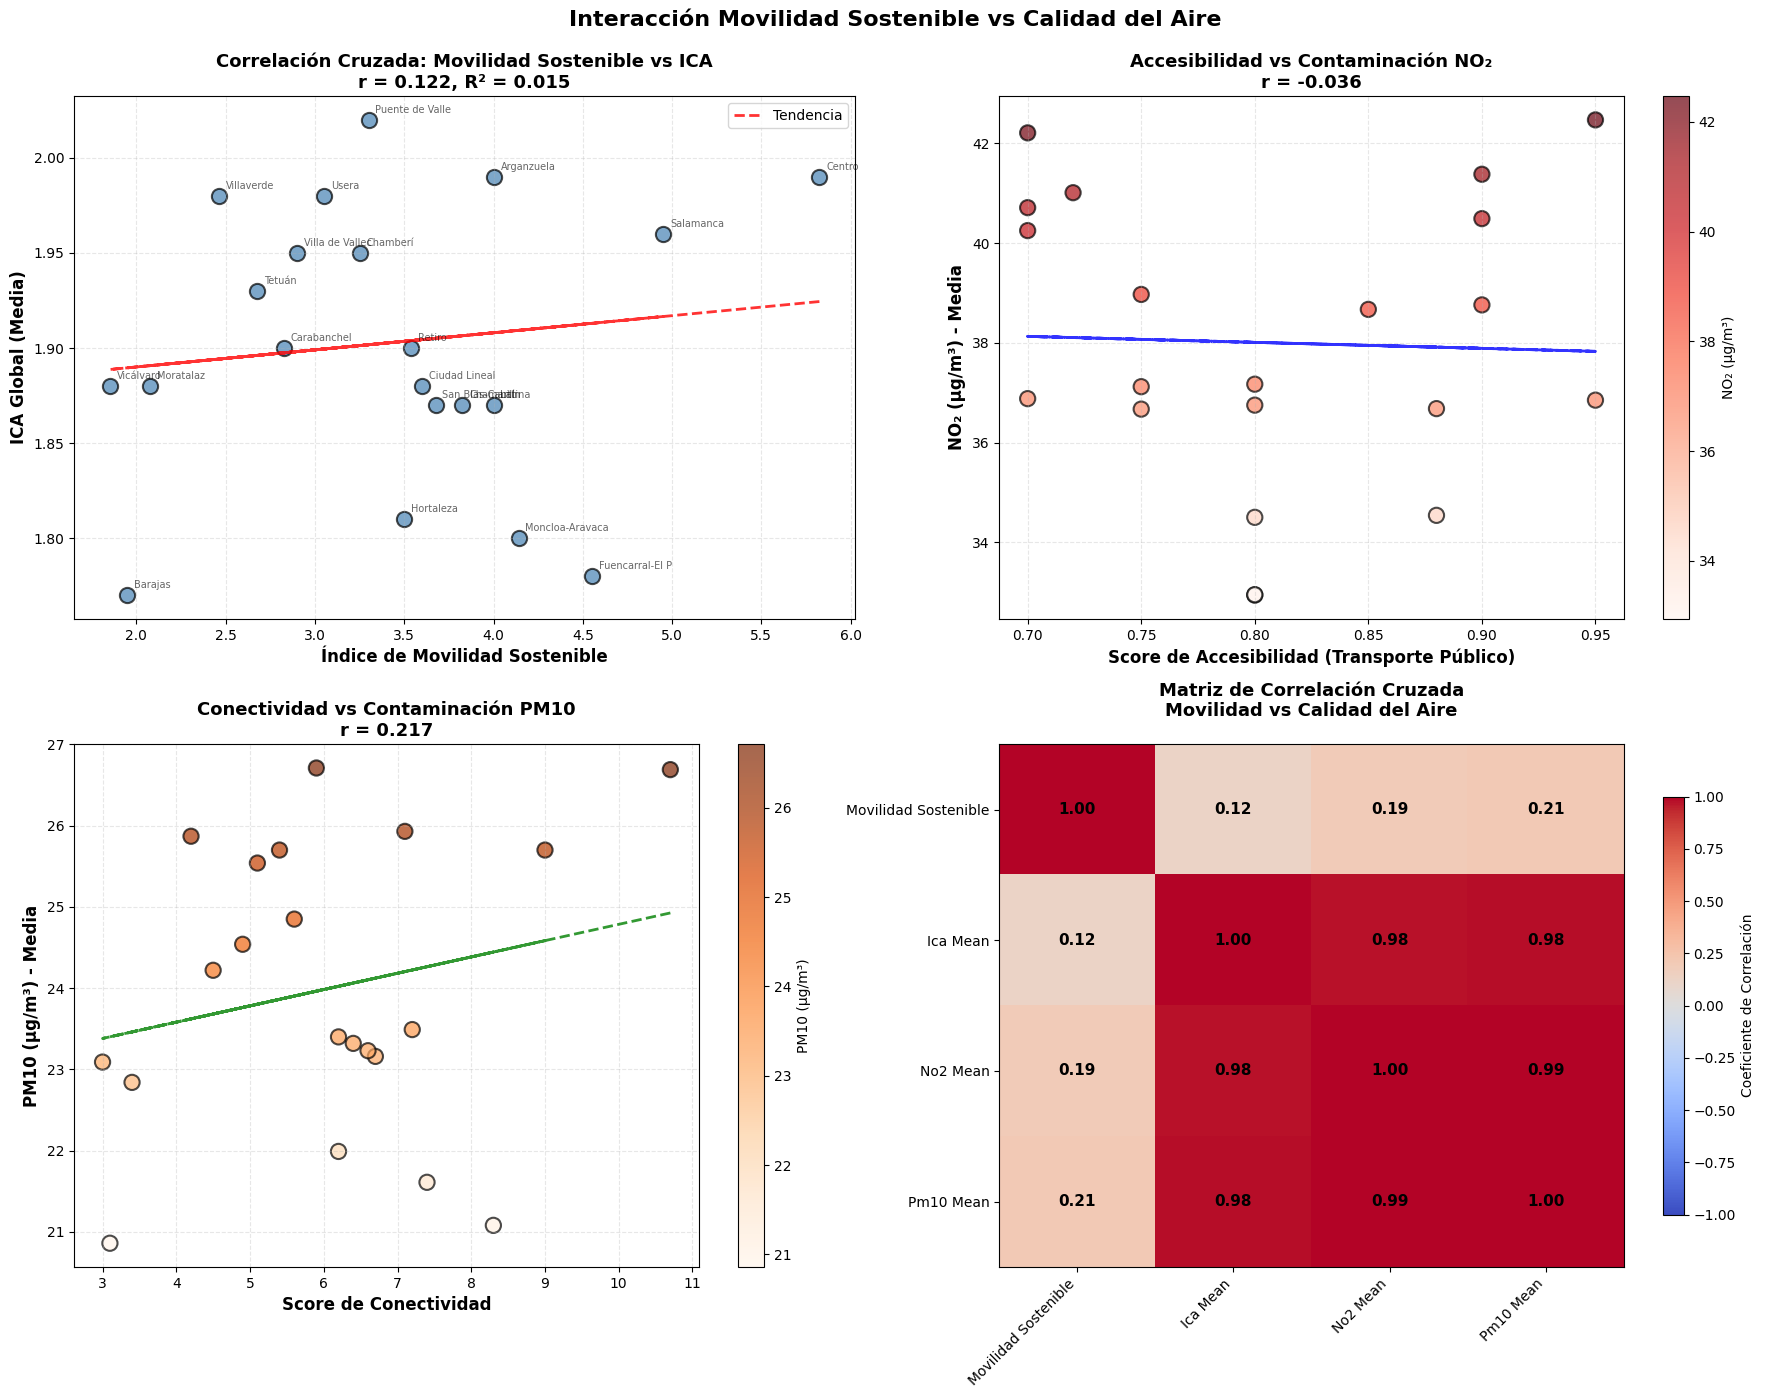


📊 Estadísticas Descriptivas:
----------------------------------------------------------------------

📈 Índice de Movilidad Sostenible:
   Media: 3.426
   Mediana: 3.500
   Std: 0.990

🌍 Calidad del Aire:
   No2 Mean: Media=38.00, Std=2.86
   Pm10 Mean: Media=23.99, Std=1.78
   Ica Mean: Media=1.90, Std=0.07

🔗 Correlaciones Principales:
----------------------------------------------------------------------
   Movilidad Sostenible vs ICA: r = 0.122
   Accesibilidad vs NO₂: r = -0.036
   Conectividad vs PM10: r = 0.217

⚠️ Nota: Las correlaciones observadas son exploratorias y requieren análisis adicional
   para establecer relaciones causales o patrones determinísticos.


In [120]:
# === VISUALIZACIÓN: MOVILIDAD SOSTENIBLE vs CALIDAD DEL AIRE ===
print("🔗 Análisis de Interacción: Movilidad y Calidad del Aire")
print("=" * 70)

# Identificar variables de movilidad y calidad del aire disponibles
movilidad_vars = []
aire_vars = []

# Variables de movilidad sostenible
if 'accessibility_score' in df_main.columns:
    movilidad_vars.append('accessibility_score')
if 'connectivity_score' in df_main.columns:
    movilidad_vars.append('connectivity_score')
if 'total_transport_stations' in df_main.columns:
    movilidad_vars.append('total_transport_stations')

# Variables de calidad del aire
if 'no2_mean' in df_main.columns:
    aire_vars.append('no2_mean')
if 'pm10_mean' in df_main.columns:
    aire_vars.append('pm10_mean')
if 'ica_mean' in df_main.columns:
    aire_vars.append('ica_mean')

print(f"\n📊 Variables de movilidad disponibles: {movilidad_vars}")
print(f"🌍 Variables de calidad del aire disponibles: {aire_vars}")

# Crear índice de movilidad sostenible (combinación de accesibilidad y conectividad)
if 'accessibility_score' in df_main.columns and 'connectivity_score' in df_main.columns:
    df_main['movilidad_sostenible'] = (
        df_main['accessibility_score'].fillna(0) * 0.5 +
        df_main['connectivity_score'].fillna(0) * 0.5
    )
    print(f"✅ Índice de movilidad sostenible creado")
elif 'accessibility_score' in df_main.columns:
    df_main['movilidad_sostenible'] = df_main['accessibility_score'].fillna(0)
    print(f"✅ Usando accessibility_score como índice de movilidad sostenible")
else:
    print("⚠️ No se pueden crear índices de movilidad sostenible")

# Preparar datos para visualización
if col_distrito in df_main.columns and len(movilidad_vars) > 0 and len(aire_vars) > 0:
    # Filtrar datos válidos
    data_analysis = df_main[[col_distrito] + movilidad_vars + aire_vars].copy()
    if 'movilidad_sostenible' in df_main.columns:
        data_analysis['movilidad_sostenible'] = df_main['movilidad_sostenible']
    
    # Eliminar filas con demasiados NaN
    data_analysis = data_analysis.dropna(thresh=len(data_analysis.columns) * 0.5)
    
    if len(data_analysis) > 3:
        # === CREAR FIGURA 2x2 ===
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Interacción Movilidad Sostenible vs Calidad del Aire', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        # --- SUBPLOT 1: Movilidad Sostenible vs ICA Global ---
        ax = axes[0, 0]
        if 'movilidad_sostenible' in data_analysis.columns and 'ica_mean' in data_analysis.columns:
            mov_ica_data = data_analysis[['movilidad_sostenible', 'ica_mean']].dropna()
            
            if len(mov_ica_data) > 3:
                ax.scatter(mov_ica_data['movilidad_sostenible'], mov_ica_data['ica_mean'],
                          alpha=0.7, s=120, color='steelblue', edgecolors='black', linewidth=1.5)
                
                # Línea de tendencia
                z = np.polyfit(mov_ica_data['movilidad_sostenible'], mov_ica_data['ica_mean'], 1)
                p = np.poly1d(z)
                ax.plot(mov_ica_data['movilidad_sostenible'], 
                       p(mov_ica_data['movilidad_sostenible']), 
                       "r--", alpha=0.8, linewidth=2, label='Tendencia')
                
                # Correlación
                corr_mov_ica = mov_ica_data['movilidad_sostenible'].corr(mov_ica_data['ica_mean'])
                r2 = corr_mov_ica ** 2
                
                ax.set_xlabel('Índice de Movilidad Sostenible', fontsize=12, fontweight='bold')
                ax.set_ylabel('ICA Global (Media)', fontsize=12, fontweight='bold')
                ax.set_title(f'Correlación Cruzada: Movilidad Sostenible vs ICA\nr = {corr_mov_ica:.3f}, R² = {r2:.3f}', 
                           fontweight='bold', fontsize=13)
                ax.legend(fontsize=10)
                ax.grid(True, alpha=0.3, linestyle='--')
                
                # Añadir etiquetas para distritos destacados
                for idx, row in mov_ica_data.iterrows():
                    distrito_name = data_analysis.loc[idx, col_distrito]
                    if isinstance(distrito_name, str) and len(distrito_name) < 20:
                        ax.annotate(distrito_name[:15], 
                                   (row['movilidad_sostenible'], row['ica_mean']),
                                   fontsize=7, alpha=0.6, xytext=(5, 5), 
                                   textcoords='offset points')
        
        # --- SUBPLOT 2: Accesibilidad vs NO₂ ---
        ax = axes[0, 1]
        if 'accessibility_score' in data_analysis.columns and 'no2_mean' in data_analysis.columns:
            acc_no2_data = data_analysis[['accessibility_score', 'no2_mean']].dropna()
            
            if len(acc_no2_data) > 3:
                # Color según nivel de NO2
                colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(acc_no2_data)))
                scatter = ax.scatter(acc_no2_data['accessibility_score'], acc_no2_data['no2_mean'],
                                   alpha=0.7, s=120, c=acc_no2_data['no2_mean'], 
                                   cmap='Reds', edgecolors='black', linewidth=1.5)
                
                # Línea de tendencia
                z = np.polyfit(acc_no2_data['accessibility_score'], acc_no2_data['no2_mean'], 1)
                p = np.poly1d(z)
                ax.plot(acc_no2_data['accessibility_score'], 
                       p(acc_no2_data['accessibility_score']), 
                       "b--", alpha=0.8, linewidth=2)
                
                # Correlación
                corr_acc_no2 = acc_no2_data['accessibility_score'].corr(acc_no2_data['no2_mean'])
                
                ax.set_xlabel('Score de Accesibilidad (Transporte Público)', fontsize=12, fontweight='bold')
                ax.set_ylabel('NO₂ (µg/m³) - Media', fontsize=12, fontweight='bold')
                ax.set_title(f'Accesibilidad vs Contaminación NO₂\nr = {corr_acc_no2:.3f}', 
                           fontweight='bold', fontsize=13)
                ax.grid(True, alpha=0.3, linestyle='--')
                plt.colorbar(scatter, ax=ax, label='NO₂ (µg/m³)')
        
        # --- SUBPLOT 3: Conectividad vs PM10 ---
        ax = axes[1, 0]
        if 'connectivity_score' in data_analysis.columns and 'pm10_mean' in data_analysis.columns:
            conn_pm10_data = data_analysis[['connectivity_score', 'pm10_mean']].dropna()
            
            if len(conn_pm10_data) > 3:
                # Color según nivel de PM10
                scatter = ax.scatter(conn_pm10_data['connectivity_score'], conn_pm10_data['pm10_mean'],
                                   alpha=0.7, s=120, c=conn_pm10_data['pm10_mean'], 
                                   cmap='Oranges', edgecolors='black', linewidth=1.5)
                
                # Línea de tendencia
                z = np.polyfit(conn_pm10_data['connectivity_score'], conn_pm10_data['pm10_mean'], 1)
                p = np.poly1d(z)
                ax.plot(conn_pm10_data['connectivity_score'], 
                       p(conn_pm10_data['connectivity_score']), 
                       "g--", alpha=0.8, linewidth=2)
                
                # Correlación
                corr_conn_pm10 = conn_pm10_data['connectivity_score'].corr(conn_pm10_data['pm10_mean'])
                
                ax.set_xlabel('Score de Conectividad', fontsize=12, fontweight='bold')
                ax.set_ylabel('PM10 (µg/m³) - Media', fontsize=12, fontweight='bold')
                ax.set_title(f'Conectividad vs Contaminación PM10\nr = {corr_conn_pm10:.3f}', 
                           fontweight='bold', fontsize=13)
                ax.grid(True, alpha=0.3, linestyle='--')
                plt.colorbar(scatter, ax=ax, label='PM10 (µg/m³)')
        
        # --- SUBPLOT 4: Matriz de Correlación Cruzada (Movilidad-Aire) ---
        ax = axes[1, 1]
        
        # Preparar matriz de correlación
        corr_vars = []
        if 'movilidad_sostenible' in data_analysis.columns:
            corr_vars.append('movilidad_sostenible')
        elif 'accessibility_score' in data_analysis.columns:
            corr_vars.append('accessibility_score')
        
        if 'ica_mean' in data_analysis.columns:
            corr_vars.append('ica_mean')
        if 'no2_mean' in data_analysis.columns:
            corr_vars.append('no2_mean')
        if 'pm10_mean' in data_analysis.columns:
            corr_vars.append('pm10_mean')
        
        if len(corr_vars) >= 2:
            corr_matrix_data = data_analysis[corr_vars].dropna()
            if len(corr_matrix_data) > 3:
                corr_matrix = corr_matrix_data.corr()
                
                # Heatmap de correlación
                im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
                
                # Añadir valores de correlación
                for i in range(len(corr_matrix)):
                    for j in range(len(corr_matrix)):
                        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                     ha="center", va="center", color="black", fontweight='bold', fontsize=11)
                
                # Etiquetas
                ax.set_xticks(range(len(corr_matrix.columns)))
                ax.set_yticks(range(len(corr_matrix.columns)))
                ax.set_xticklabels([col.replace('_', ' ').title()[:20] for col in corr_matrix.columns], 
                                  rotation=45, ha='right', fontsize=10)
                ax.set_yticklabels([col.replace('_', ' ').title()[:20] for col in corr_matrix.columns], 
                                  fontsize=10)
                
                ax.set_title('Matriz de Correlación Cruzada\nMovilidad vs Calidad del Aire', 
                           fontweight='bold', fontsize=13, pad=20)
                plt.colorbar(im, ax=ax, label='Coeficiente de Correlación', shrink=0.8)
        
        plt.tight_layout()
        plt.show()
        
        # === ESTADÍSTICAS DESCRIPTIVAS ===
        print("\n📊 Estadísticas Descriptivas:")
        print("-" * 70)
        
        if 'movilidad_sostenible' in data_analysis.columns:
            print(f"\n📈 Índice de Movilidad Sostenible:")
            print(f"   Media: {data_analysis['movilidad_sostenible'].mean():.3f}")
            print(f"   Mediana: {data_analysis['movilidad_sostenible'].median():.3f}")
            print(f"   Std: {data_analysis['movilidad_sostenible'].std():.3f}")
        
        if len(aire_vars) > 0:
            print(f"\n🌍 Calidad del Aire:")
            for var in aire_vars:
                if var in data_analysis.columns:
                    print(f"   {var.replace('_', ' ').title()}: "
                          f"Media={data_analysis[var].mean():.2f}, "
                          f"Std={data_analysis[var].std():.2f}")
        
        # Correlaciones principales
        print(f"\n🔗 Correlaciones Principales:")
        print("-" * 70)
        if 'movilidad_sostenible' in data_analysis.columns and 'ica_mean' in data_analysis.columns:
            mov_ica = data_analysis[['movilidad_sostenible', 'ica_mean']].dropna()
            if len(mov_ica) > 3:
                corr = mov_ica['movilidad_sostenible'].corr(mov_ica['ica_mean'])
                print(f"   Movilidad Sostenible vs ICA: r = {corr:.3f}")
        
        if 'accessibility_score' in data_analysis.columns and 'no2_mean' in data_analysis.columns:
            acc_no2 = data_analysis[['accessibility_score', 'no2_mean']].dropna()
            if len(acc_no2) > 3:
                corr = acc_no2['accessibility_score'].corr(acc_no2['no2_mean'])
                print(f"   Accesibilidad vs NO₂: r = {corr:.3f}")
        
        if 'connectivity_score' in data_analysis.columns and 'pm10_mean' in data_analysis.columns:
            conn_pm10 = data_analysis[['connectivity_score', 'pm10_mean']].dropna()
            if len(conn_pm10) > 3:
                corr = conn_pm10['connectivity_score'].corr(conn_pm10['pm10_mean'])
                print(f"   Conectividad vs PM10: r = {corr:.3f}")
        
        print("\n⚠️ Nota: Las correlaciones observadas son exploratorias y requieren análisis adicional")
        print("   para establecer relaciones causales o patrones determinísticos.")
        
    else:
        print("⚠️ No hay suficientes datos para el análisis")
else:
    print("⚠️ Variables de movilidad o calidad del aire no disponibles en df_main")



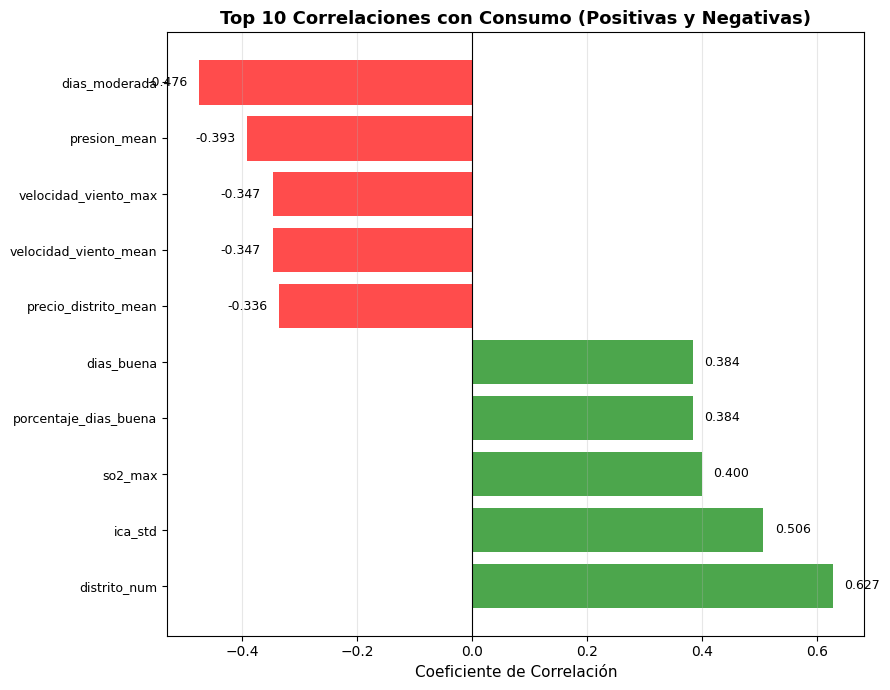

In [ ]:
# === GRÁFICO 1: TOP 10 CORRELACIONES ===
plt.figure(figsize=(9, 7))
top_positive = [x for x in correlations_sorted if x[1] > 0][:5]
top_negative = [x for x in correlations_sorted if x[1] < 0][:5]
combined = top_positive + top_negative
combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

vars_names = [x[0][:25] + '...' if len(x[0]) > 25 else x[0] for x in combined_sorted]
corr_values = [x[1] for x in combined_sorted]
colors = ['green' if x > 0 else 'red' for x in corr_values]

bars = plt.barh(range(len(vars_names)), corr_values, color=colors, alpha=0.7)
plt.yticks(range(len(vars_names)), vars_names, fontsize=9)
plt.xlabel('Coeficiente de Correlación', fontsize=11)
plt.title('Top 10 Correlaciones con Consumo (Positivas y Negativas)', fontweight='bold', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, corr_values)):
    plt.text(val + (0.02 if val > 0 else -0.02), i, f'{val:.3f}',
             va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()


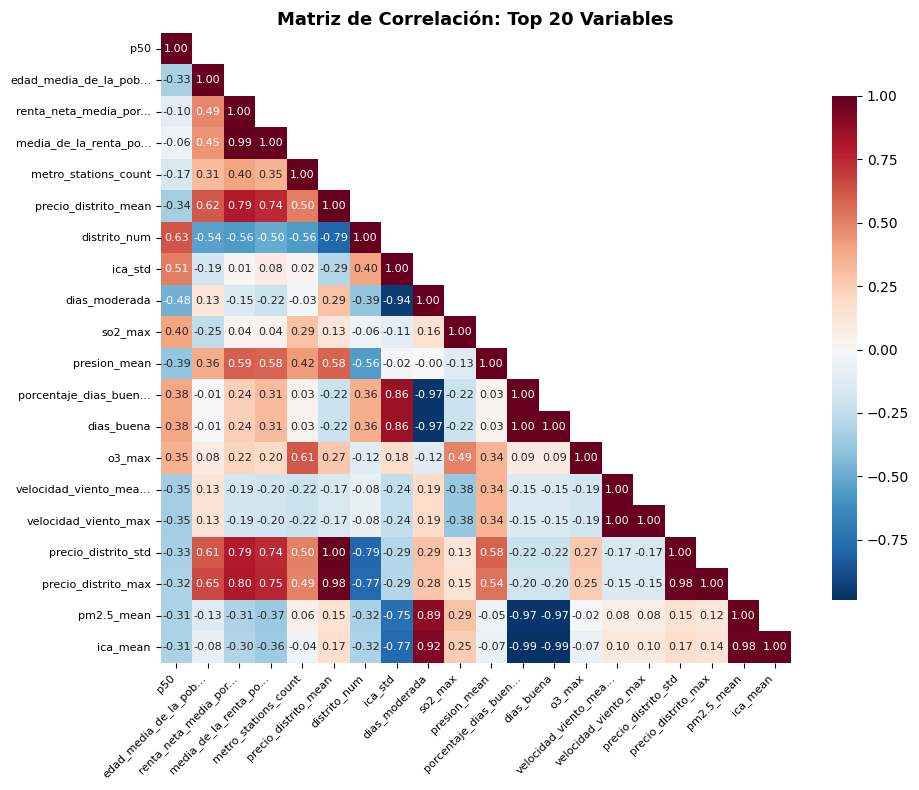

In [ ]:
# === GRÁFICO 2: MATRIZ DE CORRELACIÓN ===
vars_corr = [consumo_ref]

# Añadir una variable representativa de cada grupo
if demo_vars: vars_corr.append(demo_vars[0])
if renta_vars: vars_corr.append(renta_vars[0])
if air_quality_vars: vars_corr.append(air_quality_vars[0])
if mobility_vars: vars_corr.append(mobility_vars[0])
if electricity_vars: vars_corr.append(electricity_vars[0])

# Añadir las top correlaciones hasta tener 20 variables en total
for var, _ in correlations_sorted[:20]:
    if var not in vars_corr:
        vars_corr.append(var)
    if len(vars_corr) >= 20:
        break

# Filtrar variables válidas presentes en el DataFrame
vars_corr = [v for v in vars_corr if v in df_main.columns]

if len(vars_corr) > 1:
    corr_matrix = df_main[vars_corr].corr()
    labels_corr = [v[:20] + '...' if len(v) > 20 else v for v in vars_corr]
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, cbar_kws={'shrink': 0.8},
                xticklabels=labels_corr, yticklabels=labels_corr,
                annot_kws={'fontsize': 8})
    plt.title('Matriz de Correlación: Top 20 Variables', fontweight='bold', fontsize=13)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()


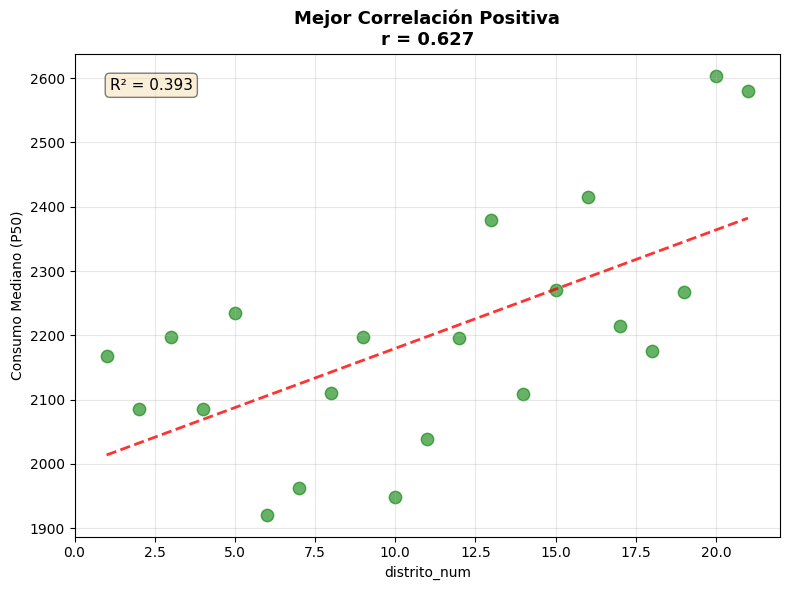

In [ ]:
# === GRÁFICO 3: DISPERSIÓN DE MEJOR CORRELACIÓN ===
best_pos = correlations_sorted[0] if correlations_sorted and correlations_sorted[0][1] > 0 else None
best_neg = next((x for x in correlations_sorted if x[1] < 0), None)

if best_pos and best_pos[0] in df_main.columns:
    best_var = best_pos[0]
    valid_data = df_main[[consumo_ref, best_var]].dropna()
    
    if len(valid_data) > 0:
        plt.figure(figsize=(8, 6))
        plt.scatter(valid_data[best_var], valid_data[consumo_ref], alpha=0.6, s=80, color='green')
        
        z = np.polyfit(valid_data[best_var], valid_data[consumo_ref], 1)
        p = np.poly1d(z)
        plt.plot(valid_data[best_var], p(valid_data[best_var]), "r--", alpha=0.8, linewidth=2)
        
        plt.xlabel(best_var[:30] + ('...' if len(best_var) > 30 else ''), fontsize=10)
        plt.ylabel('Consumo Mediano (P50)', fontsize=10)
        plt.title(f'Mejor Correlación Positiva\nr = {best_pos[1]:.3f}', fontweight='bold', fontsize=13)
        plt.grid(True, alpha=0.3)
        
        r2 = best_pos[1] ** 2
        plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
                 fontsize=11, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.tight_layout()
        plt.show()


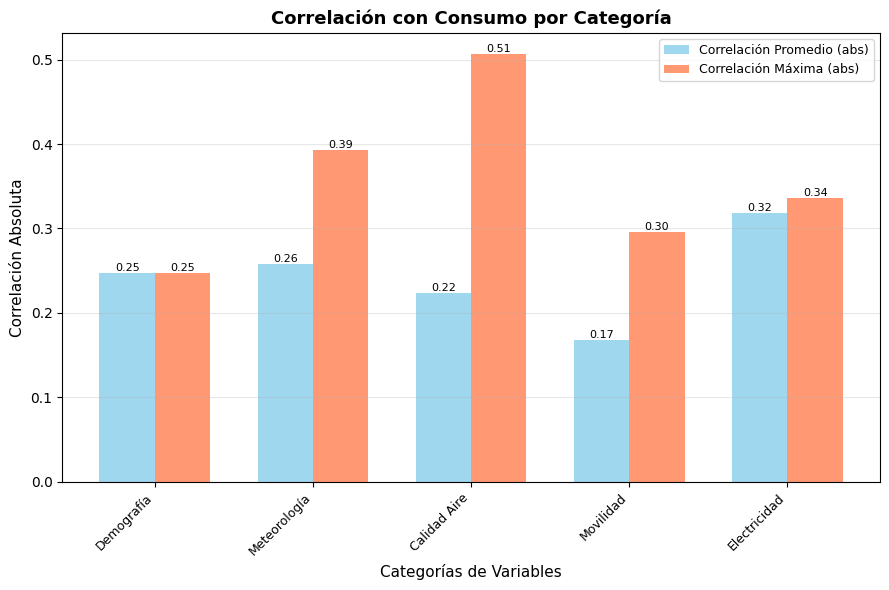

In [ ]:
# === GRÁFICO 4: CORRELACIONES POR CATEGORÍA ===
categories = {
    'Demografía': demo_vars,
    'Renta': renta_vars,
    'Meteorología': weather_vars,
    'Calidad Aire': air_quality_vars,
    'Movilidad': mobility_vars,
    'Electricidad': electricity_vars
}

cat_correlations = {}
for cat, vars_list in categories.items():
    if vars_list:
        cat_corr_values = [correlations_with_consumo.get(v, 0) for v in vars_list if v in correlations_with_consumo]
        if cat_corr_values:
            cat_correlations[cat] = {
                'mean': np.mean([abs(x) for x in cat_corr_values]),
                'max': max([abs(x) for x in cat_corr_values], default=0),
                'count': len(cat_corr_values)
            }

if cat_correlations:
    cats = list(cat_correlations.keys())
    means = [cat_correlations[cat]['mean'] for cat in cats]
    maxs = [cat_correlations[cat]['max'] for cat in cats]
    
    x = np.arange(len(cats))
    width = 0.35
    
    plt.figure(figsize=(9, 6))
    bars1 = plt.bar(x - width/2, means, width, label='Correlación Promedio (abs)', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x + width/2, maxs, width, label='Correlación Máxima (abs)', alpha=0.8, color='coral')
    
    plt.xlabel('Categorías de Variables', fontsize=11)
    plt.ylabel('Correlación Absoluta', fontsize=11)
    plt.title('Correlación con Consumo por Categoría', fontweight='bold', fontsize=13)
    plt.xticks(x, cats, rotation=45, ha='right', fontsize=9)
    plt.legend(fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


### 4. Análisis de Clusters y Segmentación de Distritos


🔗 Análisis de Clusters: Segmentación de Distritos por Características
✅ Datos tras eliminar outliers: 21 registros restantes

📊 Clusters identificados: 3
   Score de silueta: 0.266
   - Cluster 1: 11 distritos
   - Cluster 2: 6 distritos
   - Cluster 3: 4 distritos


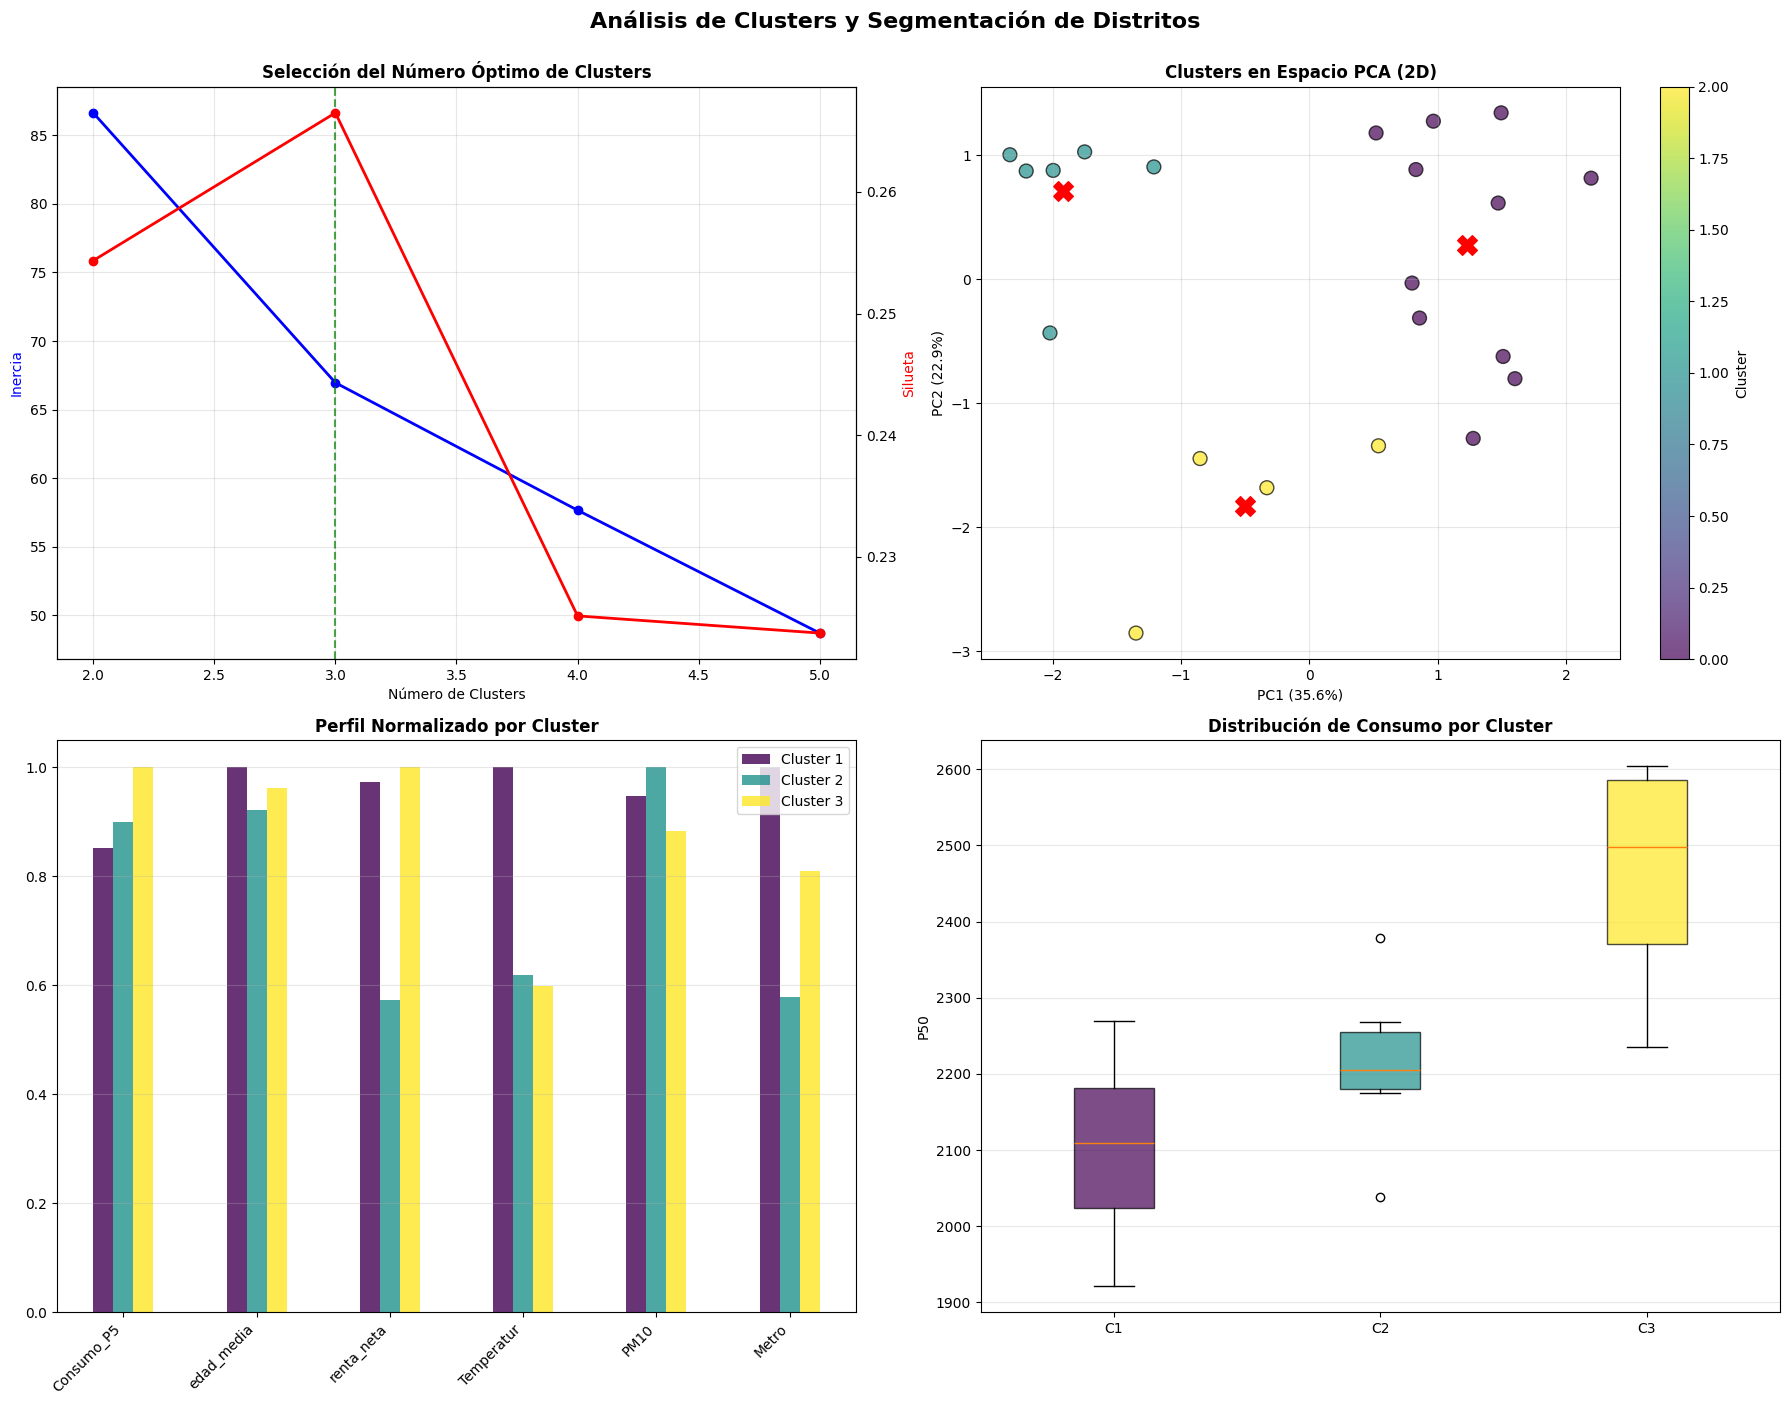


✅ Visualización 3 completada: Análisis de clusters (sin outliers)


In [121]:
# === VISUALIZACIÓN: ANÁLISIS DE CLUSTERS Y SEGMENTACIÓN ===
print("🔗 Análisis de Clusters: Segmentación de Distritos por Características")
print("=" * 70)

# Preparar variables de entrada
features_cluster = []
feature_names_cluster = []

# Variables representativas de cada grupo
if consumo_vars:
    features_cluster.append(consumo_ref)
    feature_names_cluster.append('Consumo_P50')

if demo_vars and demo_vars[0] in df_main.columns:
    features_cluster.append(demo_vars[0])
    feature_names_cluster.append(demo_vars[0][:20])

if renta_vars and renta_vars[0] in df_main.columns:
    features_cluster.append(renta_vars[0])
    feature_names_cluster.append(renta_vars[0][:20])

if weather_vars:
    temp_vars = [v for v in weather_vars if 'temperatura' in v.lower()][:1]
    if temp_vars and temp_vars[0] in df_main.columns:
        features_cluster.append(temp_vars[0])
        feature_names_cluster.append('Temperatura')

if air_quality_vars:
    pm_vars = [v for v in air_quality_vars if 'pm10' in v.lower()][:1]
    if pm_vars and pm_vars[0] in df_main.columns:
        features_cluster.append(pm_vars[0])
        feature_names_cluster.append('PM10')

if mobility_vars:
    metro_vars = [v for v in mobility_vars if 'metro' in v.lower()][:1]
    if metro_vars and metro_vars[0] in df_main.columns:
        features_cluster.append(metro_vars[0])
        feature_names_cluster.append('Metro')

# Filtrar features que existen y tienen suficientes datos
features_final, names_final = [], []
for feat, name in zip(features_cluster, feature_names_cluster):
    if feat in df_main.columns and df_main[feat].notna().sum() >= 15:
        features_final.append(feat)
        names_final.append(name)

# Continuar si hay suficientes variables
if len(features_final) >= 3:
    X_cluster = df_main[features_final].copy().dropna()

    if len(X_cluster) >= 5:
        # === ELIMINAR OUTLIERS con IQR ===
        Q1 = X_cluster.quantile(0.10)
        Q3 = X_cluster.quantile(0.90)
        IQR = Q3 - Q1
        mask = ~((X_cluster < (Q1 - 1.5 * IQR)) | (X_cluster > (Q3 + 1.5 * IQR))).any(axis=1)
        X_cluster = X_cluster[mask]

        print(f"✅ Datos tras eliminar outliers: {len(X_cluster)} registros restantes")

        # === ESTANDARIZAR ===
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_cluster)

        # === DETERMINAR N° ÓPTIMO DE CLUSTERS ===
        n_clusters_range = range(2, min(6, len(X_cluster)))
        inertias, sil_scores = [], []

        for n in n_clusters_range:
            kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            inertias.append(kmeans.inertia_)
            sil_scores.append(silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else 0)

        optimal_n = n_clusters_range[np.argmax(sil_scores)] if sil_scores else 3

        # === CLUSTERING FINAL ===
        kmeans_final = KMeans(n_clusters=optimal_n, random_state=42, n_init=10)
        cluster_labels = kmeans_final.fit_predict(X_scaled)
        X_cluster['cluster'] = cluster_labels

        # Añadir nombres de distrito si existen
        if 'distrito' in df_main.columns:
            X_cluster['distrito'] = df_main.loc[X_cluster.index, 'distrito'].values
        elif 'distrito' in df_main.columns:
            X_cluster['distrito'] = df_main.loc[X_cluster.index, 'distrito'].values

        # === INFORME CLUSTER ===
        print(f"\n📊 Clusters identificados: {optimal_n}")
        print(f"   Score de silueta: {max(sil_scores):.3f}")
        for i in range(optimal_n):
            print(f"   - Cluster {i+1}: {(cluster_labels == i).sum()} distritos")

        # === VISUALIZACIÓN 2x2 ===
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Análisis de Clusters y Segmentación de Distritos',
                     fontsize=16, fontweight='bold', y=1.0)

        # 3.1 Método del codo + Silueta
        ax = axes[0, 0]
        ax2 = ax.twinx()
        ax.plot(list(n_clusters_range), inertias, 'bo-', linewidth=2, label='Inercia')
        ax2.plot(list(n_clusters_range), sil_scores, 'ro-', linewidth=2, label='Silueta')
        ax.axvline(optimal_n, color='green', linestyle='--', alpha=0.7)
        ax.set_xlabel('Número de Clusters')
        ax.set_ylabel('Inercia', color='b')
        ax2.set_ylabel('Silueta', color='r')
        ax.set_title('Selección del Número Óptimo de Clusters', fontweight='bold')
        ax.grid(True, alpha=0.3)

        # 3.2 PCA (reducción 2D)
        ax = axes[0, 1]
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                             cmap='viridis', s=100, alpha=0.7, edgecolors='black')
        centroids_pca = pca.transform(kmeans_final.cluster_centers_)
        ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroides')
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_title('Clusters en Espacio PCA (2D)', fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Cluster')
        ax.grid(True, alpha=0.3)

        # 3.3 Perfil de características
        ax = axes[1, 0]
        cluster_means_norm = X_cluster.groupby('cluster')[features_final].mean()
        cluster_means_norm = cluster_means_norm / cluster_means_norm.max()
        x = np.arange(len(features_final))
        width = 0.15
        colors = plt.cm.viridis(np.linspace(0, 1, optimal_n))
        for i in range(optimal_n):
            offset = (i - optimal_n/2 + 0.5) * width
            ax.bar(x + offset, cluster_means_norm.iloc[i], width,
                   label=f'Cluster {i+1}', color=colors[i], alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels([n[:10] for n in names_final], rotation=45, ha='right')
        ax.set_title('Perfil Normalizado por Cluster', fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # 3.4 Distribución de consumo por cluster
        ax = axes[1, 1]
        cluster_data = [X_cluster.loc[X_cluster['cluster'] == i, features_final[0]] for i in range(optimal_n)]
        bp = ax.boxplot(cluster_data, labels=[f'C{i+1}' for i in range(optimal_n)], patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax.set_ylabel(features_final[0].replace('_', ' ').title())
        ax.set_title('Distribución de Consumo por Cluster', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n✅ Visualización 3 completada: Análisis de clusters (sin outliers)")

    else:
        print("⚠️ No hay suficientes datos para clustering (mínimo 5 registros completos)")
else:
    print("⚠️ No hay suficientes variables para clustering (mínimo 3 variables)")


🔗 Clustering K-Means: Identificación de Tipologías Energéticas

📊 Variables seleccionadas para clustering: 15
   Ejemplos: ['p50', 'p25', 'p75', 'p90', 'renta_neta_media_por_persona', 'renta_neta_media_por_hogar', 'edad_media_de_la_población', 'población']
✅ Datos tras eliminar outliers: 21 registros

📊 Aplicando Análisis de Componentes Principales (PCA)...

📈 Varianza explicada:
   PC1: 32.5% (acumulado 32.5%)
   PC2: 28.7% (acumulado 61.2%)
   PC3: 18.7% (acumulado 79.9%)
   PC4: 10.0% (acumulado 89.9%)
   PC5: 4.4% (acumulado 94.3%)
   PC6: 2.4% (acumulado 96.7%)
   PC7: 1.9% (acumulado 98.6%)
   PC8: 0.9% (acumulado 99.5%)
   PC9: 0.3% (acumulado 99.8%)
   PC10: 0.1% (acumulado 99.9%)
   PC11: 0.0% (acumulado 100.0%)
   PC12: 0.0% (acumulado 100.0%)
   PC13: 0.0% (acumulado 100.0%)
   PC14: 0.0% (acumulado 100.0%)
   PC15: 0.0% (acumulado 100.0%)

🔍 Principales variables por componente:
   PC1: accessibility_score, tamaño_medio_del_hogar, p25, connectivity_score, total_transport_st

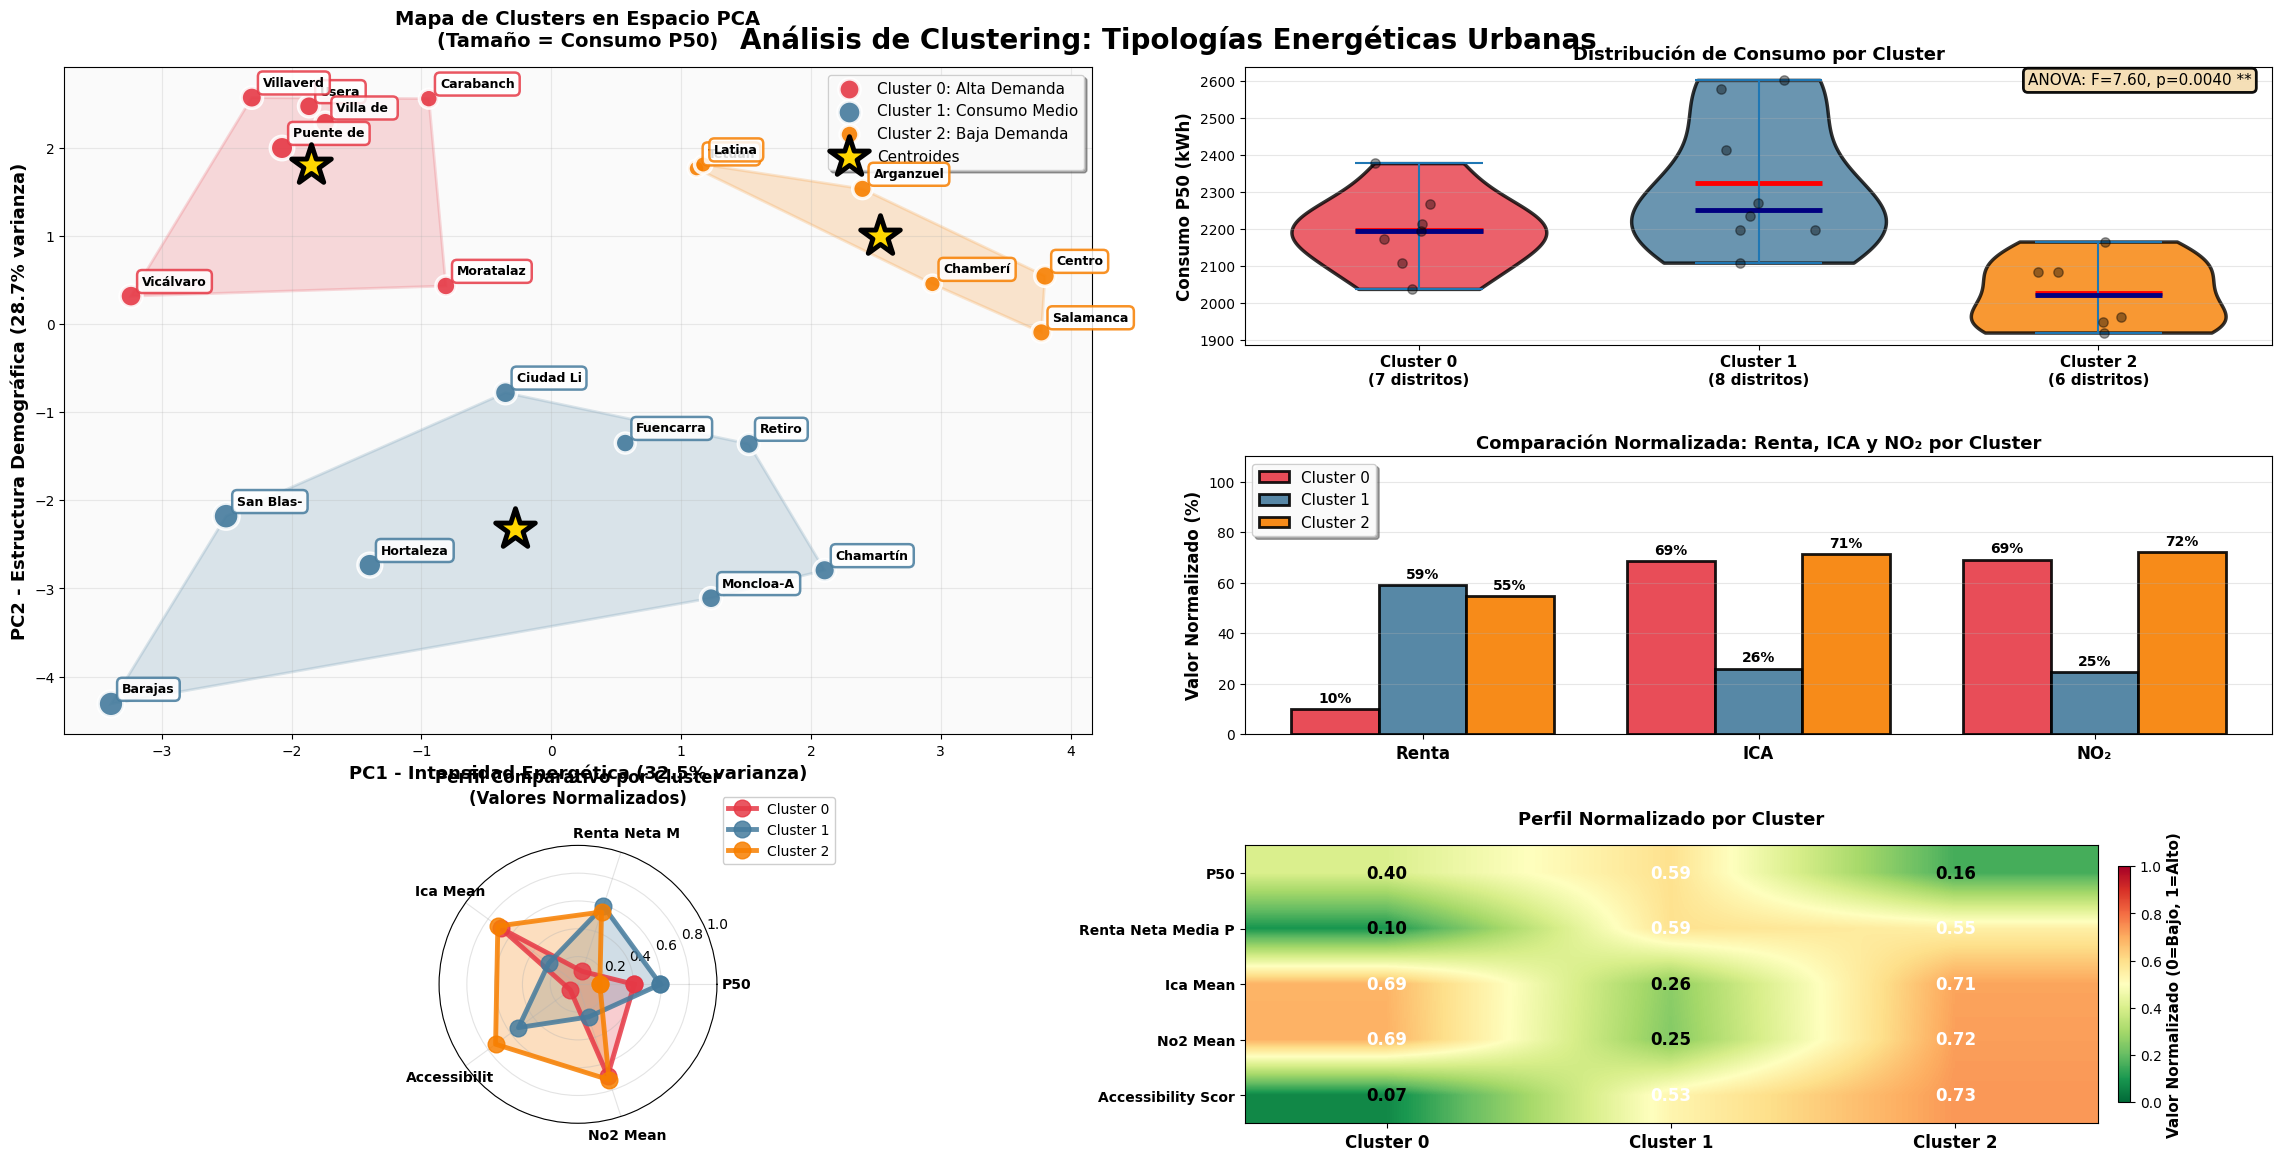

In [122]:
# === ANÁLISIS DE CLUSTERING: TIPOLOGÍAS ENERGÉTICAS URBANAS ===
print("🔗 Clustering K-Means: Identificación de Tipologías Energéticas")
print("=" * 70)

if 'df_main' in locals() and col_distrito in df_main.columns:
    # --- 1. Selección de variables relevantes ---
    exclude_cols = [col_distrito, 'distrito_num', 'distrito', 'distrito', 'territorio', 'año']

    var_categories = {
        'consumo': ['p50', 'p25', 'p75', 'p90'],
        'renta': ['renta_neta_media_por_persona', 'renta_neta_media_por_hogar'],
        'demografia': ['edad_media_de_la_población', 'población', 'tamaño_medio_del_hogar'],
        'aire': ['no2_mean', 'pm10_mean', 'ica_mean'],
        'movilidad': ['accessibility_score', 'connectivity_score', 'total_transport_stations']
    }

    clustering_vars = [v for vars_list in var_categories.values() for v in vars_list if v in df_main.columns]
    print(f"\n📊 Variables seleccionadas para clustering: {len(clustering_vars)}")
    print(f"   Ejemplos: {clustering_vars[:8]}")

    # --- 2. Preparar dataset ---
    if len(clustering_vars) >= 5:
        X_cluster = df_main[[col_distrito] + clustering_vars].copy()
        X_cluster = X_cluster.dropna(subset=clustering_vars, thresh=len(clustering_vars) * 0.7)

        if len(X_cluster) > 3:
            # --- 3. Eliminación de outliers (IQR) ---
            Q1 = X_cluster[clustering_vars].quantile(0.10)
            Q3 = X_cluster[clustering_vars].quantile(0.90)
            IQR = Q3 - Q1
            mask = ~((X_cluster[clustering_vars] < (Q1 - 1.5 * IQR)) | (X_cluster[clustering_vars] > (Q3 + 1.5 * IQR))).any(axis=1)
            X_cluster = X_cluster[mask]
            print(f"✅ Datos tras eliminar outliers: {len(X_cluster)} registros")

            # --- 4. Escalado ---
            scaler = StandardScaler()
            X_scaled = pd.DataFrame(
                scaler.fit_transform(X_cluster[clustering_vars].fillna(X_cluster[clustering_vars].median())),
                columns=clustering_vars, index=X_cluster.index
            )

            # --- 5. PCA ---
            print("\n📊 Aplicando Análisis de Componentes Principales (PCA)...")
            pca = PCA(n_components=min(len(clustering_vars), len(X_scaled) - 1))
            X_pca = pca.fit_transform(X_scaled)
            var_explained = pca.explained_variance_ratio_
            cum_var = np.cumsum(var_explained)

            print("\n📈 Varianza explicada:")
            for i, (v, c) in enumerate(zip(var_explained, cum_var), 1):
                print(f"   PC{i}: {v*100:.1f}% (acumulado {c*100:.1f}%)")

            # Variables más influyentes
            print("\n🔍 Principales variables por componente:")
            for i in range(min(3, len(pca.components_))):
                top_vars = pd.Series(pca.components_[i], index=clustering_vars).abs().nlargest(5)
                print(f"   PC{i+1}: {', '.join(top_vars.index)}")

            # --- 6. KMeans sobre componentes principales ---
            n_components_cluster = min(np.where(cum_var >= 0.7)[0][0] + 1, len(X_pca[0]))
            X_pca_cluster = X_pca[:, :n_components_cluster]
            n_clusters = 3

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(X_pca_cluster)

            X_cluster['cluster'] = clusters
            X_cluster['pc1'] = X_pca[:, 0]
            X_cluster['pc2'] = X_pca[:, 1]
            if X_pca.shape[1] > 2:
                X_cluster['pc3'] = X_pca[:, 2]

            # --- 7. Visualizaciones ---
            colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']
            labels = [f'Cluster {i}' for i in range(n_clusters)]

            # === VISUALIZACIONES MODERNAS Y DIFERENTES ===
            from matplotlib.gridspec import GridSpec
            from scipy.spatial import ConvexHull
            from scipy.stats import f_oneway
            
            # Colores modernos
            colors = ['#E63946', '#457B9D', '#F77F00']
            labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']
            cluster_names = ['Alta Demanda', 'Consumo Medio', 'Baja Demanda']
            
            # === FIGURA PRINCIPAL: Layout flexible ===
            fig = plt.figure(figsize=(24, 12))
            gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.35, 
                         left=0.04, right=0.96, top=0.94, bottom=0.06)

            # --- GRÁFICO 1: PCA con áreas convexas y gradientes ---
            ax1 = fig.add_subplot(gs[0:2, 0:2])
            
            for c in range(n_clusters):
                subset = X_cluster[X_cluster['cluster'] == c]
                points = subset[['pc1', 'pc2']].values
                
                # Área sombreada (convex hull)
                if len(points) >= 3:
                    try:
                        hull = ConvexHull(points)
                        ax1.fill(points[hull.vertices, 0], points[hull.vertices, 1], 
                               alpha=0.18, color=colors[c], zorder=1, edgecolor=colors[c], linewidth=2)
                    except:
                        pass
                
                # Puntos con tamaño según consumo
                sizes = 180
                if 'p50' in subset.columns:
                    sizes = 150 + (subset['p50'] - X_cluster['p50'].min()) / \
                            (X_cluster['p50'].max() - X_cluster['p50'].min()) * 200
                
                scatter = ax1.scatter(subset['pc1'], subset['pc2'], 
                                     c=colors[c], s=sizes, alpha=0.9,
                                     edgecolors='white', linewidth=2.5,
                                     marker='o', label=f'{labels[c]}: {cluster_names[c]}',
                                     zorder=5)
                
                # Etiquetas con fondo
                for _, row in subset.iterrows():
                    dist_name = str(row[col_distrito])[:9]
                    ax1.annotate(dist_name, (row['pc1'], row['pc2']),
                               fontsize=9, fontweight='bold', color='black',
                               bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                       alpha=0.85, edgecolor=colors[c], linewidth=1.8),
                               xytext=(8, 8), textcoords='offset points', zorder=6)

            # Centroides
            centroids = kmeans.cluster_centers_[:, :2]
            ax1.scatter(centroids[:, 0], centroids[:, 1],
                      marker='*', s=900, c='gold', edgecolors='black',
                      linewidth=3.5, label='Centroides', zorder=10)
            
            ax1.set_xlabel(f'PC1 - Intensidad Energética ({var_explained[0]*100:.1f}% varianza)', 
                          fontsize=13, fontweight='bold')
            ax1.set_ylabel(f'PC2 - Estructura Demográfica ({var_explained[1]*100:.1f}% varianza)', 
                          fontsize=13, fontweight='bold')
            ax1.set_title('Mapa de Clusters en Espacio PCA\n(Tamaño = Consumo P50)', 
                         fontweight='bold', fontsize=14, pad=15)
            ax1.legend(fontsize=11, loc='upper right', framealpha=0.95, shadow=True, fancybox=True)
            ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.8)
            ax1.set_facecolor('#FAFAFA')

            # --- GRÁFICO 2: Violin plots apilados ---
            ax2 = fig.add_subplot(gs[0, 2:])
            if 'p50' in X_cluster.columns:
                violin_data = [X_cluster[X_cluster['cluster'] == c]['p50'].dropna().values 
                              for c in range(n_clusters)]
                parts = ax2.violinplot(violin_data, positions=range(n_clusters),
                                      showmeans=True, showmedians=True, widths=0.75)
                
                for pc, color in zip(parts['bodies'], colors):
                    pc.set_facecolor(color)
                    pc.set_alpha(0.8)
                    pc.set_edgecolor('black')
                    pc.set_linewidth(2.5)
                
                parts['cmeans'].set_colors('red')
                parts['cmeans'].set_linewidths(3.5)
                parts['cmedians'].set_colors('navy')
                parts['cmedians'].set_linewidths(3.5)
                
                # Puntos individuales
                for c in range(n_clusters):
                    x_jitter = np.random.normal(c, 0.09, len(violin_data[c]))
                    ax2.scatter(x_jitter, violin_data[c], color='black', 
                              alpha=0.4, s=45, zorder=3)
                
                ax2.set_xticks(range(n_clusters))
                ax2.set_xticklabels([f'{labels[c]}\n({len(violin_data[c])} distritos)' 
                                    for c in range(n_clusters)], 
                                   fontsize=11, fontweight='bold')
                ax2.set_ylabel('Consumo P50 (kWh)', fontsize=12, fontweight='bold')
                ax2.set_title('Distribución de Consumo por Cluster', 
                            fontweight='bold', fontsize=13)
                ax2.grid(True, alpha=0.3, axis='y')
                
                # ANOVA
                groups = [X_cluster[X_cluster['cluster'] == c]['p50'].dropna() 
                         for c in range(n_clusters)]
                if all(len(g) > 0 for g in groups):
                    f_stat, p_value = f_oneway(*groups)
                    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                    ax2.text(0.98, 0.98, f'ANOVA: F={f_stat:.2f}, p={p_value:.4f} {sig}',
                           transform=ax2.transAxes, fontsize=11, ha='right', va='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.95, 
                                   edgecolor='black', linewidth=2))

            # --- GRÁFICO 3: Gráfico de barras agrupadas moderno ---
            ax3 = fig.add_subplot(gs[1, 2:])
            comparar_vars = []
            var_labels_cortos = []
            if 'renta_neta_media_por_persona' in X_cluster.columns:
                comparar_vars.append('renta_neta_media_por_persona')
                var_labels_cortos.append('Renta')
            elif 'renta_neta_media_por_hogar' in X_cluster.columns:
                comparar_vars.append('renta_neta_media_por_hogar')
                var_labels_cortos.append('Renta')
            if 'ica_mean' in X_cluster.columns:
                comparar_vars.append('ica_mean')
                var_labels_cortos.append('ICA')
            if 'no2_mean' in X_cluster.columns:
                comparar_vars.append('no2_mean')
                var_labels_cortos.append('NO₂')
            
            if len(comparar_vars) > 0:
                cluster_means = {}
                for c in range(n_clusters):
                    cluster_data = X_cluster[X_cluster['cluster'] == c]
                    cluster_means[c] = {}
                    for var in comparar_vars:
                        if var in cluster_data.columns:
                            mean_val = cluster_data[var].mean()
                            min_val = X_cluster[var].min()
                            max_val = X_cluster[var].max()
                            if max_val > min_val:
                                normalized = (mean_val - min_val) / (max_val - min_val) * 100
                            else:
                                normalized = 50
                            cluster_means[c][var] = normalized
                
                x = np.arange(len(comparar_vars))
                width = 0.26
                x_positions = [x - width, x, x + width]
                
                for c in range(n_clusters):
                    values = [cluster_means[c].get(var, 0) for var in comparar_vars]
                    bars = ax3.bar(x_positions[c], values, width, label=labels[c],
                                  color=colors[c], alpha=0.9, edgecolor='black', linewidth=2)
                    
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        ax3.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                               f'{val:.0f}%', ha='center', va='bottom', 
                               fontsize=10, fontweight='bold')
                
                ax3.set_ylabel('Valor Normalizado (%)', fontsize=12, fontweight='bold')
                ax3.set_title('Comparación Normalizada: Renta, ICA y NO₂ por Cluster', 
                            fontweight='bold', fontsize=13)
                ax3.set_xticks(x)
                ax3.set_xticklabels(var_labels_cortos, fontsize=12, fontweight='bold')
                ax3.legend(fontsize=11, framealpha=0.95, shadow=True)
                ax3.set_ylim(0, 110)
                ax3.grid(True, alpha=0.3, axis='y')

            # --- GRÁFICO 4: Radar chart polar ---
            ax4 = fig.add_subplot(gs[2, 0:2], projection='polar')
            
            radar_vars = []
            if 'p50' in X_cluster.columns:
                radar_vars.append('p50')
            if 'renta_neta_media_por_persona' in X_cluster.columns:
                radar_vars.append('renta_neta_media_por_persona')
            elif 'renta_neta_media_por_hogar' in X_cluster.columns:
                radar_vars.append('renta_neta_media_por_hogar')
            if 'ica_mean' in X_cluster.columns:
                radar_vars.append('ica_mean')
            if 'accessibility_score' in X_cluster.columns:
                radar_vars.append('accessibility_score')
            if 'no2_mean' in X_cluster.columns:
                radar_vars.append('no2_mean')
            
            if len(radar_vars) >= 4:
                angles = np.linspace(0, 2 * np.pi, len(radar_vars), endpoint=False).tolist()
                angles += angles[:1]
                
                for c in range(n_clusters):
                    cluster_data = X_cluster[X_cluster['cluster'] == c]
                    values = []
                    for var in radar_vars:
                        mean_val = cluster_data[var].mean()
                        min_val = X_cluster[var].min()
                        max_val = X_cluster[var].max()
                        if max_val > min_val:
                            val_norm = (mean_val - min_val) / (max_val - min_val)
                        else:
                            val_norm = 0.5
                        values.append(val_norm)
                    values += values[:1]
                    
                    ax4.plot(angles, values, 'o-', linewidth=3.5, label=labels[c],
                           color=colors[c], markersize=12, alpha=0.85, zorder=5)
                    ax4.fill(angles, values, alpha=0.25, color=colors[c], zorder=1)
                
                ax4.set_xticks(angles[:-1])
                var_labels_short = [v.replace('_', ' ')[:12].title() for v in radar_vars]
                ax4.set_xticklabels(var_labels_short, fontsize=10, fontweight='bold')
                ax4.set_ylim(0, 1)
                ax4.set_title('Perfil Comparativo por Cluster\n(Valores Normalizados)', 
                            fontweight='bold', fontsize=12, pad=30)
                ax4.legend(loc='upper right', bbox_to_anchor=(1.45, 1.2), fontsize=10, framealpha=0.95)
                ax4.grid(True, alpha=0.35)

            # --- GRÁFICO 5: Heatmap moderno ---
            ax5 = fig.add_subplot(gs[2, 2:])
            
            heatmap_vars = ['p50']
            if 'renta_neta_media_por_persona' in X_cluster.columns:
                heatmap_vars.append('renta_neta_media_por_persona')
            if 'ica_mean' in X_cluster.columns:
                heatmap_vars.append('ica_mean')
            if 'no2_mean' in X_cluster.columns:
                heatmap_vars.append('no2_mean')
            if 'accessibility_score' in X_cluster.columns:
                heatmap_vars.append('accessibility_score')
            
            if len(heatmap_vars) > 0:
                heatmap_matrix = []
                heatmap_labels = []
                
                for var in heatmap_vars:
                    row = []
                    for c in range(n_clusters):
                        cluster_val = X_cluster[X_cluster['cluster'] == c][var].mean()
                        min_val = X_cluster[var].min()
                        max_val = X_cluster[var].max()
                        if max_val > min_val:
                            normalized = (cluster_val - min_val) / (max_val - min_val)
                        else:
                            normalized = 0.5
                        row.append(normalized)
                    heatmap_matrix.append(row)
                    heatmap_labels.append(var.replace('_', ' ').title()[:18])
                
                heatmap_array = np.array(heatmap_matrix)
                im = ax5.imshow(heatmap_array, cmap='RdYlGn_r', aspect='auto', 
                               vmin=0, vmax=1, interpolation='bilinear')
                
                ax5.set_xticks(range(n_clusters))
                ax5.set_xticklabels(labels, fontsize=12, fontweight='bold')
                ax5.set_yticks(range(len(heatmap_labels)))
                ax5.set_yticklabels(heatmap_labels, fontsize=10, fontweight='bold')
                
                # Valores en celdas
                for i in range(len(heatmap_labels)):
                    for j in range(n_clusters):
                        text_color = 'white' if heatmap_array[i, j] > 0.5 else 'black'
                        ax5.text(j, i, f'{heatmap_array[i, j]:.2f}',
                               ha="center", va="center", color=text_color,
                               fontweight='bold', fontsize=12)
                
                ax5.set_title('Perfil Normalizado por Cluster', 
                            fontweight='bold', fontsize=13, pad=15)
                cbar = plt.colorbar(im, ax=ax5, shrink=0.85, pad=0.02)
                cbar.set_label('Valor Normalizado (0=Bajo, 1=Alto)', 
                             fontsize=11, fontweight='bold')

            plt.suptitle('Análisis de Clustering: Tipologías Energéticas Urbanas', 
                        fontsize=20, fontweight='bold', y=0.975)
            plt.tight_layout()
            plt.show()

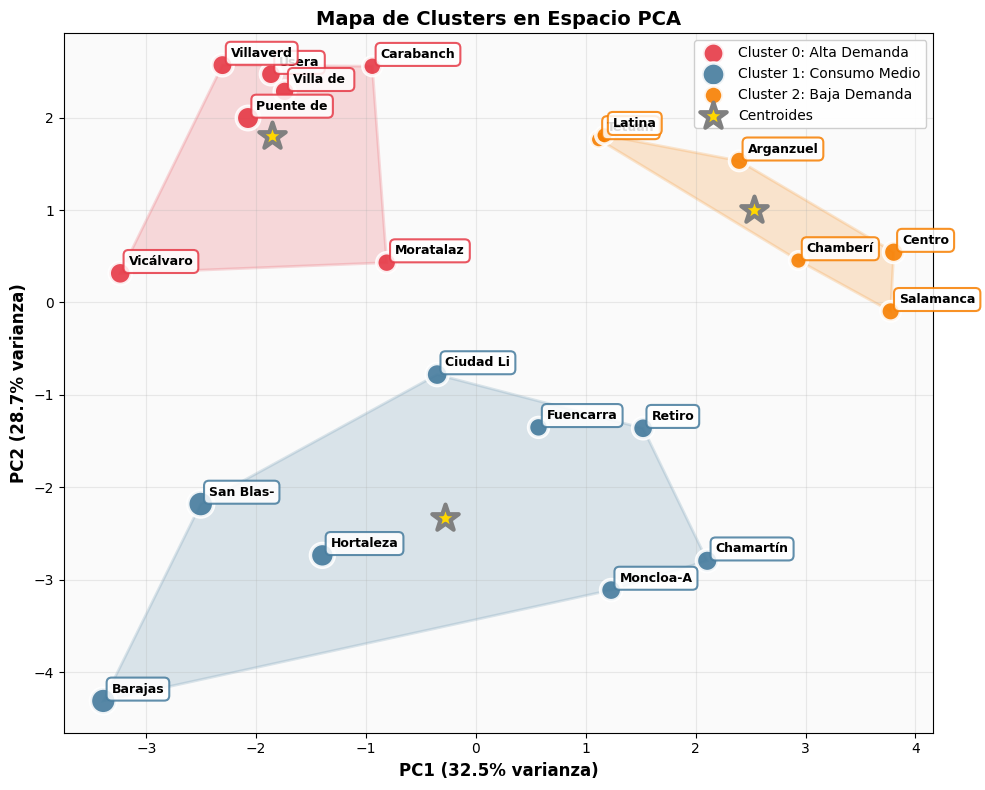

In [123]:
# === FIGURA 1: CLUSTERS EN ESPACIO PCA ===
fig, ax1 = plt.subplots(figsize=(10, 8))
colors = ['#E63946', '#457B9D', '#F77F00']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']
cluster_names = ['Alta Demanda', 'Consumo Medio', 'Baja Demanda']

for c in range(n_clusters):
    subset = X_cluster[X_cluster['cluster'] == c]
    points = subset[['pc1', 'pc2']].values

    if len(points) >= 3:
        try:
            hull = ConvexHull(points)
            ax1.fill(points[hull.vertices, 0], points[hull.vertices, 1],
                     alpha=0.18, color=colors[c], zorder=1, edgecolor=colors[c], linewidth=2)
        except:
            pass

    sizes = 150 + (subset['p50'] - X_cluster['p50'].min()) / \
            (X_cluster['p50'].max() - X_cluster['p50'].min()) * 200 if 'p50' in subset.columns else 180

    ax1.scatter(subset['pc1'], subset['pc2'], c=colors[c], s=sizes,
                alpha=0.9, edgecolors='white', linewidth=2.5, marker='o',
                label=f'{labels[c]}: {cluster_names[c]}', zorder=5)

    for _, row in subset.iterrows():
        dist_name = str(row[col_distrito])[:9]
        ax1.annotate(dist_name, (row['pc1'], row['pc2']),
                     fontsize=9, fontweight='bold', color='black',
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                               alpha=0.85, edgecolor=colors[c], linewidth=1.5),
                     xytext=(6, 6), textcoords='offset points', zorder=6)

centroids = kmeans.cluster_centers_[:, :2]
ax1.scatter(centroids[:, 0], centroids[:, 1],
            marker='*', s=400, c='gold', edgecolors='gray',
            linewidth=3, label='Centroides', zorder=10)

ax1.set_xlabel(f'PC1 ({var_explained[0]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'PC2 ({var_explained[1]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
ax1.set_title('Mapa de Clusters en Espacio PCA', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.25)
ax1.set_facecolor('#FAFAFA')
plt.tight_layout()
plt.show()


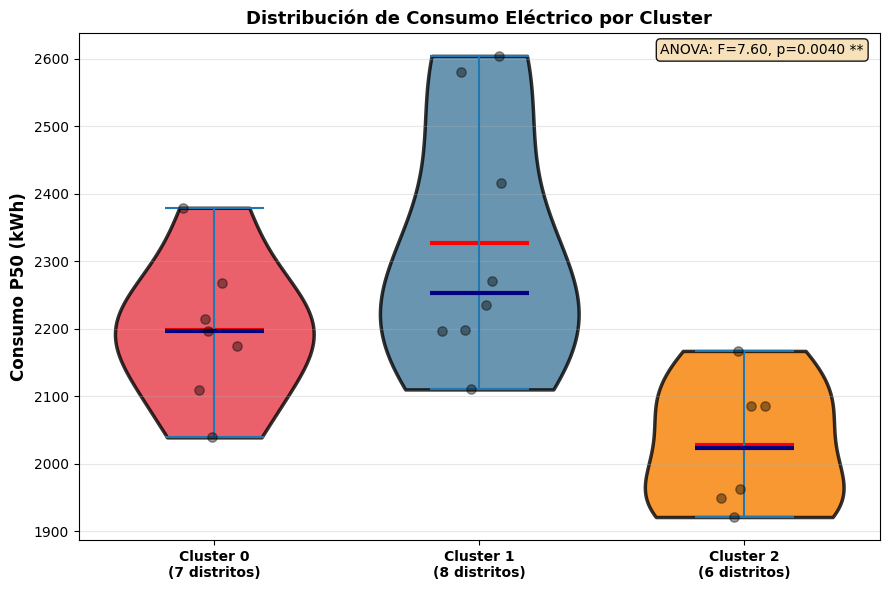

In [124]:
# === FIGURA 2: DISTRIBUCIÓN DE CONSUMO P50 POR CLUSTER ===
from scipy.stats import f_oneway

fig, ax2 = plt.subplots(figsize=(9, 6))
if 'p50' in X_cluster.columns:
    violin_data = [X_cluster[X_cluster['cluster'] == c]['p50'].dropna().values for c in range(n_clusters)]
    parts = ax2.violinplot(violin_data, positions=range(n_clusters),
                           showmeans=True, showmedians=True, widths=0.75)

    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.8)
        pc.set_edgecolor('black')
        pc.set_linewidth(2.5)

    parts['cmeans'].set_colors('red')
    parts['cmedians'].set_colors('navy')
    parts['cmeans'].set_linewidths(3)
    parts['cmedians'].set_linewidths(3)

    # Jittered scatter
    for c in range(n_clusters):
        x_jitter = np.random.normal(c, 0.08, len(violin_data[c]))
        ax2.scatter(x_jitter, violin_data[c], color='black', alpha=0.4, s=45, zorder=3)

    ax2.set_xticks(range(n_clusters))
    ax2.set_xticklabels([f'{labels[c]}\n({len(violin_data[c])} distritos)' for c in range(n_clusters)],
                        fontsize=10, fontweight='bold')
    ax2.set_ylabel('Consumo P50 (kWh)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de Consumo Eléctrico por Cluster', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # ANOVA test
    groups = [X_cluster[X_cluster['cluster'] == c]['p50'].dropna() for c in range(n_clusters)]
    if all(len(g) > 0 for g in groups):
        f_stat, p_value = f_oneway(*groups)
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        ax2.text(0.98, 0.98, f'ANOVA: F={f_stat:.2f}, p={p_value:.4f} {sig}',
                 transform=ax2.transAxes, fontsize=10, ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black'))
plt.tight_layout()
plt.show()


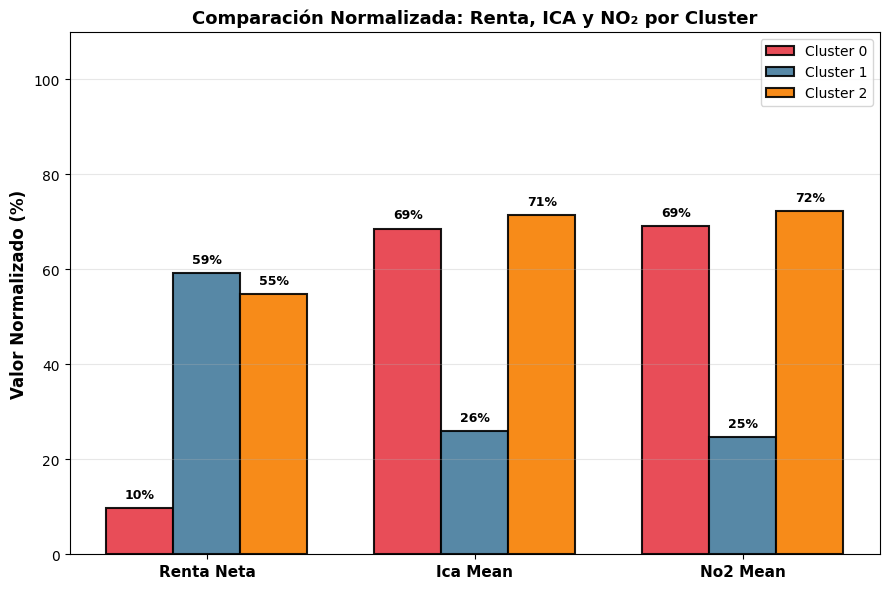

In [125]:
# === FIGURA 3: COMPARACIÓN NORMALIZADA (RENTA, ICA, NO₂) ===
fig, ax3 = plt.subplots(figsize=(9, 6))
comparar_vars = []
if 'renta_neta_media_por_persona' in X_cluster.columns:
    comparar_vars.append('renta_neta_media_por_persona')
elif 'renta_neta_media_por_hogar' in X_cluster.columns:
    comparar_vars.append('renta_neta_media_por_hogar')
if 'ica_mean' in X_cluster.columns:
    comparar_vars.append('ica_mean')
if 'no2_mean' in X_cluster.columns:
    comparar_vars.append('no2_mean')

if comparar_vars:
    cluster_means = {c: {v: (X_cluster[X_cluster['cluster']==c][v].mean() - X_cluster[v].min()) /
                            (X_cluster[v].max() - X_cluster[v].min()) * 100 for v in comparar_vars}
                     for c in range(n_clusters)}

    x = np.arange(len(comparar_vars))
    width = 0.25

    for i, c in enumerate(range(n_clusters)):
        vals = [cluster_means[c].get(v, 0) for v in comparar_vars]
        bars = ax3.bar(x + i*width - width, vals, width, label=labels[c], color=colors[c],
                       alpha=0.9, edgecolor='black', linewidth=1.5)
        for bar, val in zip(bars, vals):
            ax3.text(bar.get_x()+bar.get_width()/2., val+1.5, f'{val:.0f}%',
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax3.set_xticks(x)
    ax3.set_xticklabels([v.replace('_', ' ').title()[:10] for v in comparar_vars], fontsize=11, fontweight='bold')
    ax3.set_ylabel('Valor Normalizado (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Comparación Normalizada: Renta, ICA y NO₂ por Cluster', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.set_ylim(0, 110)
    ax3.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


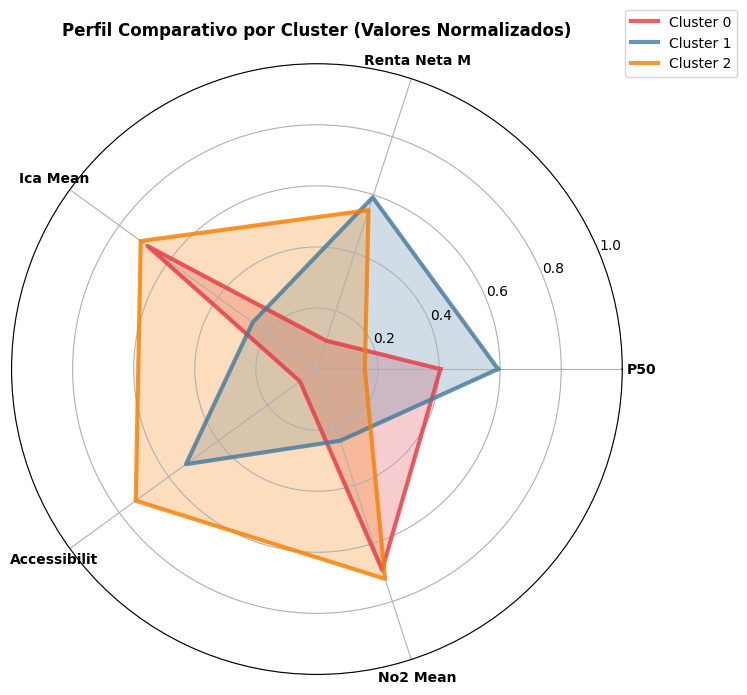

In [ ]:
# === FIGURA 4: RADAR CHART ===
fig = plt.figure(figsize=(8, 7))
ax4 = plt.subplot(111, projection='polar')

radar_vars = [v for v in ['p50', 'renta_neta_media_por_persona', 'ica_mean',
                          'accessibility_score', 'no2_mean'] if v in X_cluster.columns]

if len(radar_vars) >= 4:
    angles = np.linspace(0, 2*np.pi, len(radar_vars), endpoint=False).tolist()
    angles += angles[:1]
    for c in range(n_clusters):
        subset = X_cluster[X_cluster['cluster'] == c]
        values = []
        for var in radar_vars:
            mean_val = subset[var].mean()
            norm = (mean_val - X_cluster[var].min()) / (X_cluster[var].max() - X_cluster[var].min())
            values.append(norm)
        values += values[:1]
        ax4.plot(angles, values, linewidth=3, label=labels[c], color=colors[c], alpha=0.8)
        ax4.fill(angles, values, alpha=0.25, color=colors[c])
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels([v.replace('_',' ').title()[:12] for v in radar_vars], fontsize=10, fontweight='bold')
    ax4.set_ylim(0, 1)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
    ax4.set_title('Perfil Comparativo por Cluster (Valores Normalizados)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


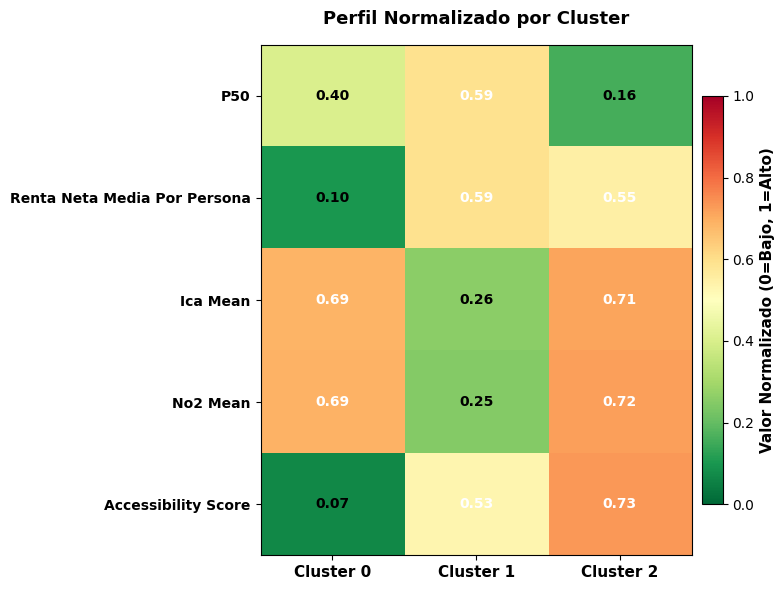

In [126]:
# === FIGURA 5: HEATMAP DE VARIABLES POR CLUSTER ===
fig, ax5 = plt.subplots(figsize=(8, 6))
heatmap_vars = [v for v in ['p50', 'renta_neta_media_por_persona', 'ica_mean',
                            'no2_mean', 'accessibility_score'] if v in X_cluster.columns]

if heatmap_vars:
    heatmap_matrix = []
    for var in heatmap_vars:
        row = []
        for c in range(n_clusters):
            cluster_val = X_cluster[X_cluster['cluster'] == c][var].mean()
            norm = (cluster_val - X_cluster[var].min()) / (X_cluster[var].max() - X_cluster[var].min())
            row.append(norm)
        heatmap_matrix.append(row)

    heatmap_array = np.array(heatmap_matrix)
    im = ax5.imshow(heatmap_array, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
    ax5.set_xticks(range(n_clusters))
    ax5.set_xticklabels(labels, fontsize=11, fontweight='bold')
    ax5.set_yticks(range(len(heatmap_vars)))
    ax5.set_yticklabels([v.replace('_',' ').title() for v in heatmap_vars], fontsize=10, fontweight='bold')

    for i in range(len(heatmap_vars)):
        for j in range(n_clusters):
            val = heatmap_array[i, j]
            ax5.text(j, i, f'{val:.2f}', ha='center', va='center',
                     color='white' if val > 0.5 else 'black', fontweight='bold')

    cbar = plt.colorbar(im, ax=ax5, shrink=0.8, pad=0.02)
    cbar.set_label('Valor Normalizado (0=Bajo, 1=Alto)', fontsize=11, fontweight='bold')
    ax5.set_title('Perfil Normalizado por Cluster', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()
